In [2]:
import pandas as pd
import numpy as np
from collections import Counter


In [3]:
from google.colab import drive
!cd ~
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA"
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA
'family msa_gen_vector_iadf+.ipynb'
 msa_gen_vector_iadf+.ipynb
 msa_gen_vector_iadf.ipynb
 msa.ipynb
 RE_df.gsheet
 RE_df.tsv
 res_of_iadf_pca.csv
 res_of_iadf_plus_pca
 res_of_iadf_plus_pca.csv
 res_of_pca_tfidf.csv
'results summerizetion.ipynb'
'submission of PCA msa_gen_vector_iadf+.ipynb'
'submission of PCA msa_gen_vector_iadf.ipynb'
'submission of PCA msa_gen_vector_tf_idf.ipynb'
'submission of TSNE msa_gen_vector_iadf+.ipynb'


In [4]:
df_data = pd.read_csv('RE_df.tsv', sep='\t')
df_data['family_lable'] =  df_data['msa'].str.split('_').str[0]
family_lables = df_data['family_lable'].to_list()
dataset = df_data['seq'].tolist()
true_lables = df_data['is_RE'].tolist()

In [5]:
def kmers_extraction(msa, kmer_size=3):
  kmers=[]
  for i,_ in enumerate(msa):
    if i < len(msa)-kmer_size+1:
      kmers.append(msa[i:i+kmer_size])
  return kmers


In [6]:
def preprocess(dataset):
 return [kmers_extraction(i) for i in dataset ]
processed_text = preprocess(dataset)

In [7]:

DF = {}
for i in range(len(processed_text)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [8]:
total_vocab = [x for x in DF]
# total_vocab

In [9]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return len(c)

In [10]:
import math 

 # mean df for ne algo

tf_idf = {}

N = len(dataset)

def gen_vector_iadf_plus(tokens):
  doc = 0
  sum_df = 0
  for token in np.unique(tokens):
    df = doc_freq(token)
    sum_df +=df
    doc += 1
  mean_df = sum_df /  len(np.unique(tokens))

  Q = np.zeros((len(total_vocab)))

  counter = Counter(tokens)
  words_count = len(tokens)

  query_weights = {}
  
  doc = 0
  n_ = np.unique(tokens)
  for token in np.unique(tokens):
      
      tf = counter[token]/words_count
      df = doc_freq(token)
      if (df- mean_df) ==0:
        df + 0.00001
      df_ = math.log(abs(df- mean_df)/len(n_)+1)+1 # for new algo. - mean_df devide n

      idf = math.log((N+1)/(df_+1))

      try:
          ind = total_vocab.index(token)
          Q[ind] = tf*idf
      except:
          pass
  return Q


# the run

# PCA

In [11]:
vecs = [ gen_vector_iadf_plus(i)  for i in preprocess(dataset)]
# vecs

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns
from numpy import reshape

def pca(vecs):
  x = np.array(vecs)
  # x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])
  pca = PCA(n_components=2)
  z = pca.fit_transform(x)
  df = pd.DataFrame()

  df["y"] = family_lables
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df['color'] = true_lables
  # df = df.query('y=="Salmonella"')
  return df, z
  

In [13]:
df , z = pca(vecs)


# families clusters


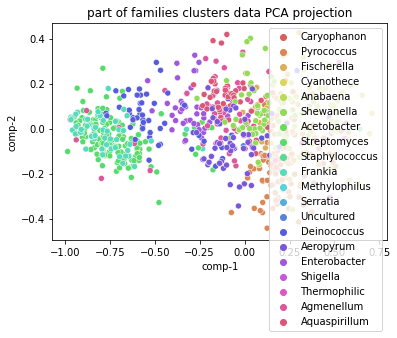

In [14]:
## families clusters
part_of_families = list(set(family_lables))[30:50]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

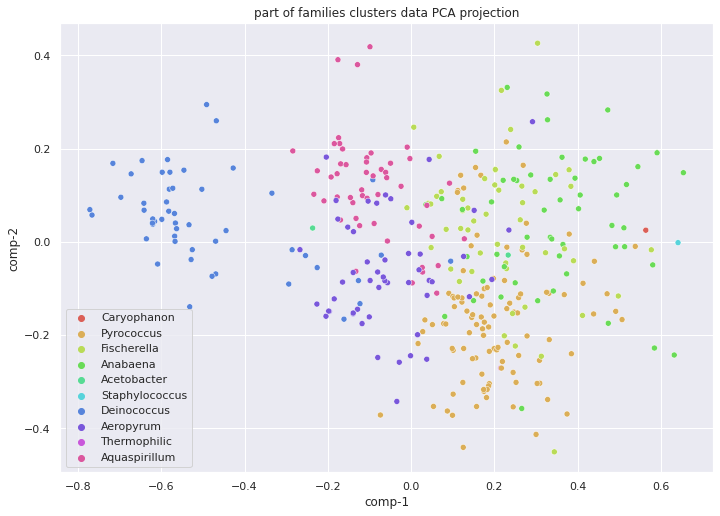

In [15]:
## families clusters
part_of_families = list(set(family_lables))[30:40]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [16]:
# tsne visualizetion by family

<ipython-input-17-93fa05f27660>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


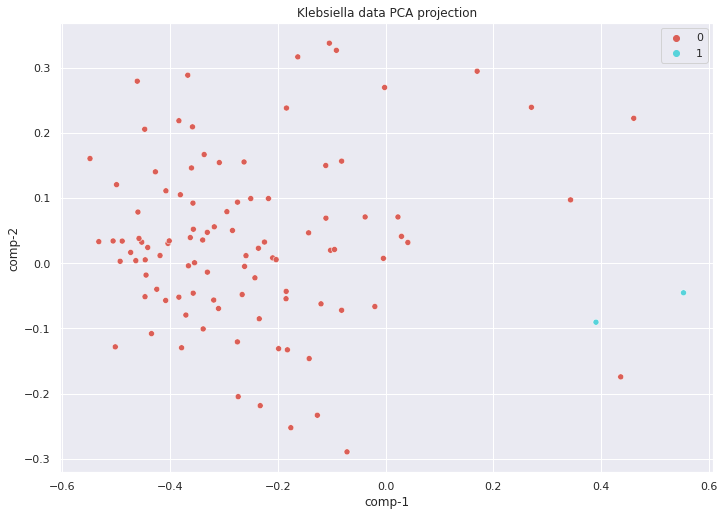

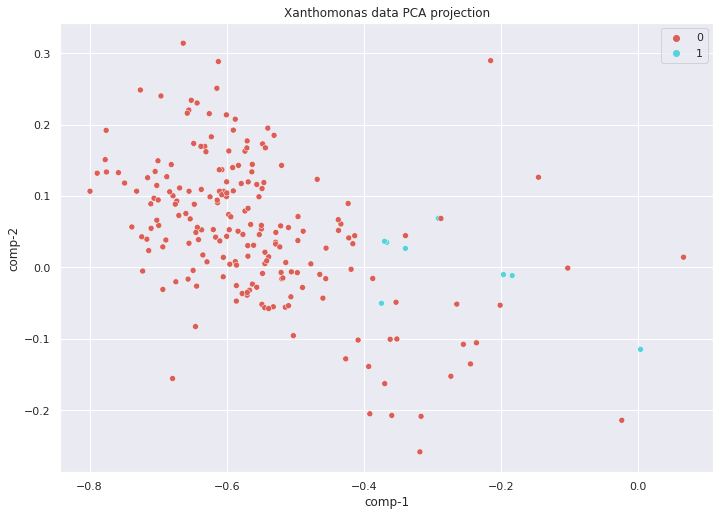

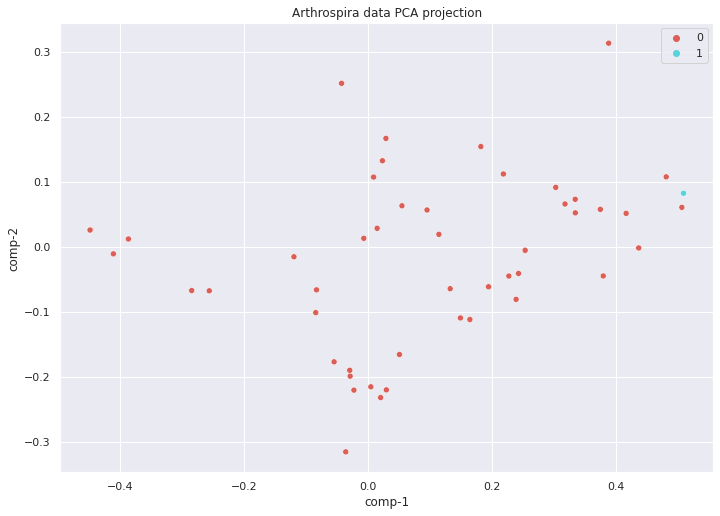

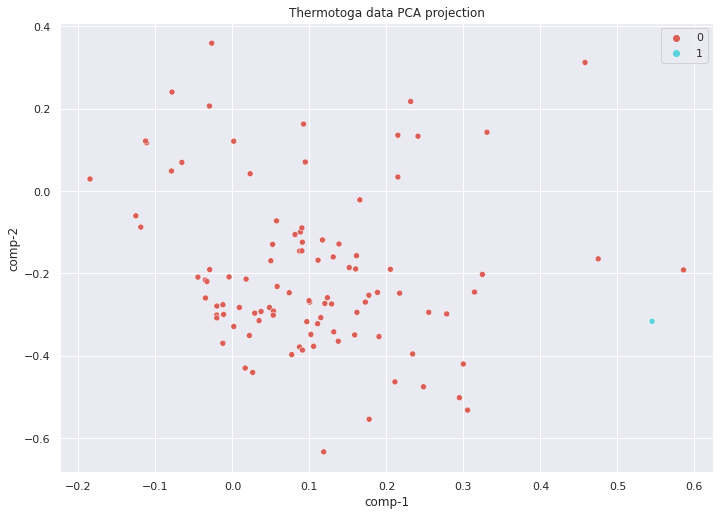

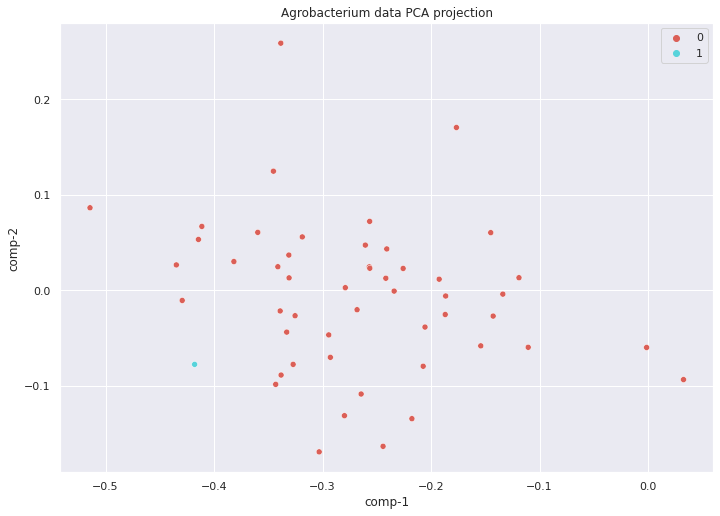

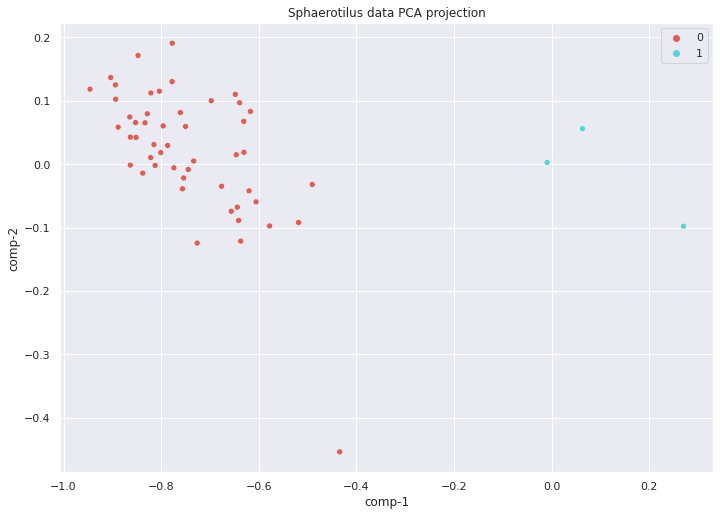

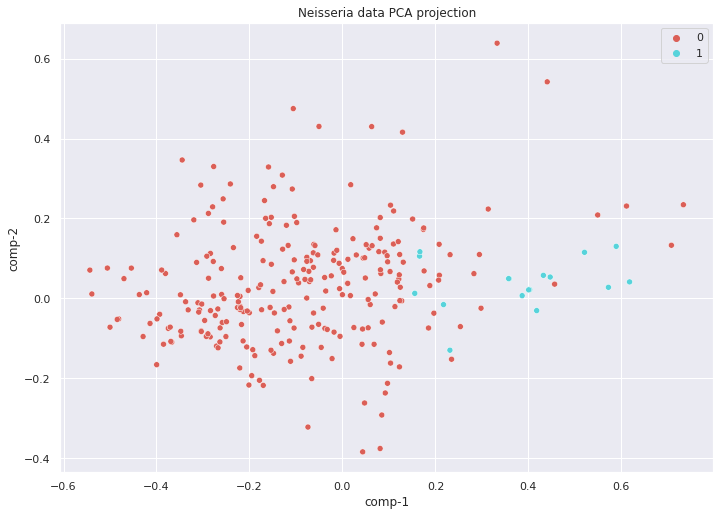

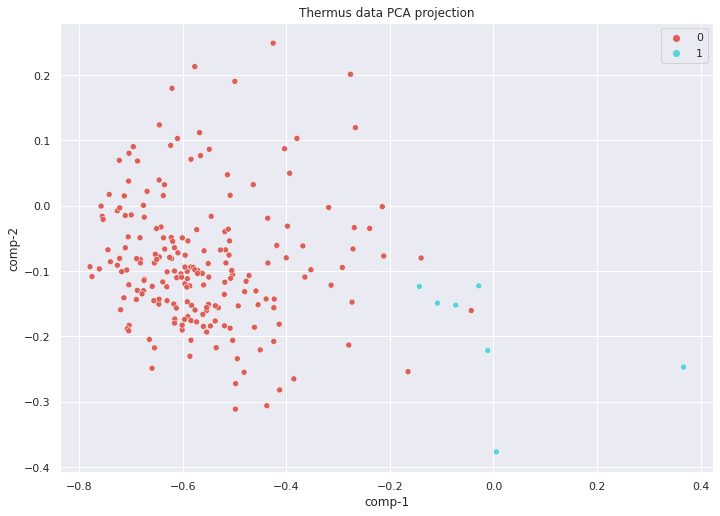

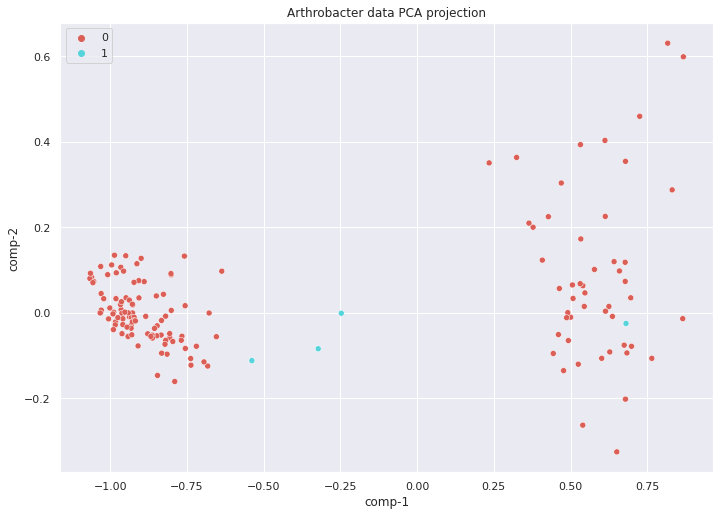

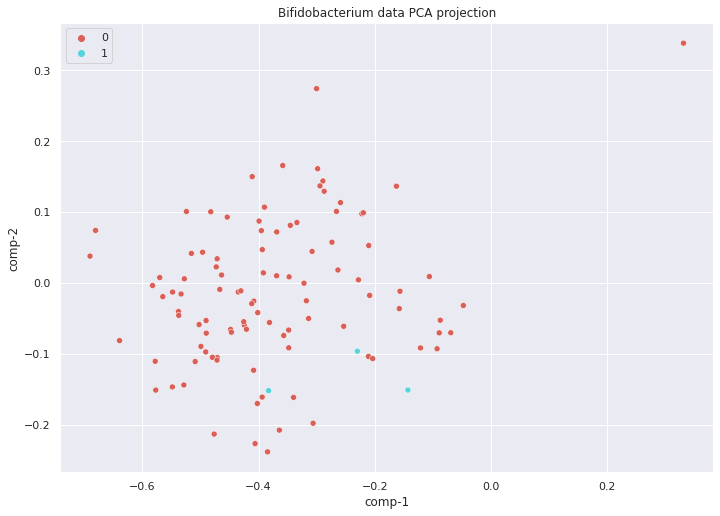

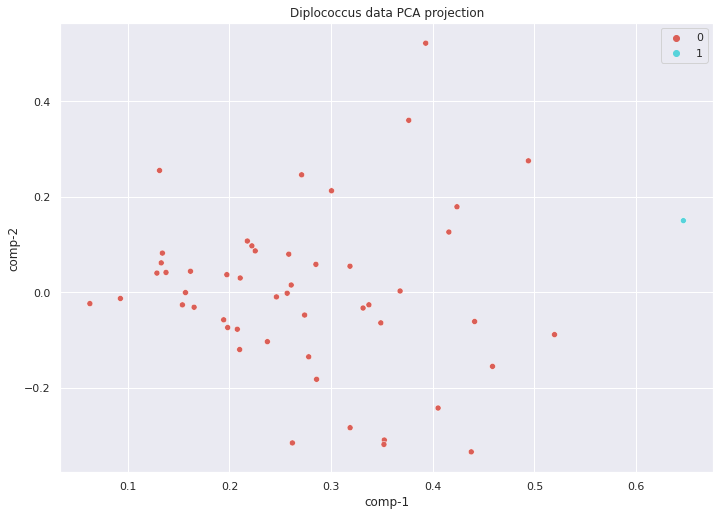

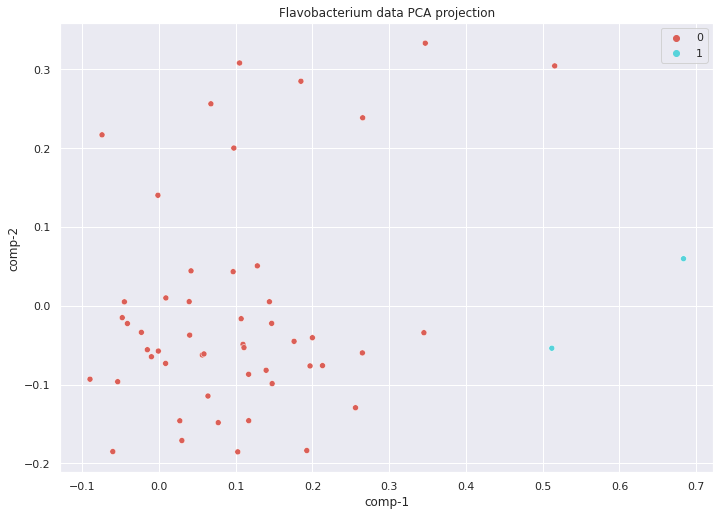

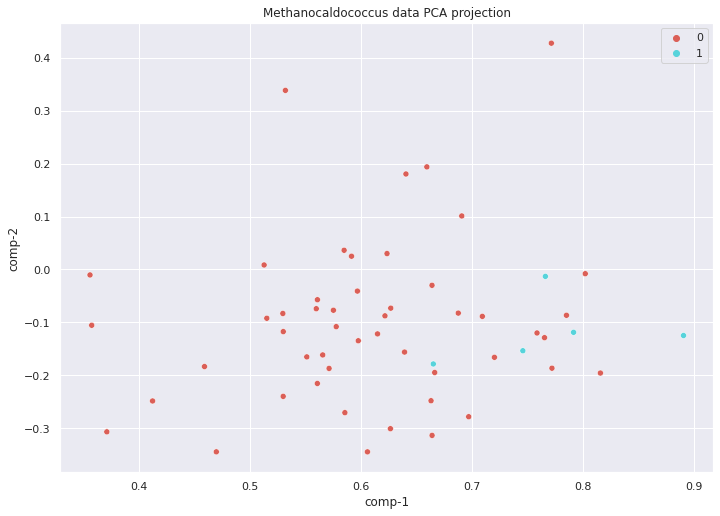

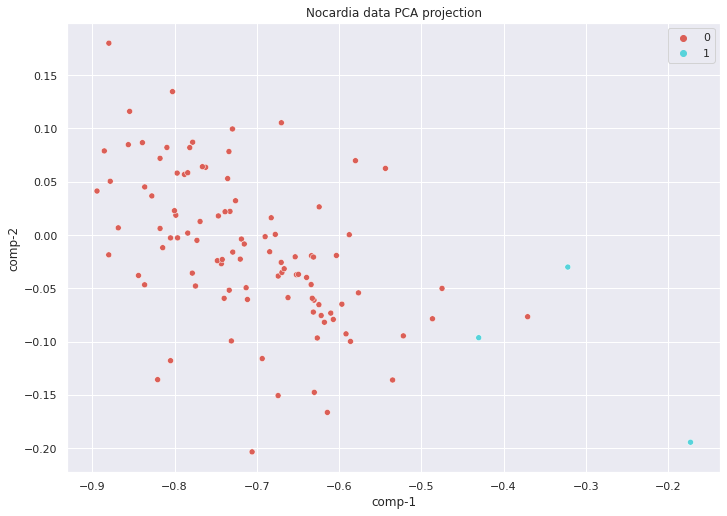

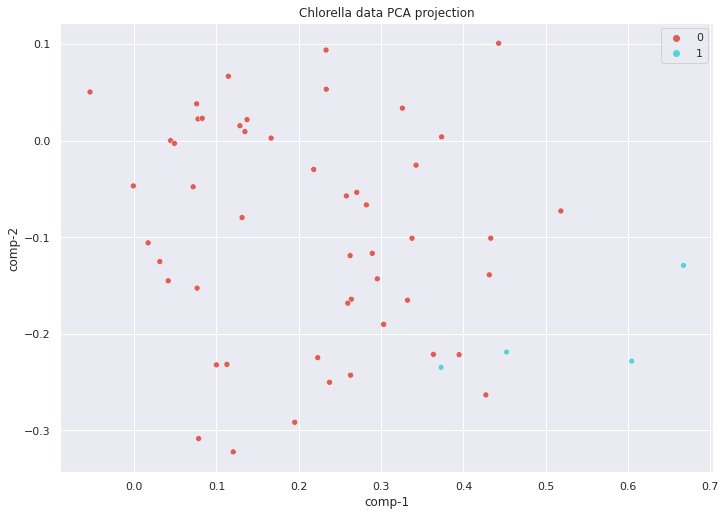

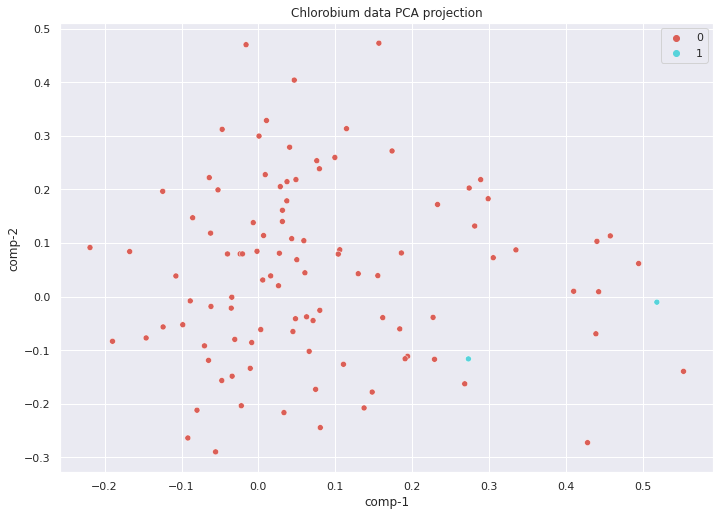

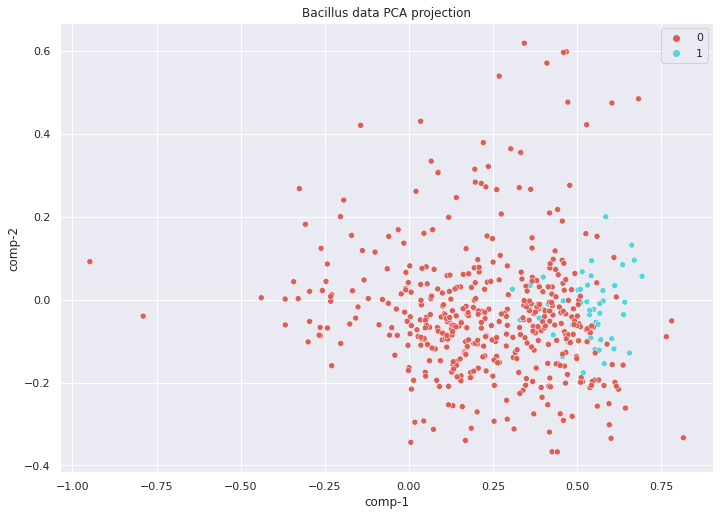

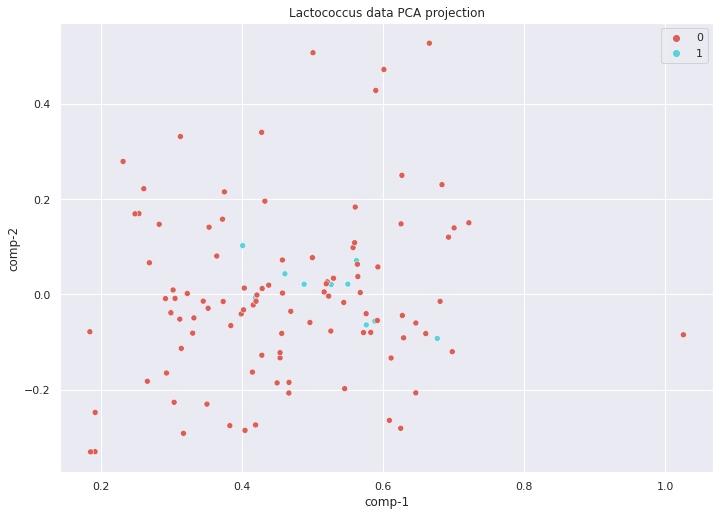

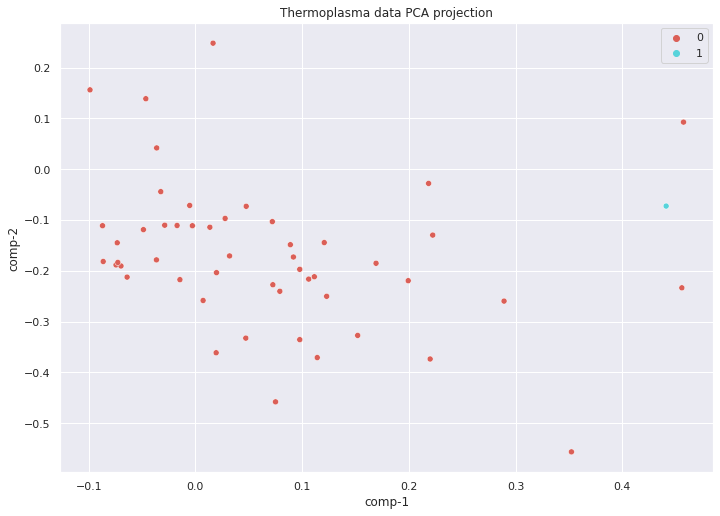

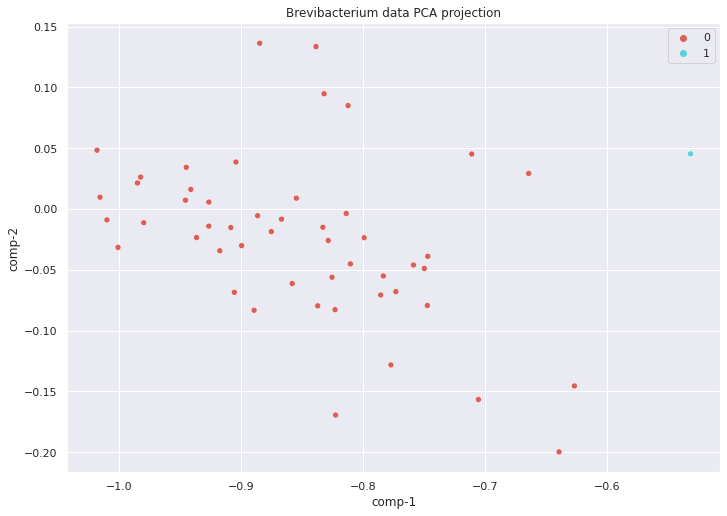

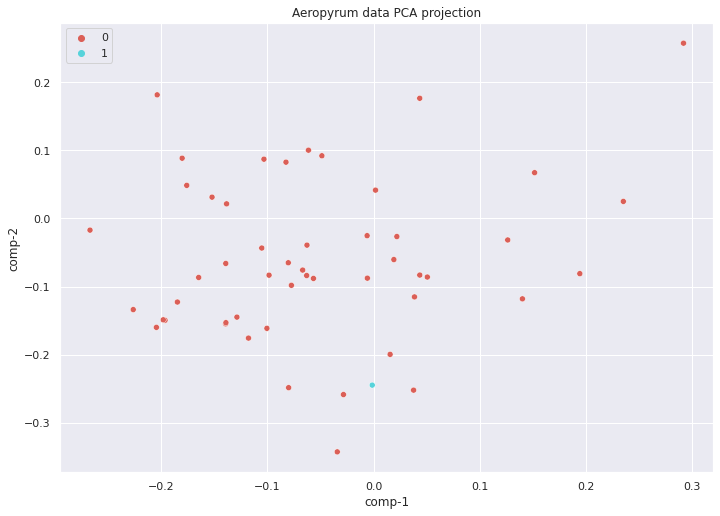

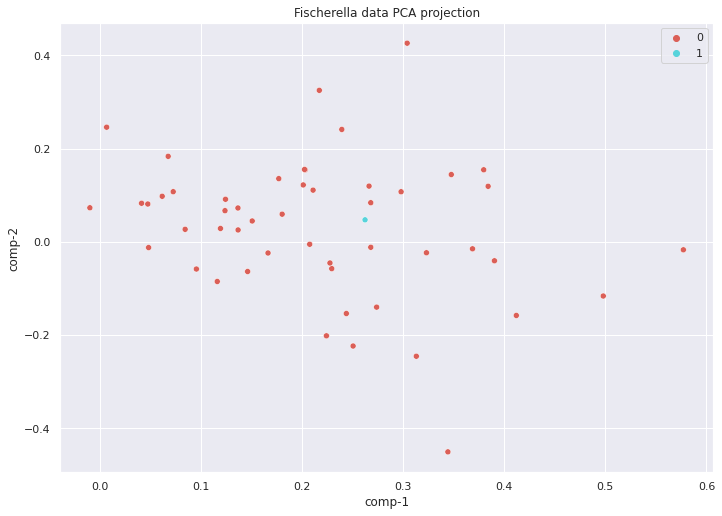

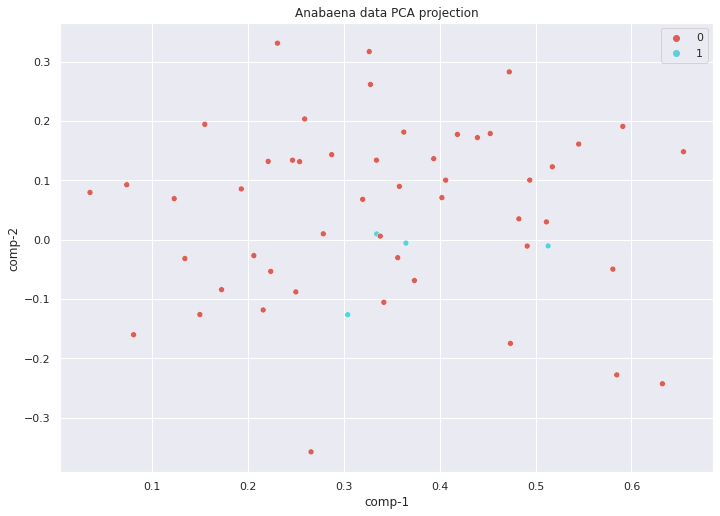

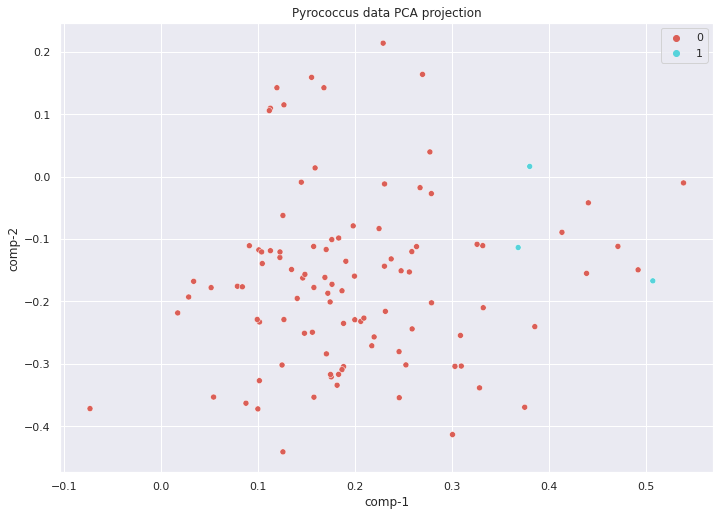

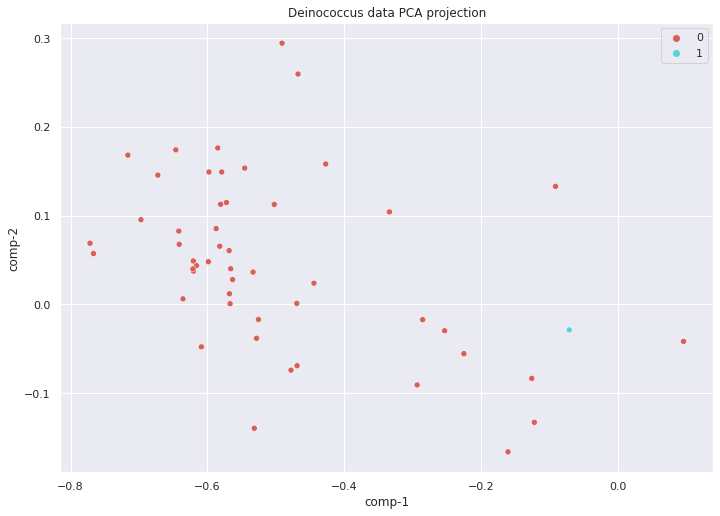

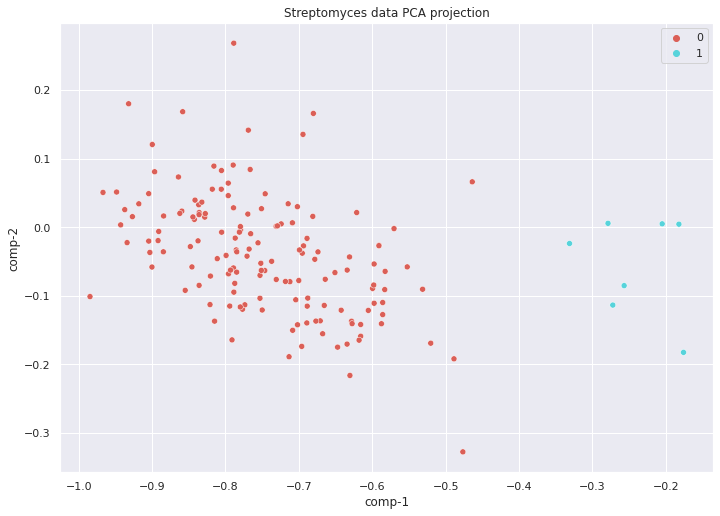

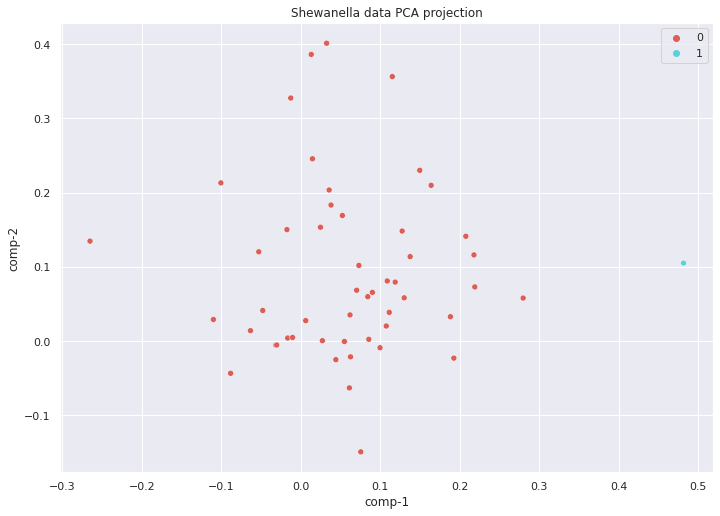

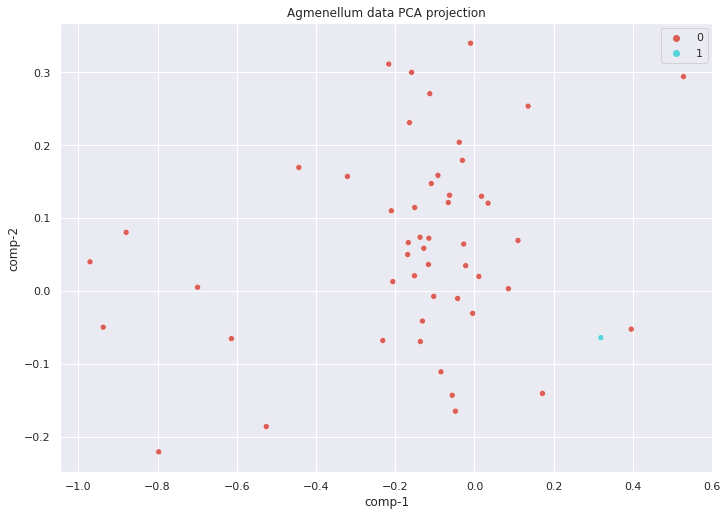

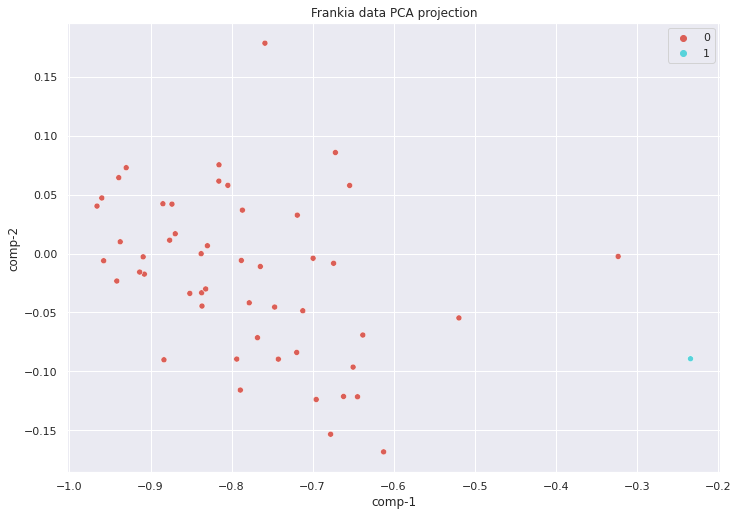

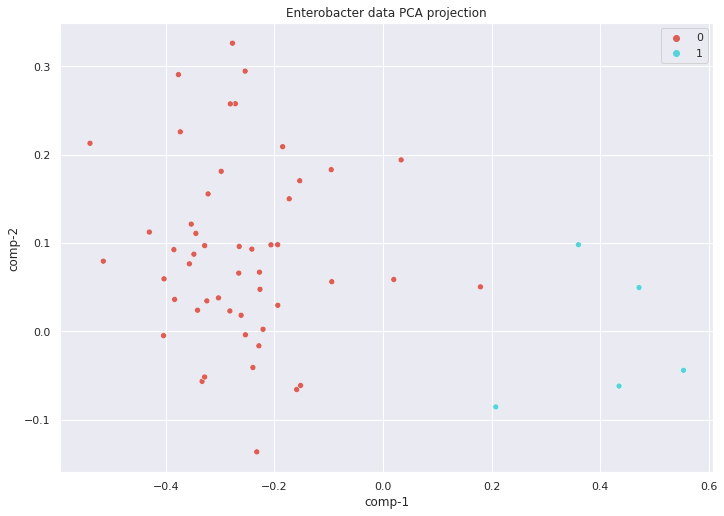

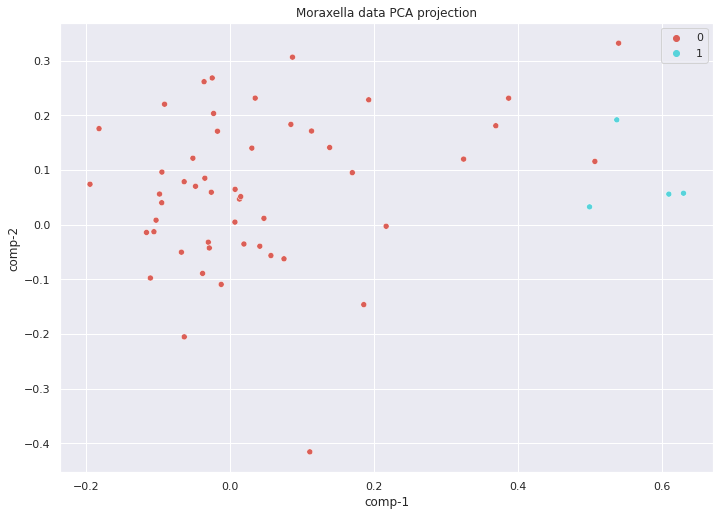

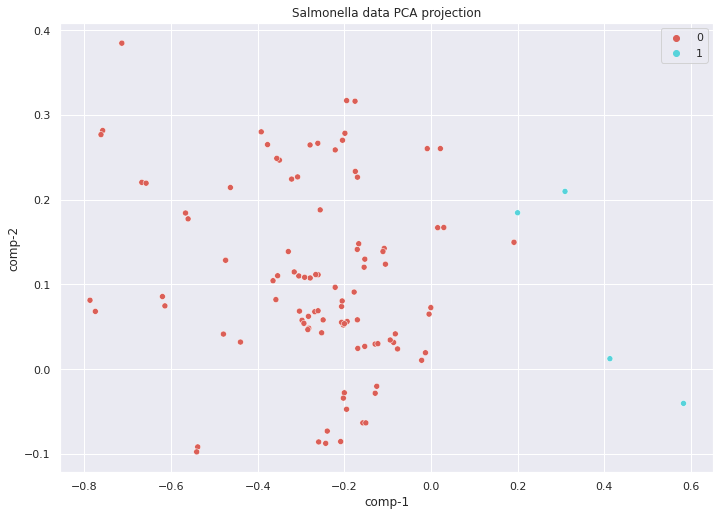

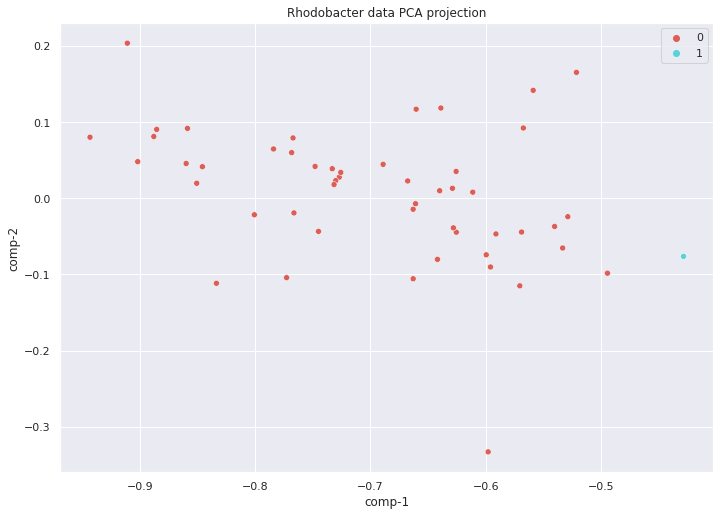

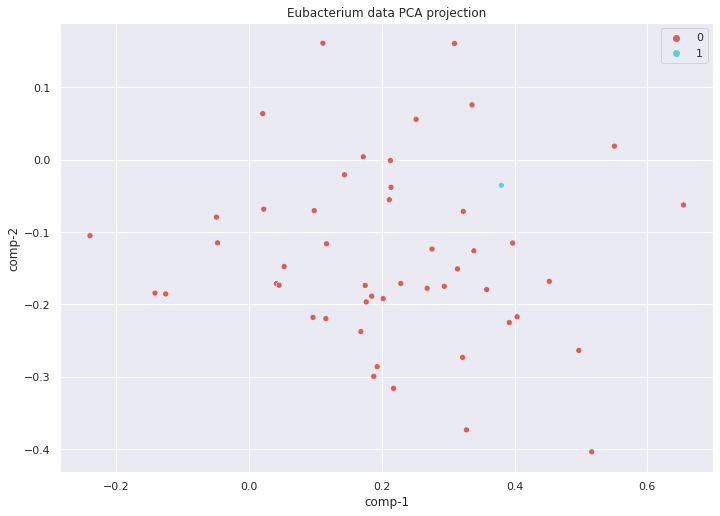

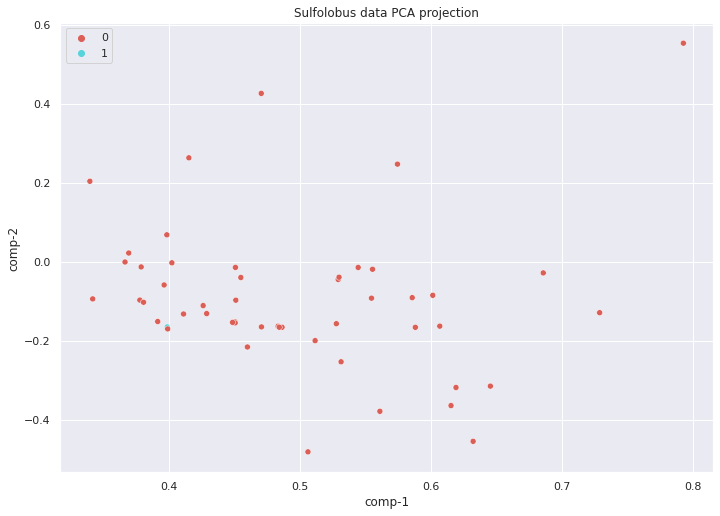

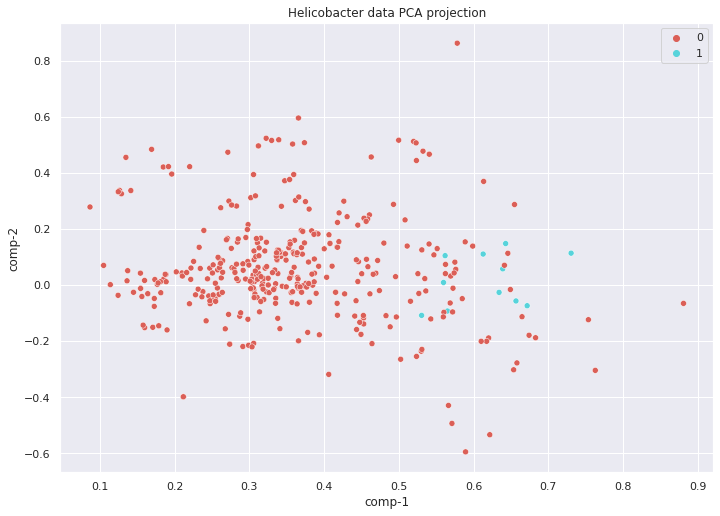

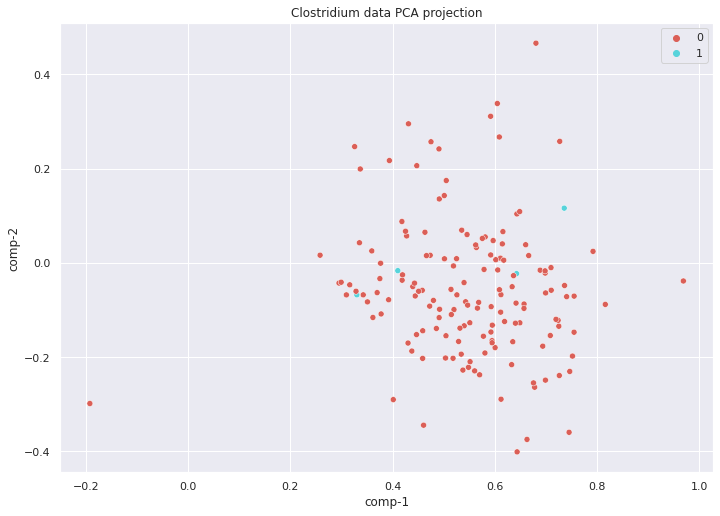

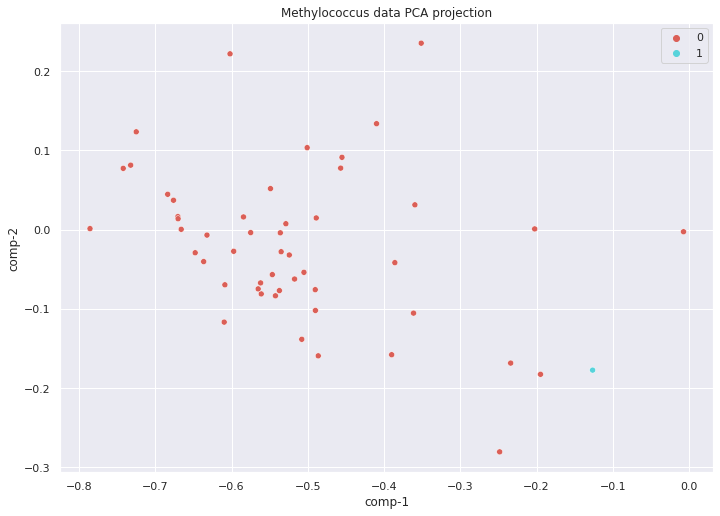

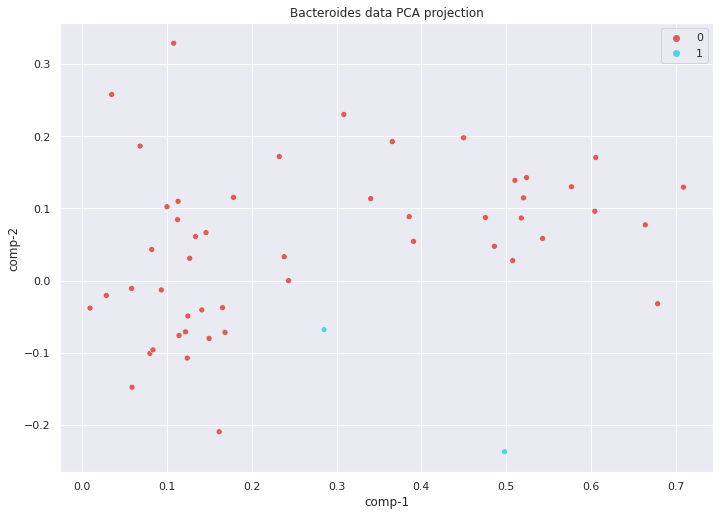

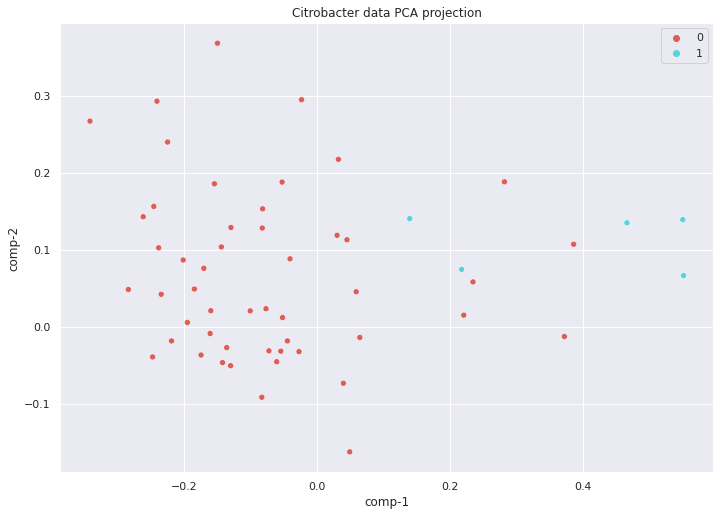

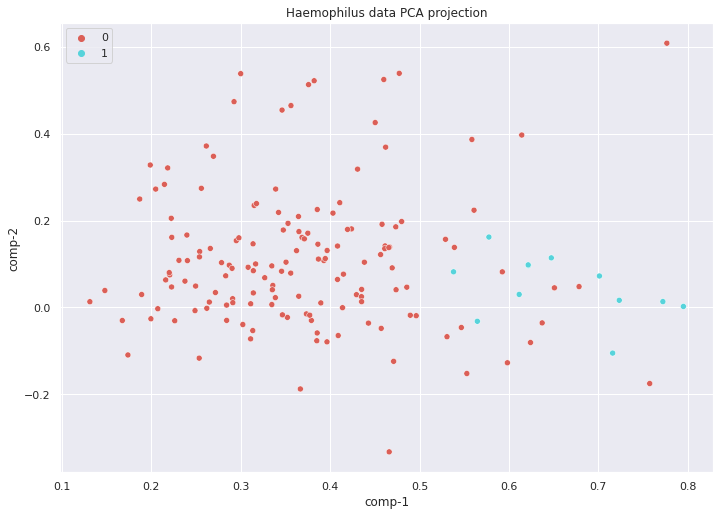

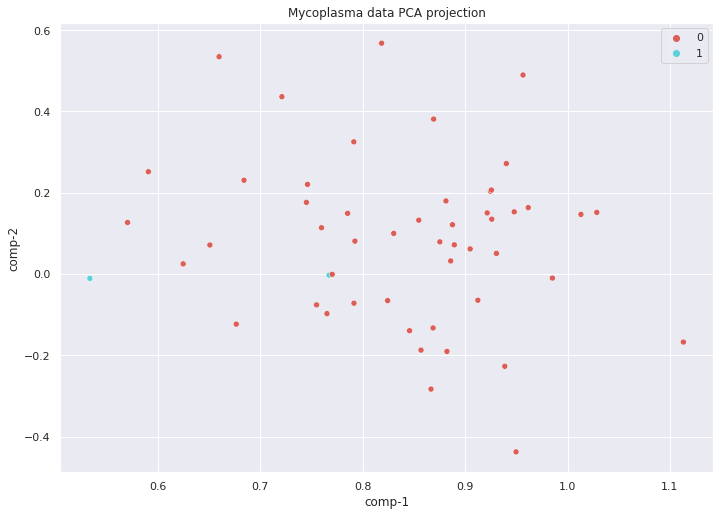

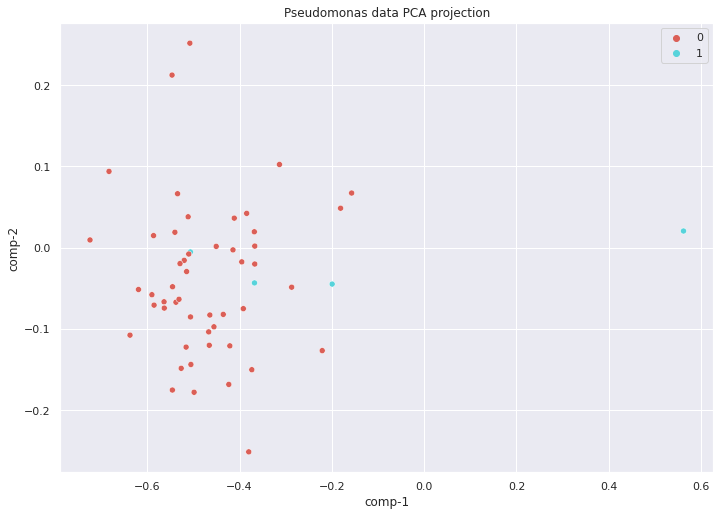

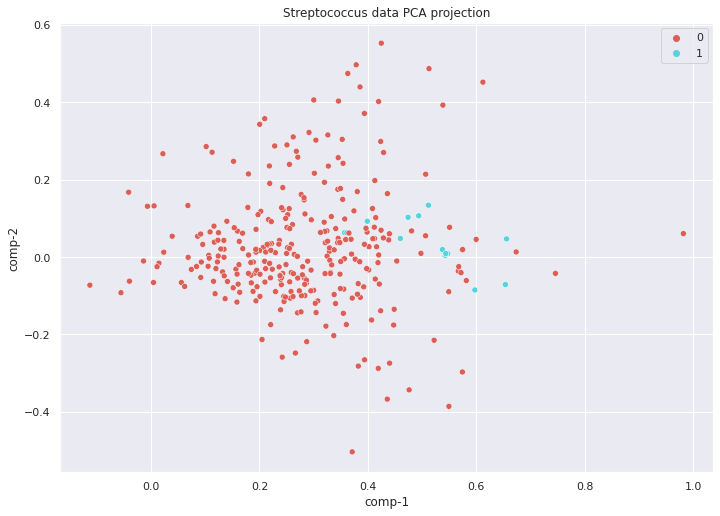

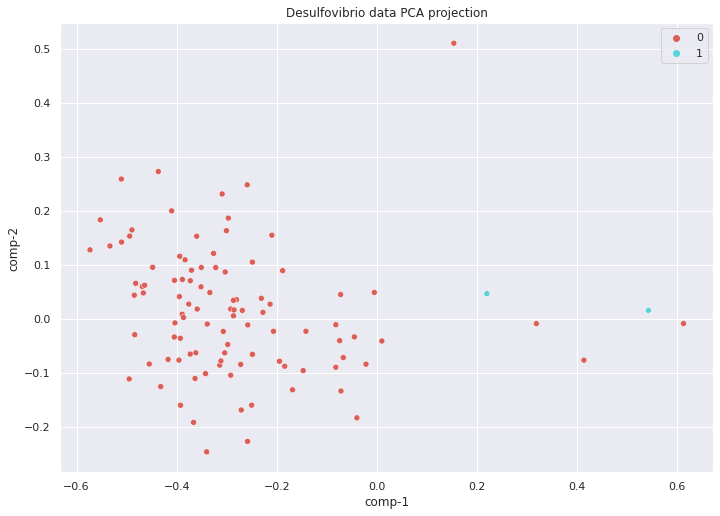

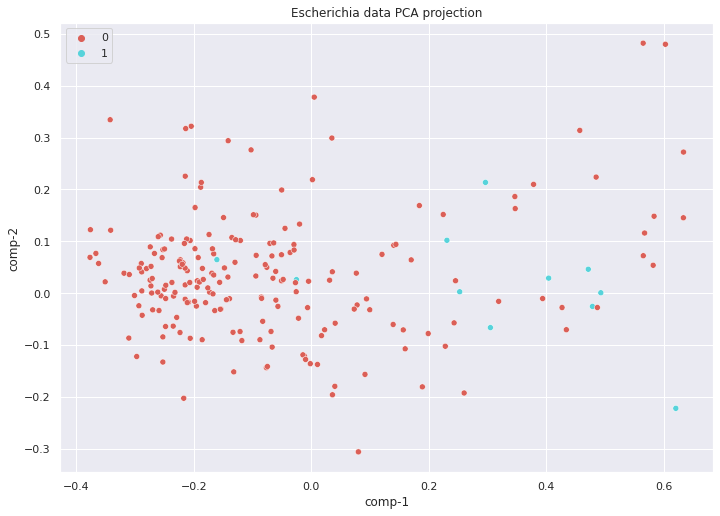

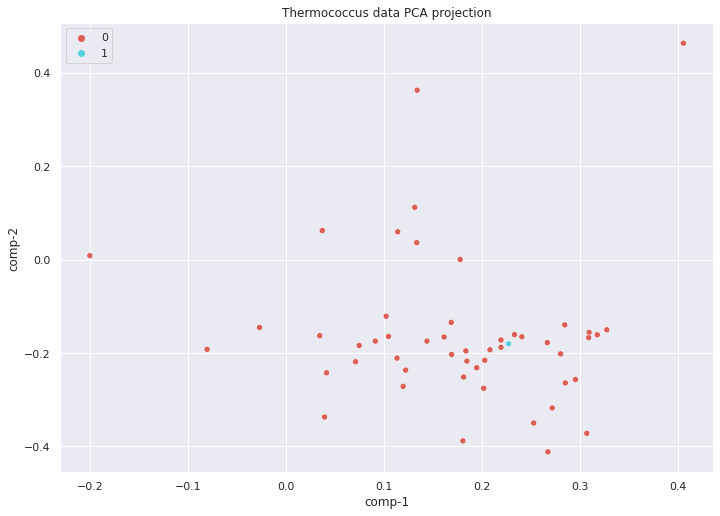

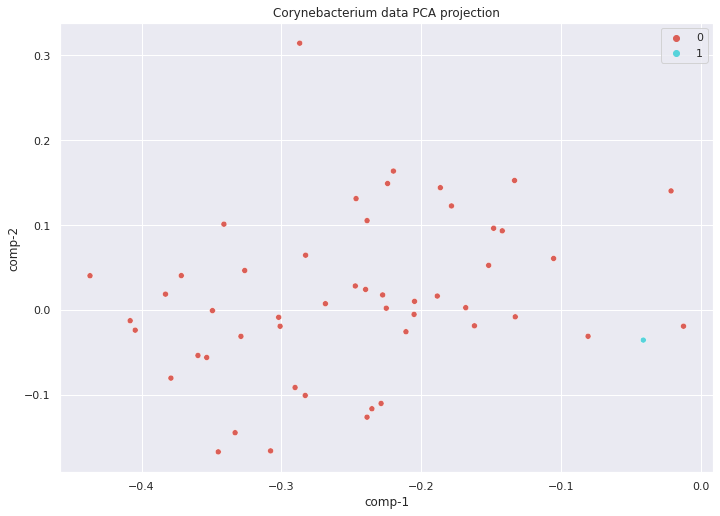

In [17]:
import matplotlib.pyplot as plt

for i in set(family_lables):
  df1= df.query('y==@i') ### very bad example: Thermococcus - maybe good
  if len(df1.color.unique())>1:
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.color.tolist(),
                      palette=sns.color_palette("hls", 2),sizes=[600,800],
                      data=df1).set(title=f"{i} data PCA projection")
      
    sns.set(rc={'figure.figsize':(11.7,8.27)})


# general function

In [18]:
def confusion_matrix_re(true_lables, pred_lables):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  sum = 0
  for true, pred in zip(true_lables, pred_lables):
    if true == 1 and  pred == -1:
      tp +=1
    if true == 1 and  pred != -1:
      fp += 1
    if true == 0 and  pred == -1:
      fn +=1
    if true == 0 and  pred != -1:
      tn +=1
  return tp/len(true_lables) , fp/len(true_lables), fn/len(true_lables),  tn/len(true_lables)



In [19]:
confusion_matrix_re([1,0,0,0,1], [-1,0,0,0,1])

(0.2, 0.2, 0.0, 0.6)

In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics import homogeneity_completeness_v_measure


all_res_table= []


def clustering_function(familyes,df_data, df, algorithem, params):
  familyes =  sorted(familyes)
  num_of_family = 0
  for  i  in familyes:
    d = {}
    d['algo'] = algorithem
    df1= df.query('y==@i')
    df_data1 = df_data.query('family_lable==@i')
   
    true_labels = df_data1.is_RE.tolist()

    if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
      print('-------------------')
      print(i)
      d['family_lable'] = i 
      print (num_of_family ,i)
      if params:
        algo = algorithem(**params[num_of_family])
      else:
        algo = algorithem()
      pred_labels = algo.fit_predict(df1[['comp-1','comp-2']].values)
      if len(set(pred_labels))>1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        print(f"Adjusted Rand Index: {ari}")

        d['ari'] = ari 

        fmi = fowlkes_mallows_score(true_labels, pred_labels)
        print(f"fowlkes_mallows_score: {fmi}")

        d['fmi'] = fmi 

        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, pred_labels)
        print(f"homogeneity_completeness_v_measure: {homogeneity} {completeness} {v_measure}")


        d['homogeneity'] = homogeneity 
        d['completeness'] = completeness 
        d['v_measure'] = v_measure 

        tp, fp, fn, tn = confusion_matrix_re(true_labels, pred_labels)
        d['tp'] = tp
        d['fp'] = fp
        d['fn'] = fn
        d['tn'] = tn

        d['family_size'] = len(true_labels)
        d['re_size'] = np.sum(true_labels)


        all_res_table.append(d)
      else:
        print('caoudnot seperate to clusters')

      num_of_family +=1

      markers = ["." if label == 0 else "d" for label in true_labels]
      if -1 in pred_labels:
        colors = ["red" if label == -1 else "black" for label in pred_labels]
      else:
        colors = ["blue" if label == 1 else  "orange" for label in pred_labels]

    

      for i in range(len(markers)):
        plt.scatter(df1['comp-1'].values[i], df1['comp-2'].values[i], c=colors[i] ,marker=markers[i])
      plt.show()





# dbscan

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

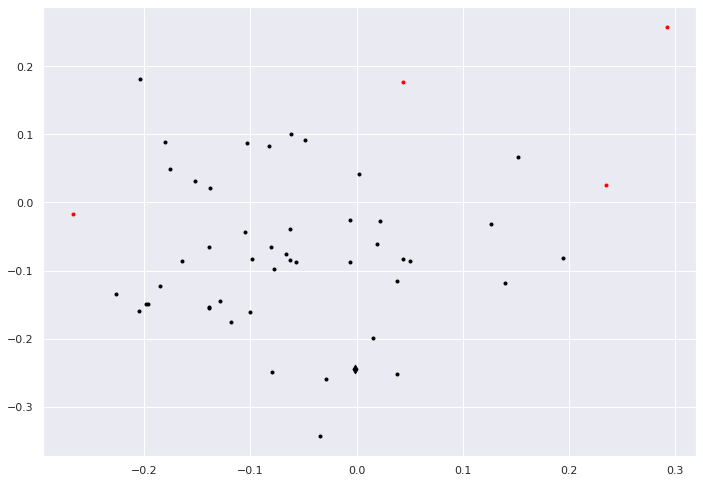

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


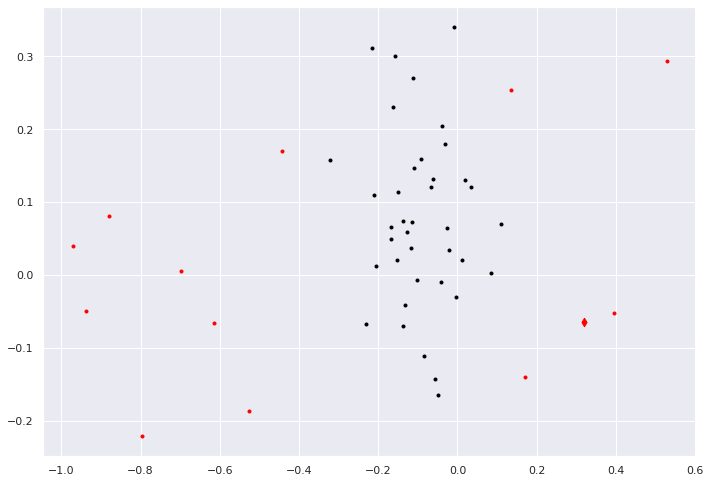

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


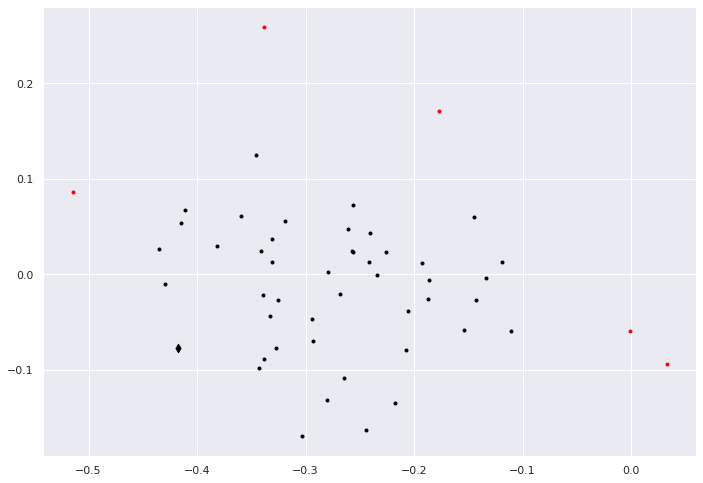

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.08315311418685122
fowlkes_mallows_score: 0.75237640973571
homogeneity_completeness_v_measure: 0.05995047744811857 0.03303669083838815 0.04259868163669314


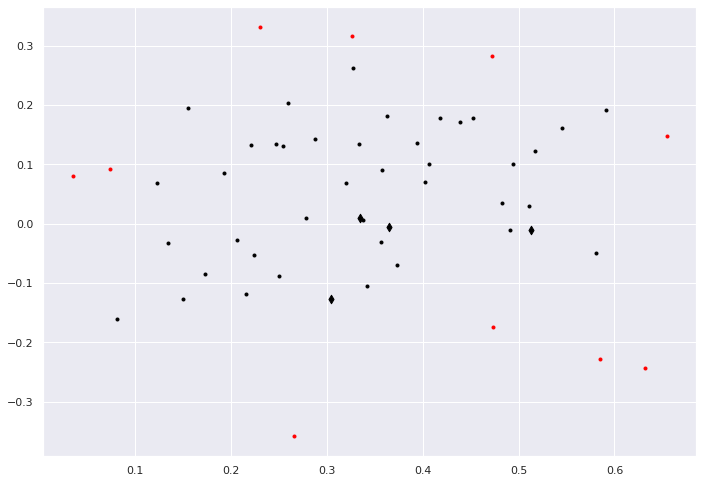

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.07272002669111087
fowlkes_mallows_score: 0.7090961329680366
homogeneity_completeness_v_measure: 0.3344797952096191 0.04679808577309396 0.082108167960031


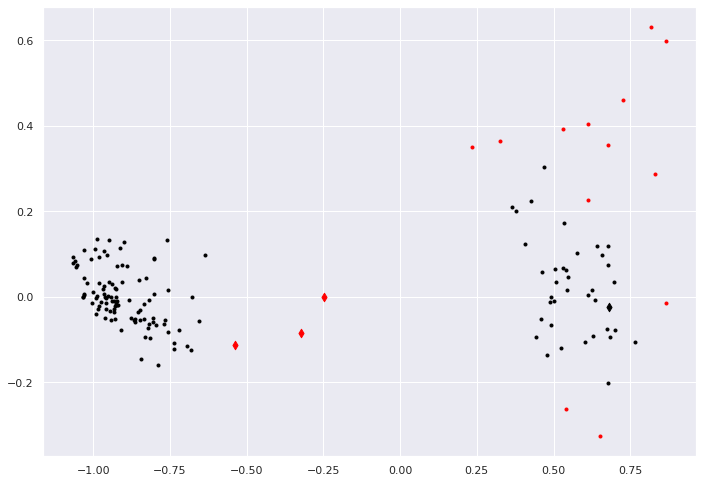

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.012657715949530897
fowlkes_mallows_score: 0.44633959917939575
homogeneity_completeness_v_measure: 0.21533959051027887 0.013534664659944295 0.02546856258165583


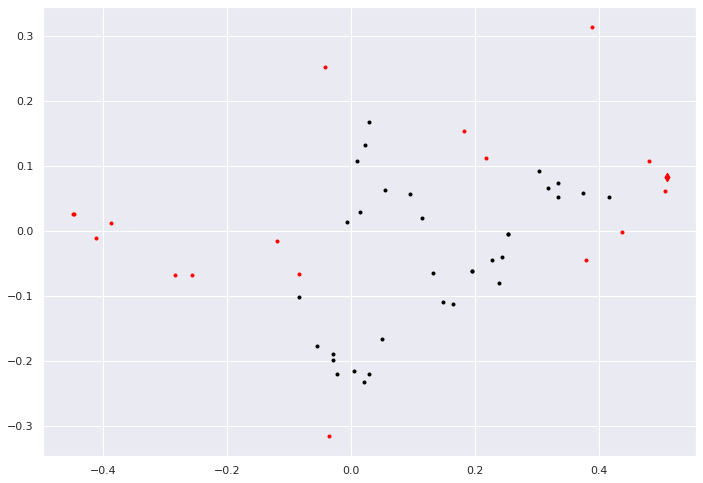

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.06657080067528398
fowlkes_mallows_score: 0.6967358053375112
homogeneity_completeness_v_measure: 0.027412344381433845 0.012914634213691182 0.017557496889625497


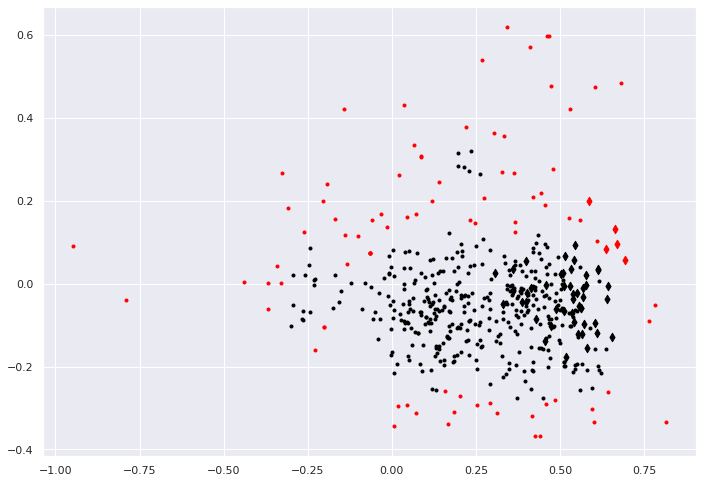

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.014546158312366945
fowlkes_mallows_score: 0.612670536655276
homogeneity_completeness_v_measure: 0.13553209155467766 0.022455080499346372 0.03852697641887506


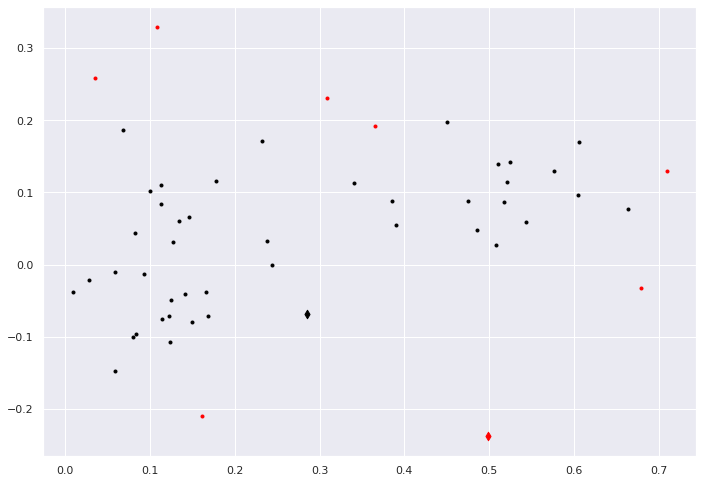

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.048010479046228204
fowlkes_mallows_score: 0.834767144115443
homogeneity_completeness_v_measure: 0.05831848987705575 0.014365230439266324 0.023052164702301203


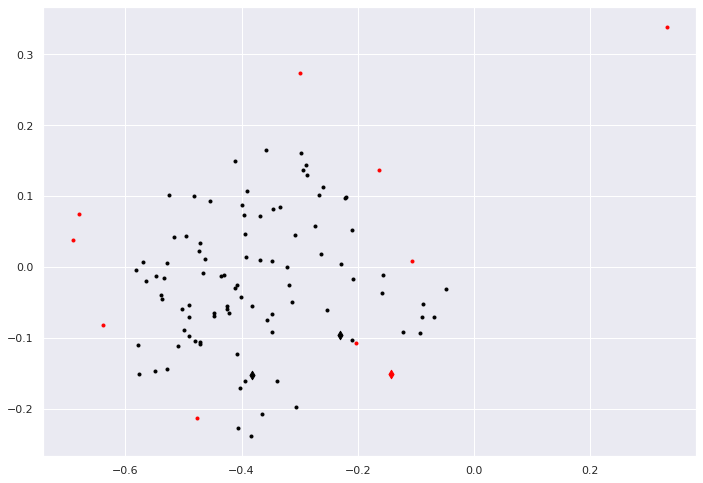

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


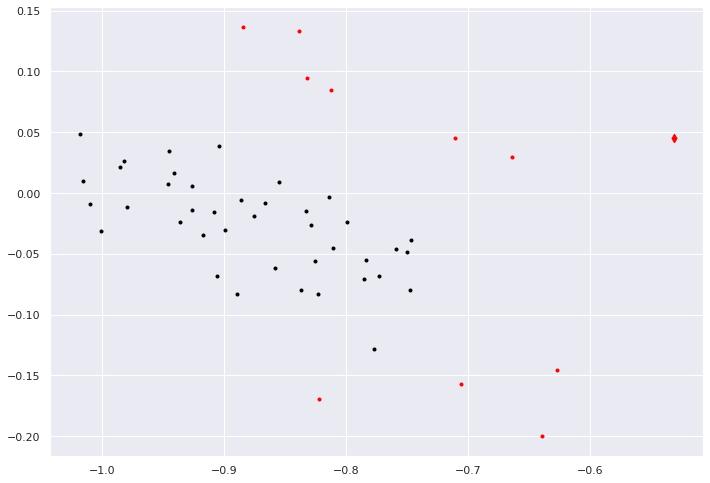

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.506821821720356
fowlkes_mallows_score: 0.9391843282252444
homogeneity_completeness_v_measure: 0.2743321339033384 0.33761301296755664 0.30270065464042434


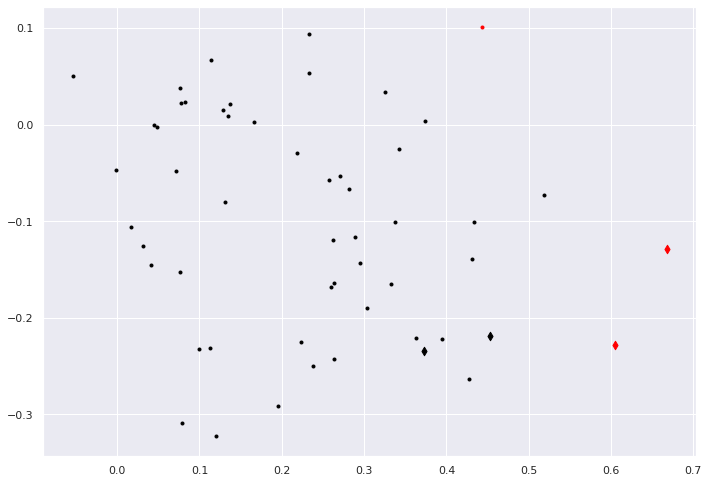

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.04337659632132136
fowlkes_mallows_score: 0.7877225010096922
homogeneity_completeness_v_measure: 0.1997326926408739 0.025704456136976896 0.04554724245706969


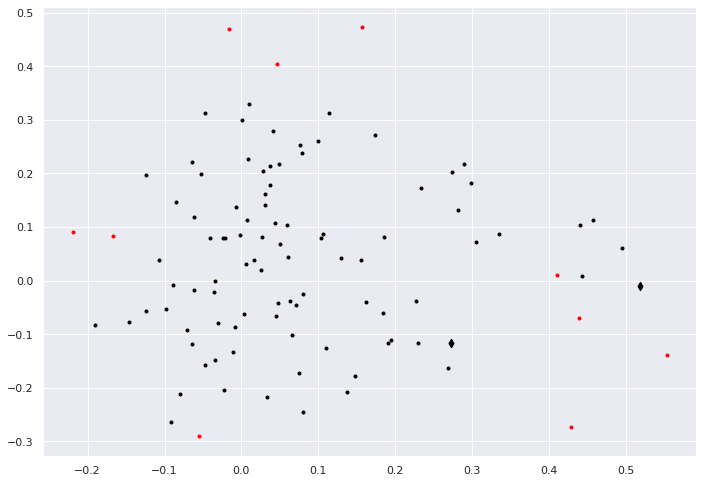

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.34154883901932803
fowlkes_mallows_score: 0.8364354502155553
homogeneity_completeness_v_measure: 0.28480758549359114 0.17338579363136494 0.2155491174374741


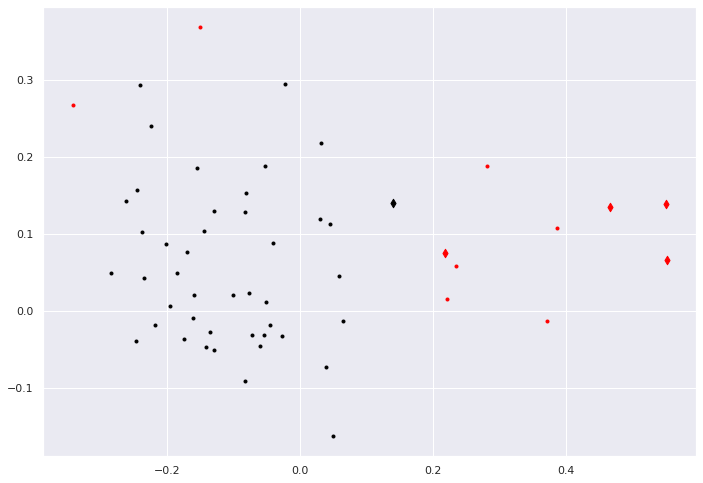

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.05229984455554004
fowlkes_mallows_score: 0.88470627814606
homogeneity_completeness_v_measure: 0.019217340814863728 0.006939810480030431 0.010197188652675679


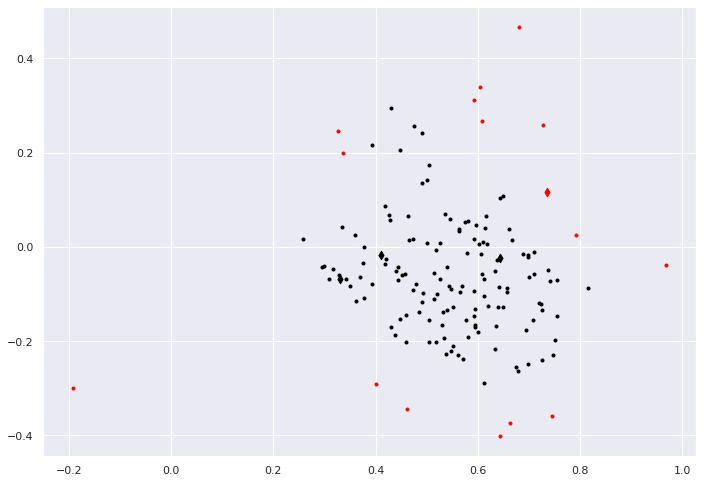

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.07004239771121298
fowlkes_mallows_score: 0.7538147272186949
homogeneity_completeness_v_measure: 0.36214622269949165 0.04559099561789445 0.08098650851773632


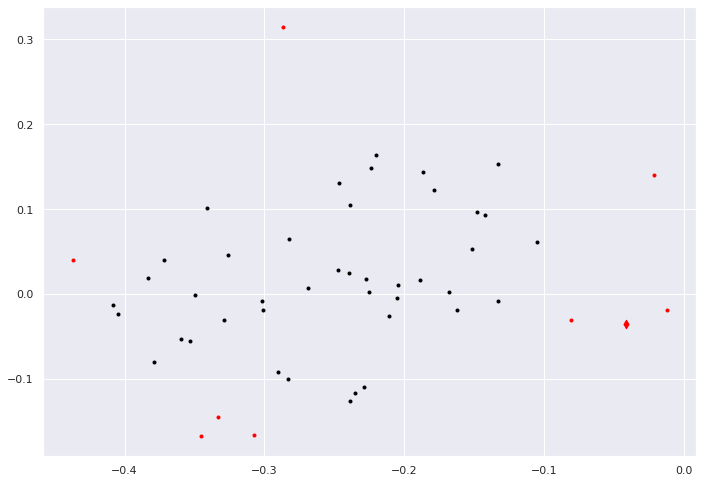

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


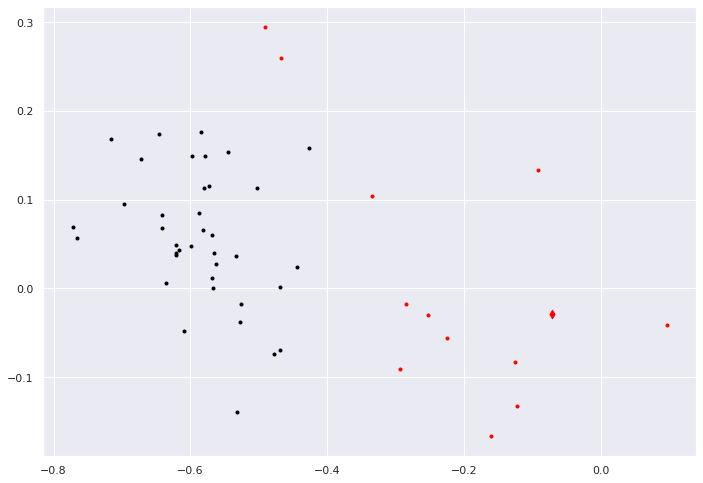

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.23085462760984732
fowlkes_mallows_score: 0.9023296511950195
homogeneity_completeness_v_measure: 0.45075358144074246 0.12010075033948937 0.18966605081342042


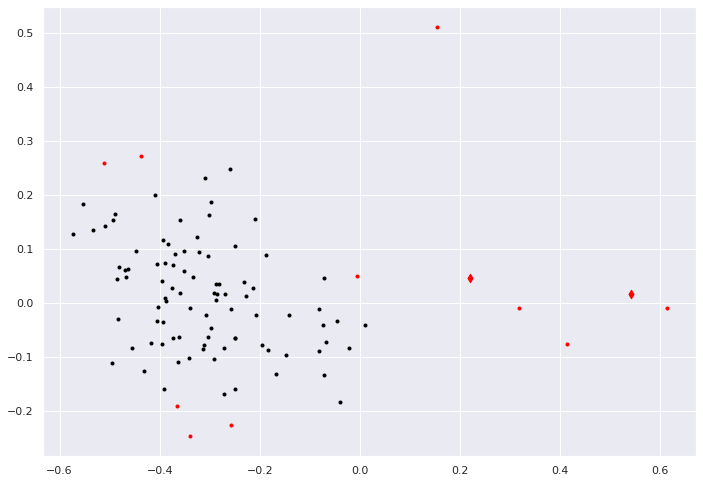

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


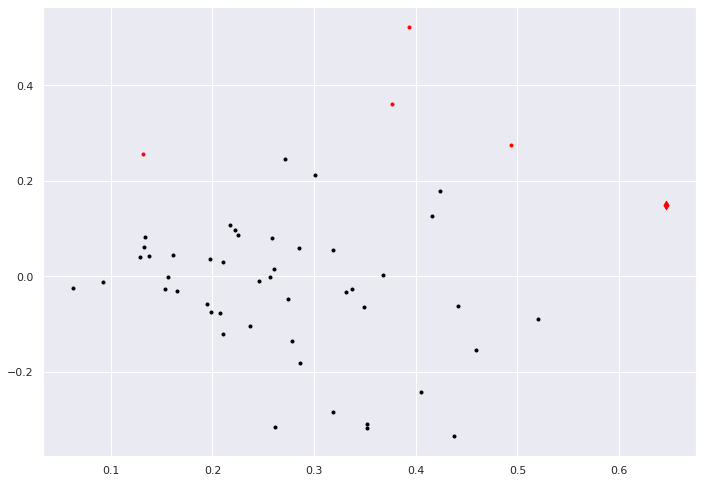

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.7758362882898279
fowlkes_mallows_score: 0.9561592502843783
homogeneity_completeness_v_measure: 0.7500512813611632 0.599452157462862 0.6663485929484374


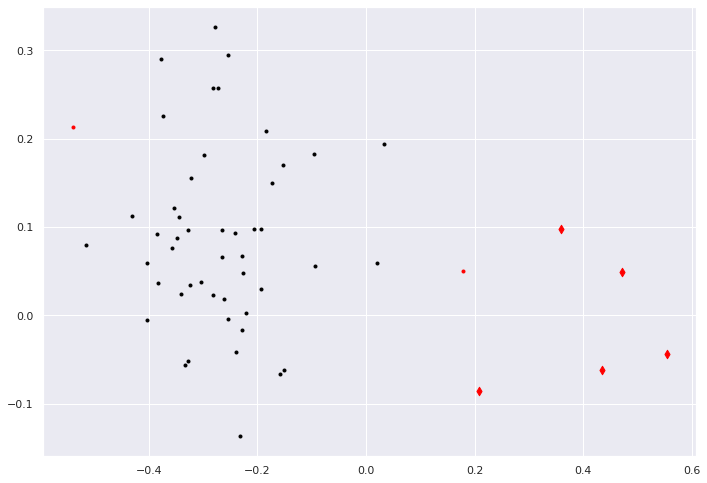

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.12030478795313197
fowlkes_mallows_score: 0.7606416458804327
homogeneity_completeness_v_measure: 0.19034390645964147 0.057844644965156046 0.088725895108623


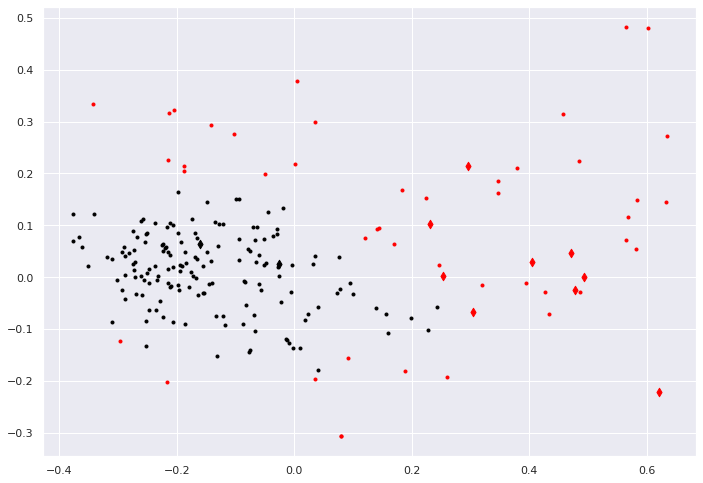

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030212541717899173
fowlkes_mallows_score: 0.9021274818888028
homogeneity_completeness_v_measure: 0.016766492616712907 0.005885742781720218 0.008712893995478197


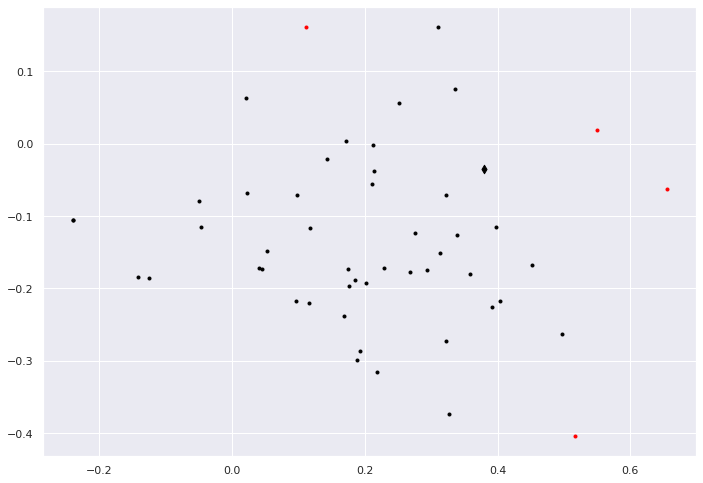

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


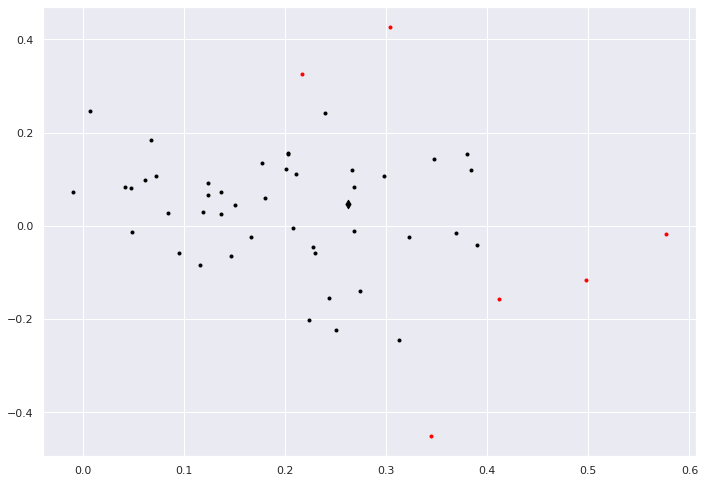

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.6198307300626161
fowlkes_mallows_score: 0.9583555915861839
homogeneity_completeness_v_measure: 0.672936898444718 0.4045313958088335 0.505303226593225


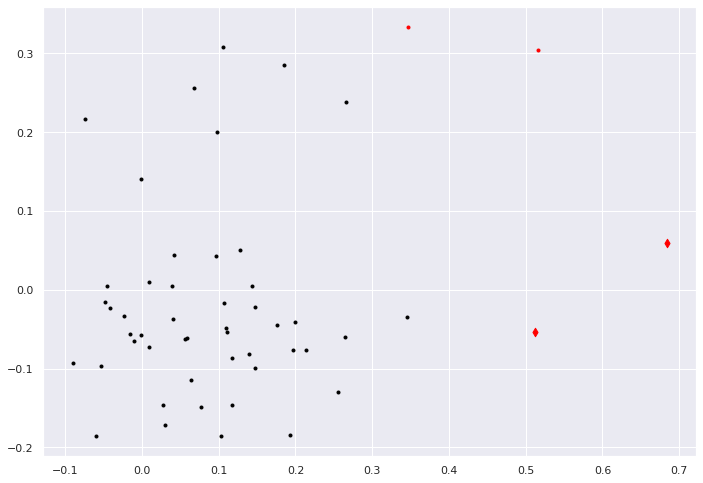

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.463618802318094
fowlkes_mallows_score: 0.9591678096644419
homogeneity_completeness_v_measure: 0.6120359227353217 0.2640240425582367 0.36890670710490103


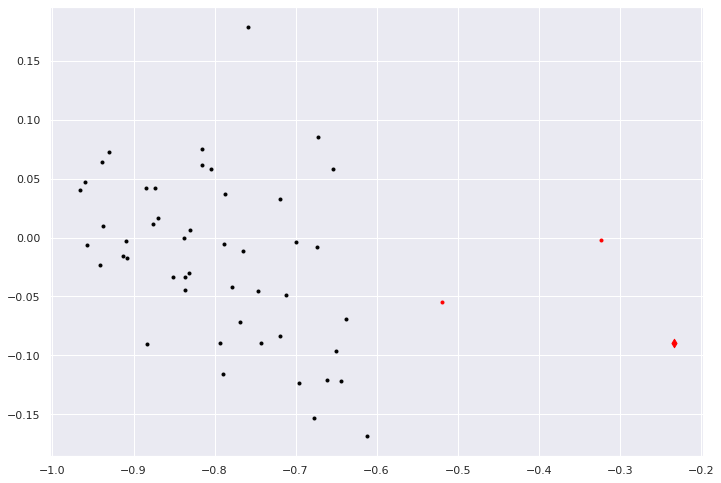

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.20866577232811118
fowlkes_mallows_score: 0.7541054108068889
homogeneity_completeness_v_measure: 0.37292762187907935 0.1057447580114732 0.16476881803965457


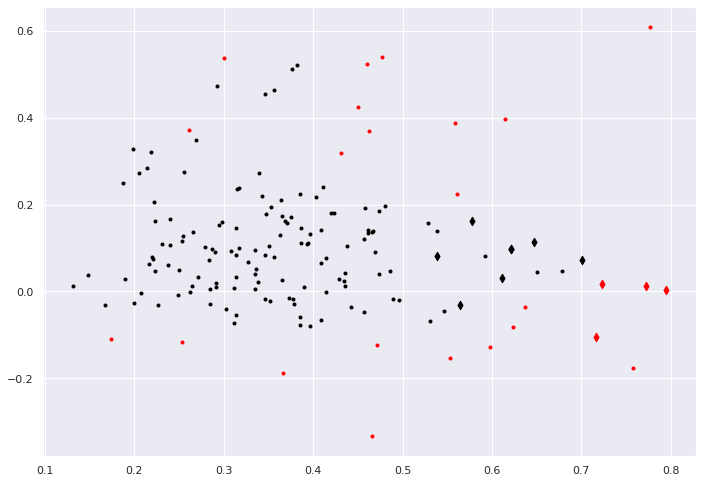

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.06035876590730342
fowlkes_mallows_score: 0.7148464014459501
homogeneity_completeness_v_measure: 0.24024851473660358 0.026186249820692068 0.04722512571808191


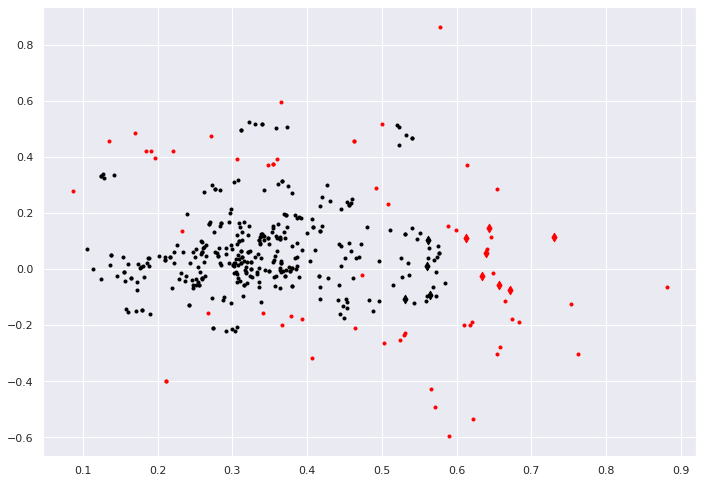

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.21004037470199277
fowlkes_mallows_score: 0.8932206327229614
homogeneity_completeness_v_measure: 0.433030470614115 0.10954123194031691 0.17485132746673832


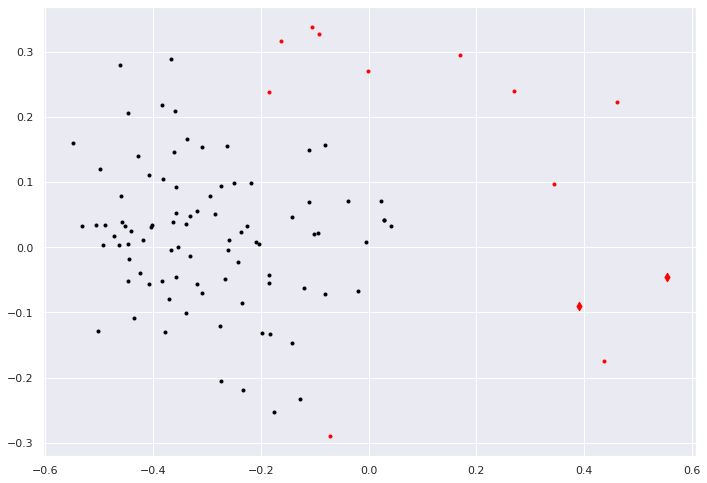

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.09077367563406612
fowlkes_mallows_score: 0.7708547611282796
homogeneity_completeness_v_measure: 0.049380025491908175 0.03627052046444513 0.041822015379838304


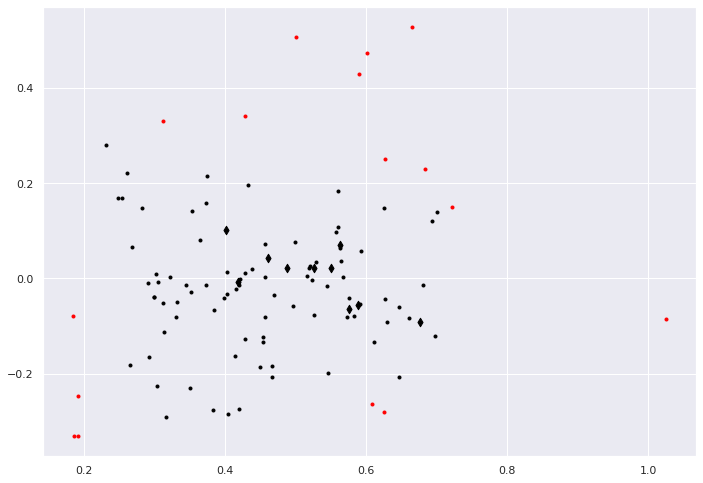

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.09331050012809967
fowlkes_mallows_score: 0.7681754789370747
homogeneity_completeness_v_measure: 0.0493800254919071 0.03627052046444439 0.04182201537983742


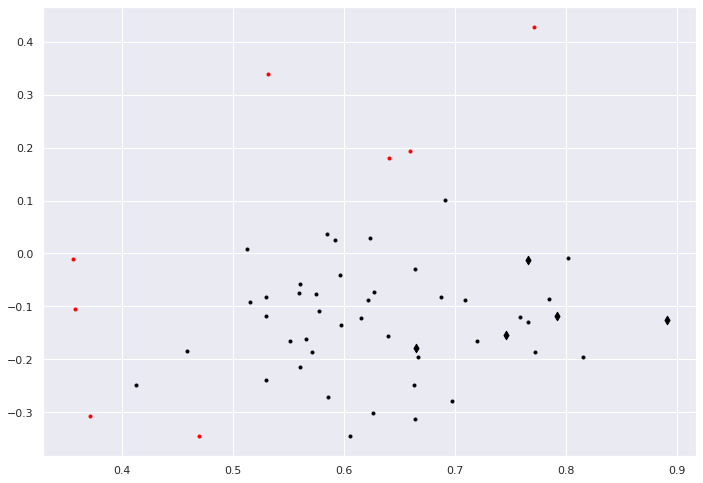

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.19123693175143897
fowlkes_mallows_score: 0.8829621891004893
homogeneity_completeness_v_measure: 0.4167331755524075 0.1005590683364424 0.16202175993746998


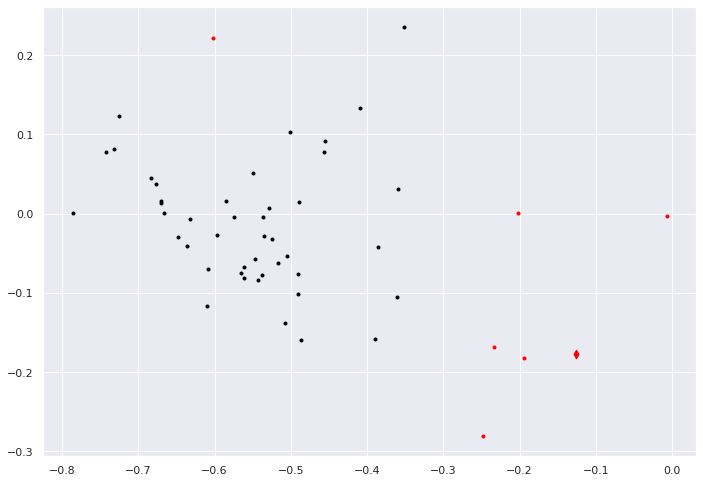

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.3464974982130093
fowlkes_mallows_score: 0.8378265945976596
homogeneity_completeness_v_measure: 0.4643192810794364 0.23145747414196582 0.30892140959742714


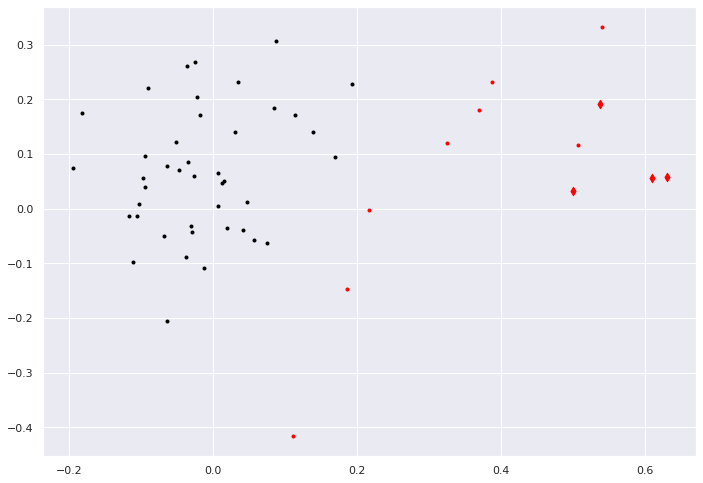

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.051559628408146825
fowlkes_mallows_score: 0.865518723145527
homogeneity_completeness_v_measure: 0.02434732630227051 0.012538942970179568 0.0165530286473585


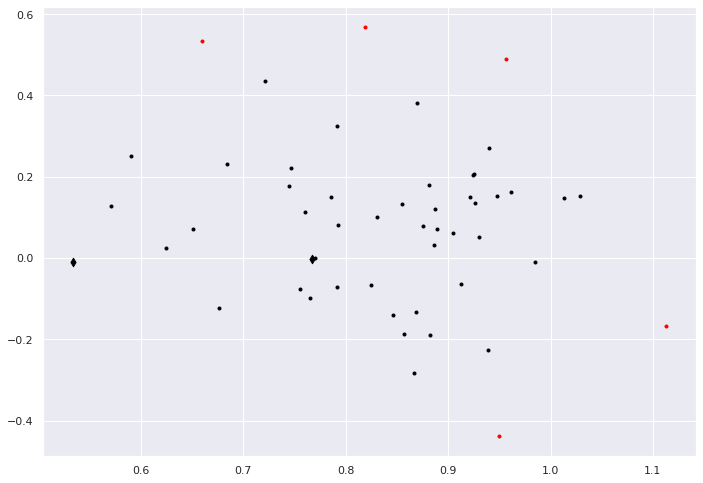

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.33245375831824775
fowlkes_mallows_score: 0.871501570154437
homogeneity_completeness_v_measure: 0.3530758520562438 0.1761827844411918 0.235068008132605


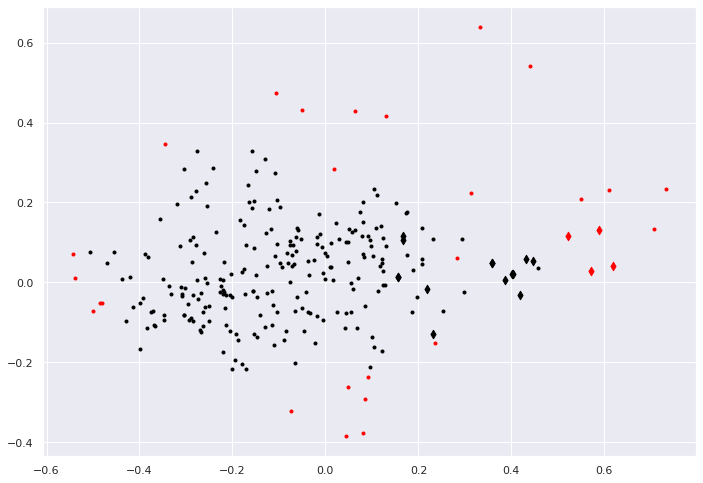

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.21881353249820434
fowlkes_mallows_score: 0.8651758418654288
homogeneity_completeness_v_measure: 0.4159648443156446 0.12228901611102179 0.18901093067056585


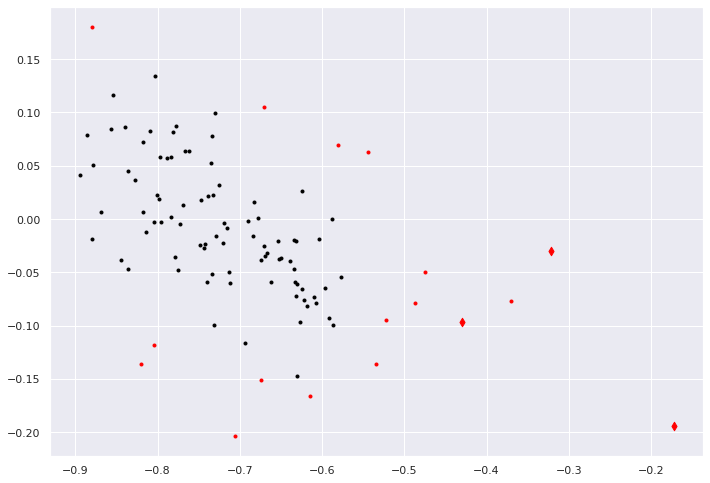

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.17648187224247075
fowlkes_mallows_score: 0.8239640807781841
homogeneity_completeness_v_measure: 0.09184092010490771 0.05382350481585838 0.06787107021152503


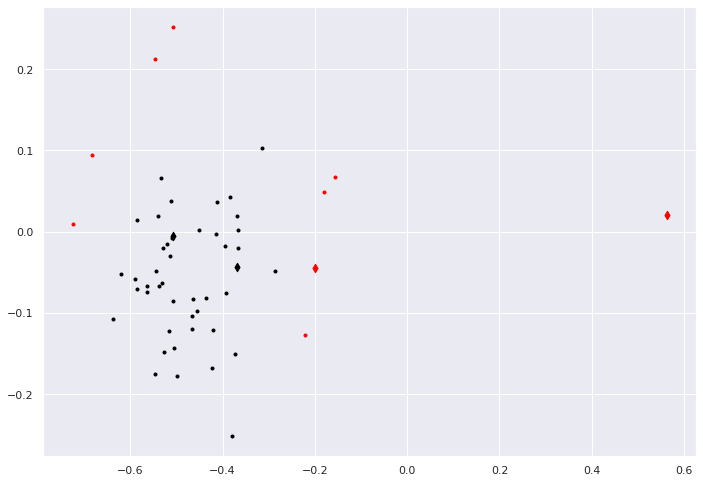

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.10147293844297103
fowlkes_mallows_score: 0.7662467979707233
homogeneity_completeness_v_measure: 0.3539805580445058 0.0641805417130903 0.10865986331281496


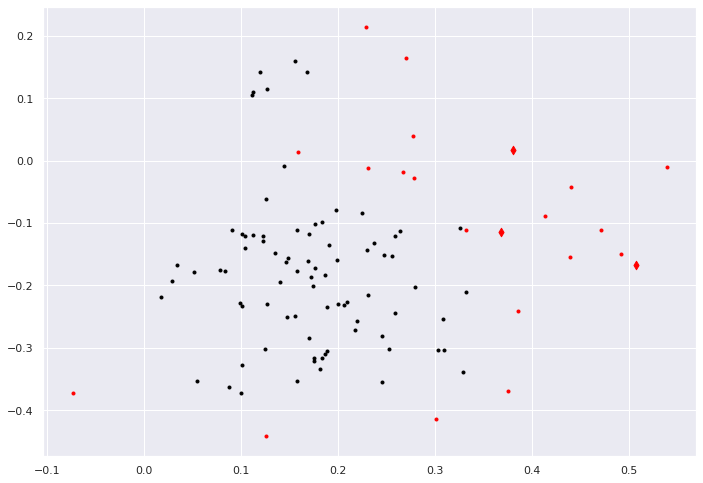

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.04341474815940166
fowlkes_mallows_score: 0.6899481053388836
homogeneity_completeness_v_measure: 0.3395249622165197 0.03674666757916904 0.06631597991150663


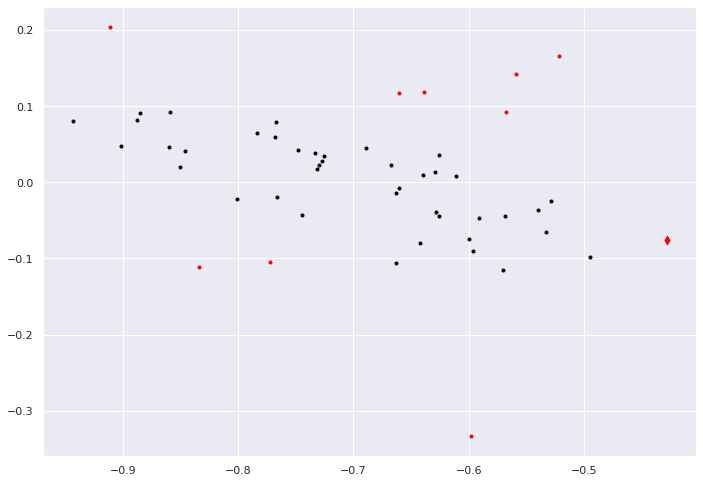

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: -0.04457289915248886
fowlkes_mallows_score: 0.6036144856394527
homogeneity_completeness_v_measure: 0.121316553102202 0.01836274053151822 0.031897417703665894


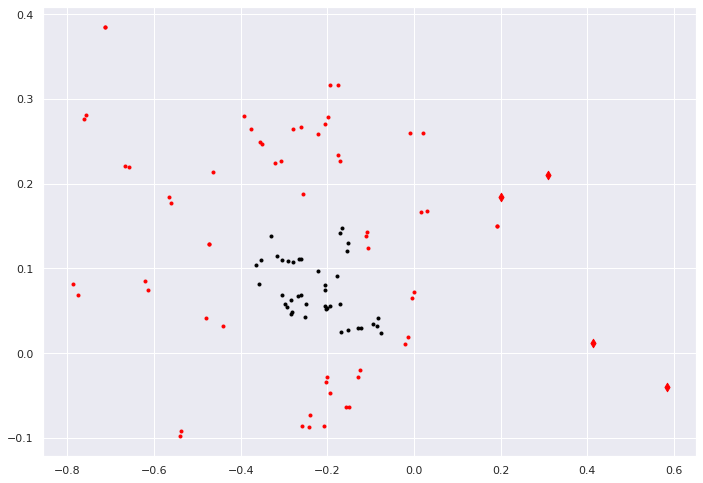

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


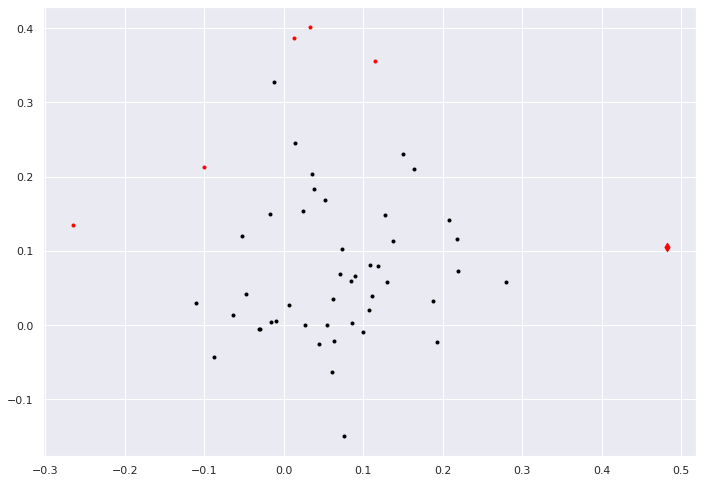

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.6980018048214516
fowlkes_mallows_score: 0.9575823054437779
homogeneity_completeness_v_measure: 0.7081092142671571 0.49294165155975356 0.5812518611777698


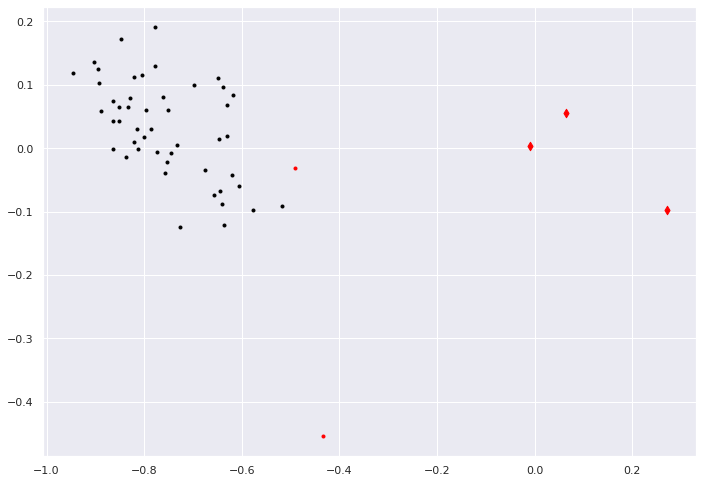

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.03880614491754914
fowlkes_mallows_score: 0.7634216296176312
homogeneity_completeness_v_measure: 0.014069182266475404 0.0056985016646193725 0.00811154800378309


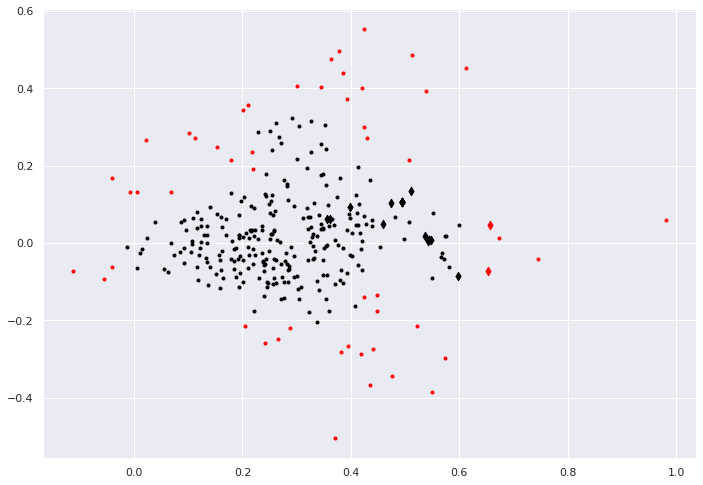

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.513545721776436
fowlkes_mallows_score: 0.9320662360091536
homogeneity_completeness_v_measure: 0.597489531419879 0.31756656014498963 0.4147127087939871


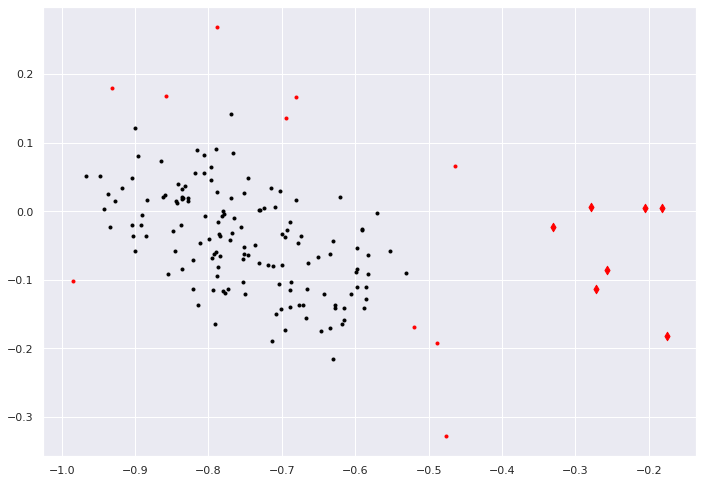

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


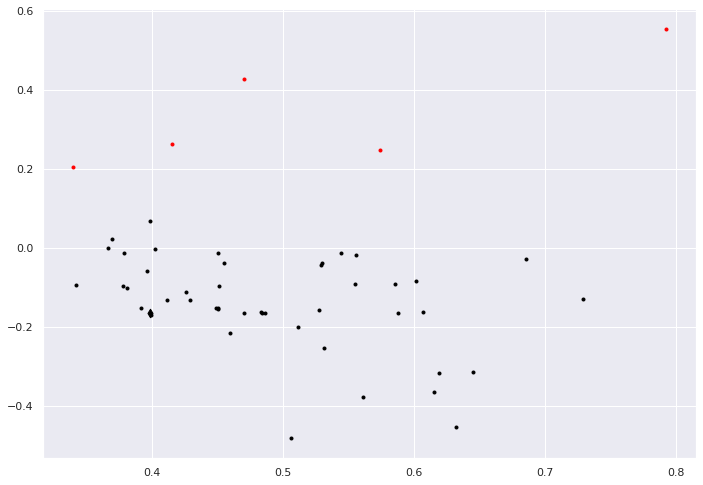

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.028976175144880875
fowlkes_mallows_score: 0.9209370289426528
homogeneity_completeness_v_measure: 0.012443374527241603 0.005367903947640151 0.007500285770158736


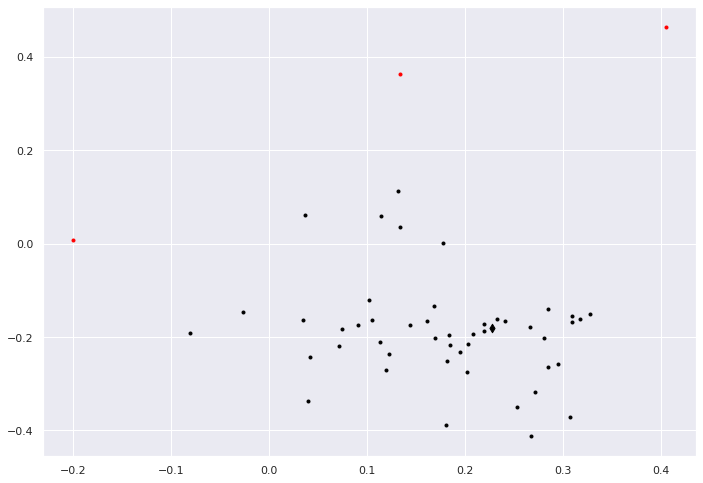

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


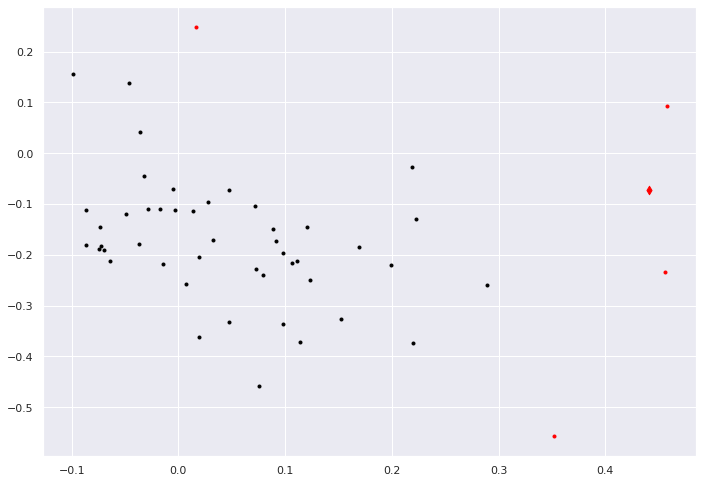

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.07745768770699296
fowlkes_mallows_score: 0.7762668540901534
homogeneity_completeness_v_measure: 0.33952496221651385 0.04645485527826991 0.0817275011191038


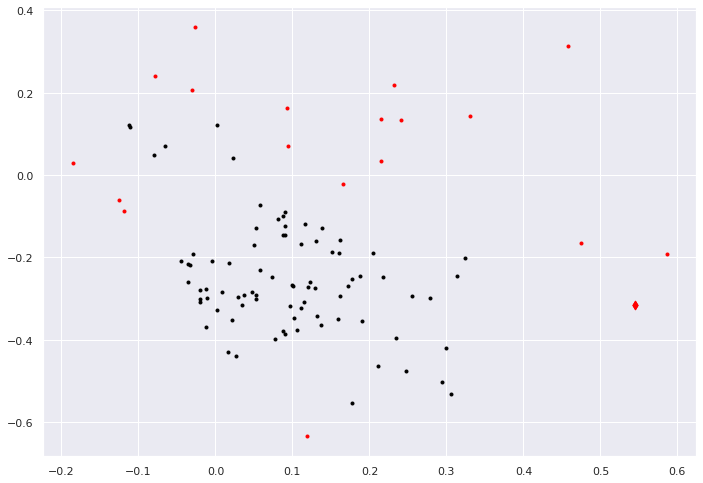

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.2345176507335824
fowlkes_mallows_score: 0.8515387435185459
homogeneity_completeness_v_measure: 0.5153701066603746 0.12253812347894807 0.19799865492726051


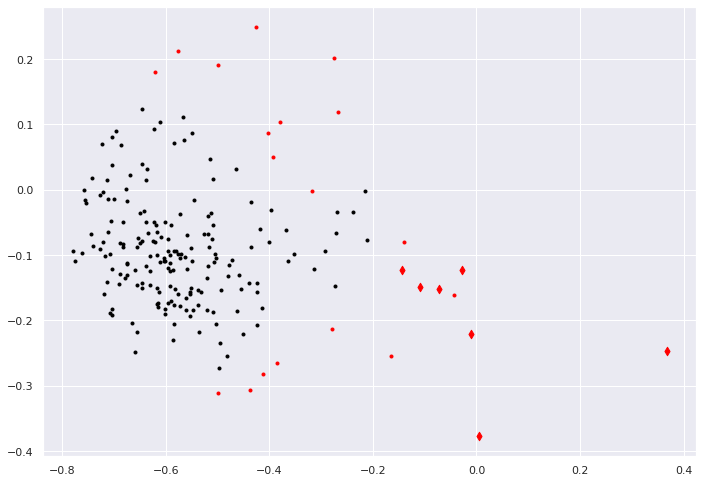

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.1711266028663021
fowlkes_mallows_score: 0.8534585243201244
homogeneity_completeness_v_measure: 0.14425068536672273 0.045588645935186814 0.06928167494051227


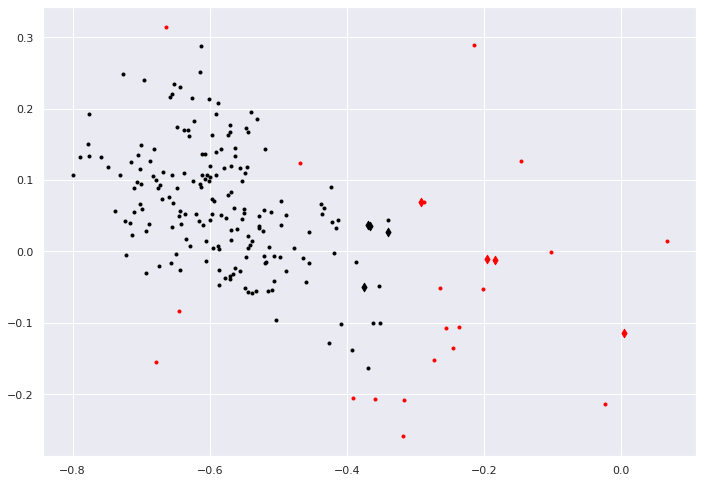

In [21]:
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
  if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df1[['comp-1','comp-2']])
    distances, indices = nbrs.kneighbors(df1[['comp-1','comp-2']])
    distances = np.sort(distances[:,1], axis=0)
    values.append({'eps':np.round(np.quantile(distances,0.95),5)})
print(len(values))
clustering_function(familyes,df_data, df, DBSCAN, params = values)

In [22]:

# from sklearn.cluster import KMeans

# # params for dbscan
# values = []
# familyes = sorted(set(family_lables))
# print(familyes)
# for i in familyes:    
#   df1= df.query('y==@i')
#   df_data1 = df_data.query('family_lable==@i')
#   true_labels = df_data1.is_RE.tolist()
# # print(len(familyes))
#   values.append({'n_clusters':2})
# clustering_function(familyes,df_data, df, KMeans, params=values)

# IsolationForest

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

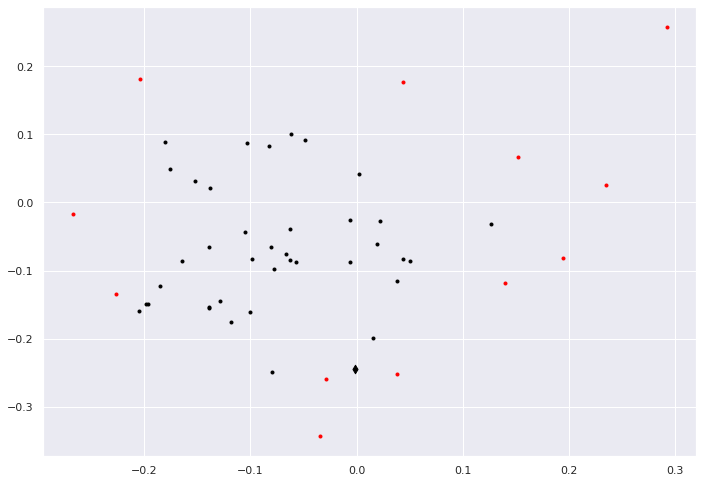

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.038901601830663615
fowlkes_mallows_score: 0.7369918385607233
homogeneity_completeness_v_measure: 0.22729774050744764 0.03446312714887227 0.05985150493957278


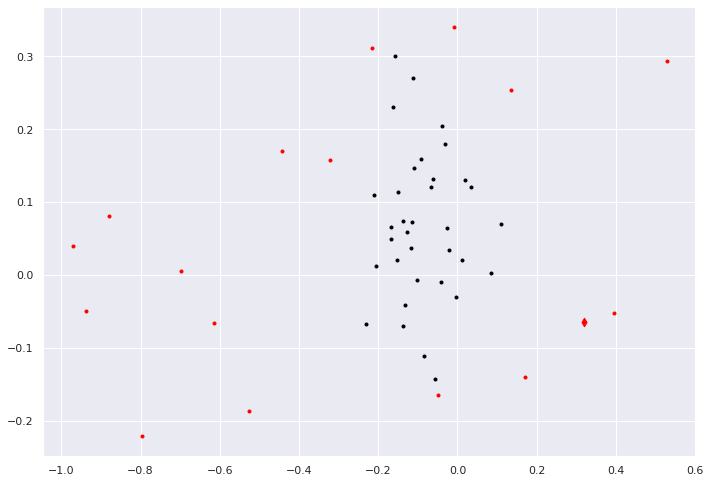

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: 0.11649862511457379
fowlkes_mallows_score: 0.8315678045512104
homogeneity_completeness_v_measure: 0.33952496221652345 0.06620737684281167 0.11080732274448242


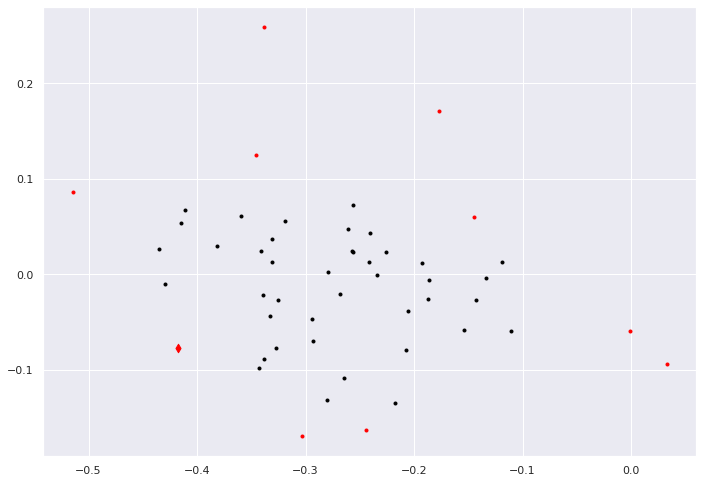

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.07002985376714062
fowlkes_mallows_score: 0.6918158265428814
homogeneity_completeness_v_measure: 0.09553855615168563 0.04269693296194009 0.059018177653874106


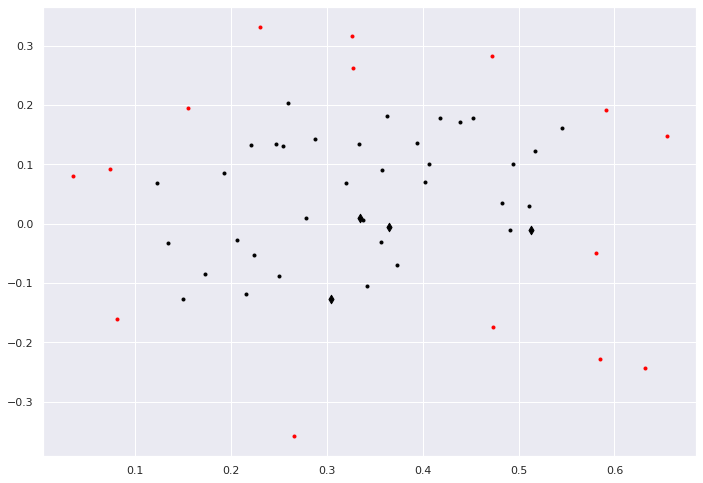

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.08011448916192537
fowlkes_mallows_score: 0.8021309786996907
homogeneity_completeness_v_measure: 0.13679199290838914 0.030743757619945508 0.050204208487591565


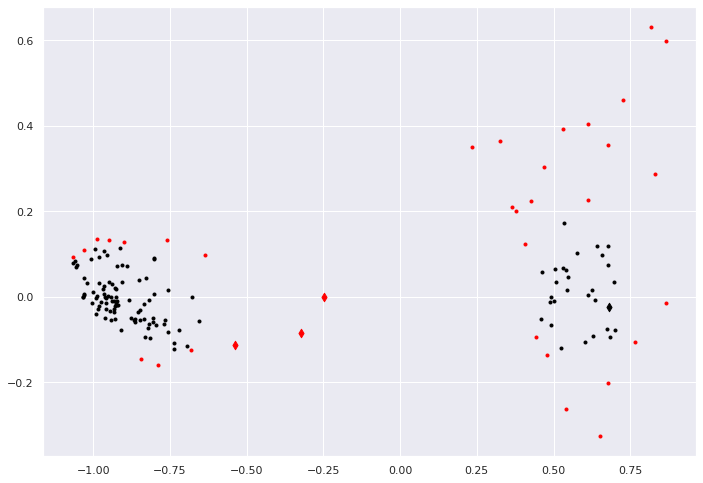

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.06328078524687686
fowlkes_mallows_score: 0.7726039985050023
homogeneity_completeness_v_measure: 0.2680836160455999 0.04402378816165864 0.07562817263101922


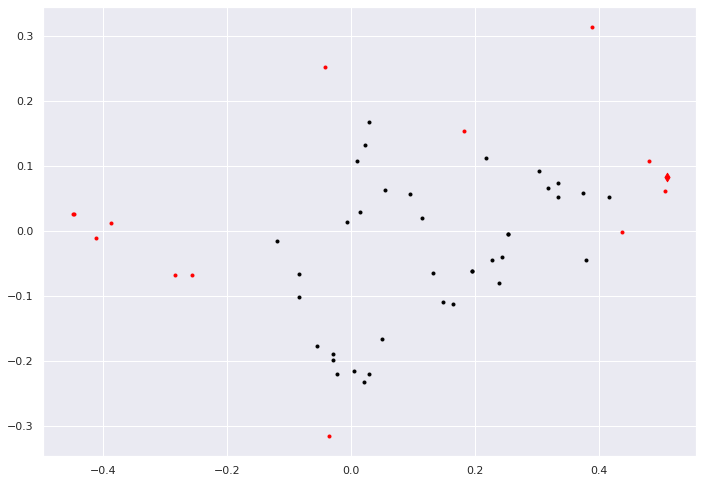

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.0485694619421152
fowlkes_mallows_score: 0.7117554810420404
homogeneity_completeness_v_measure: 0.0147247046570002 0.009264274024786584 0.011373030981103895


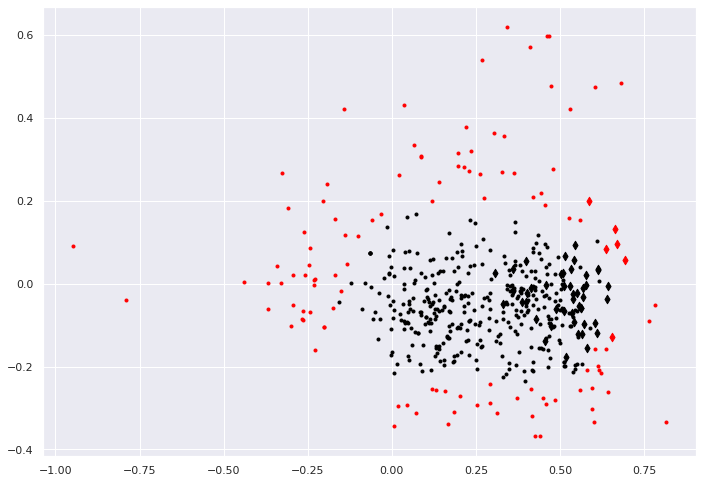

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.09696150419367723
fowlkes_mallows_score: 0.7529416662666737
homogeneity_completeness_v_measure: 0.28888050924787845 0.07629805923268018 0.12071366782267709


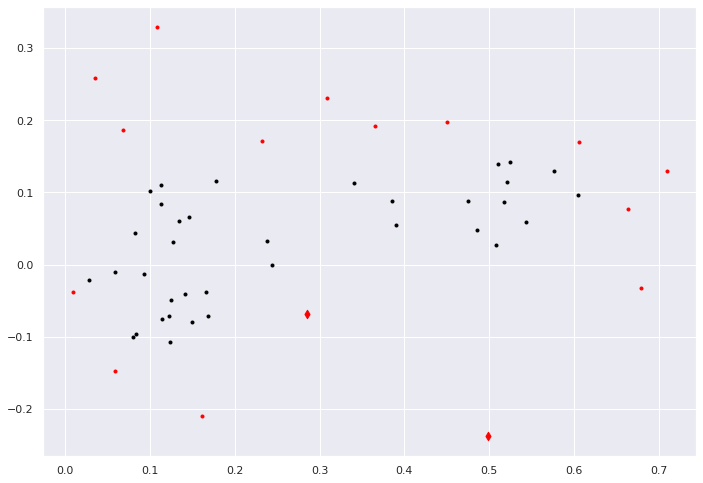

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.02372875628652473
fowlkes_mallows_score: 0.8012931037831442
homogeneity_completeness_v_measure: 0.010420898032865838 0.0027135415173292344 0.004305861601778969


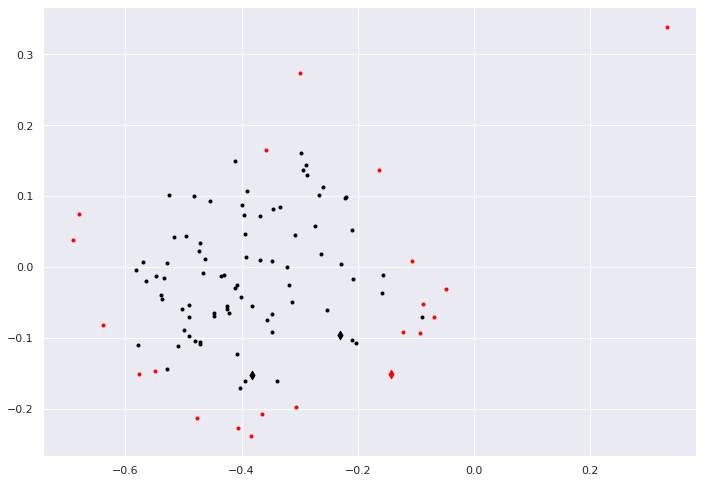

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


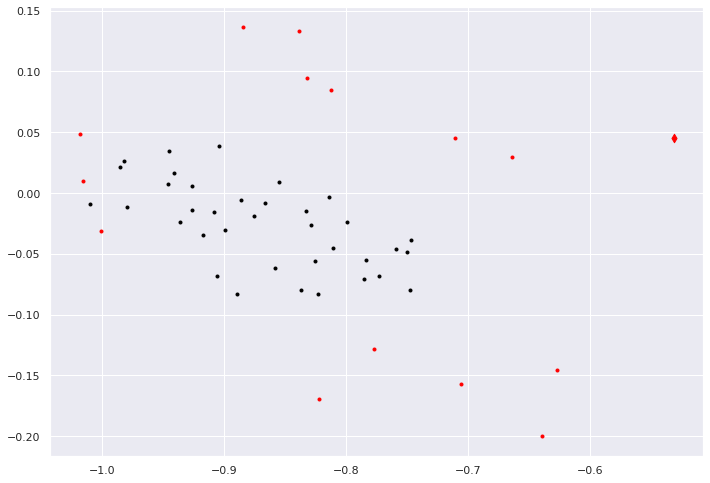

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.12232434658418835
fowlkes_mallows_score: 0.742149941825401
homogeneity_completeness_v_measure: 0.13418078695422542 0.058303596384423735 0.0812868276317217


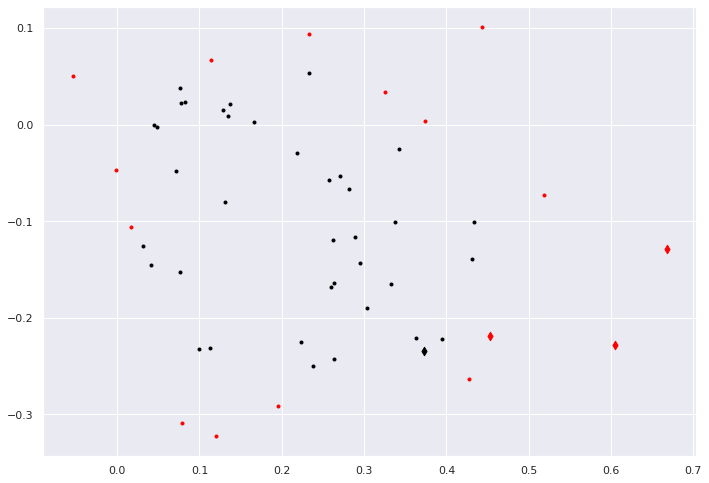

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.018520780057736278
fowlkes_mallows_score: 0.7629906142177129
homogeneity_completeness_v_measure: 0.023619202597489817 0.0038786658693917143 0.0066631342780236425


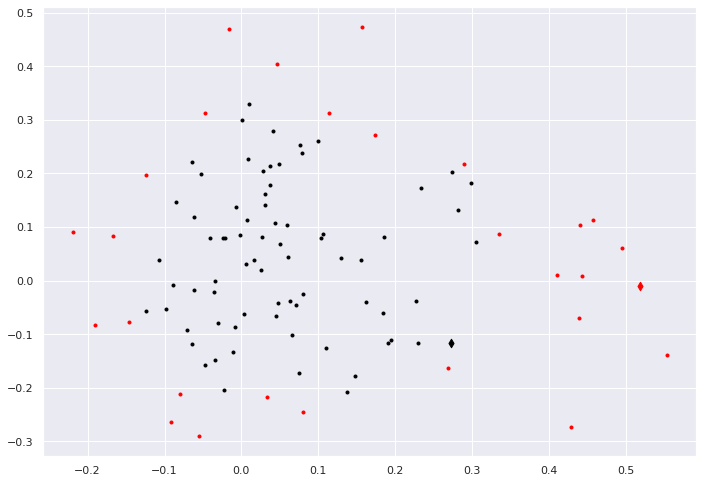

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.15400571678113462
fowlkes_mallows_score: 0.7367952276194722
homogeneity_completeness_v_measure: 0.1704308439904673 0.0839615016960934 0.11250047290654952


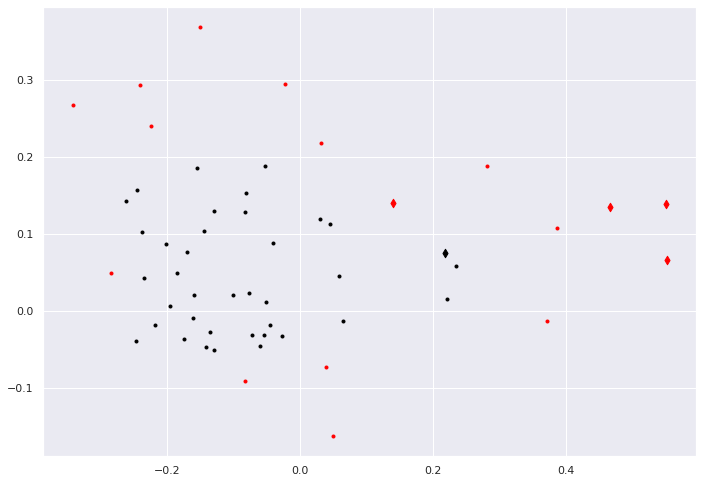

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.024530135482021907
fowlkes_mallows_score: 0.8445387262657297
homogeneity_completeness_v_measure: 0.0076364300965323815 0.002181915062372988 0.0033940631706697987


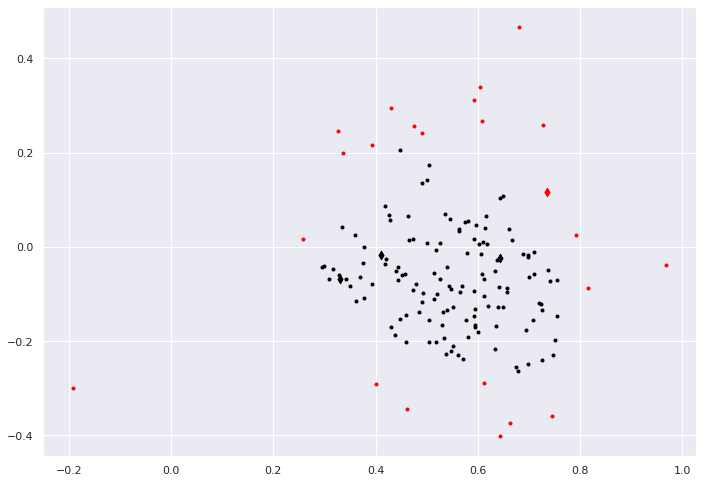

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


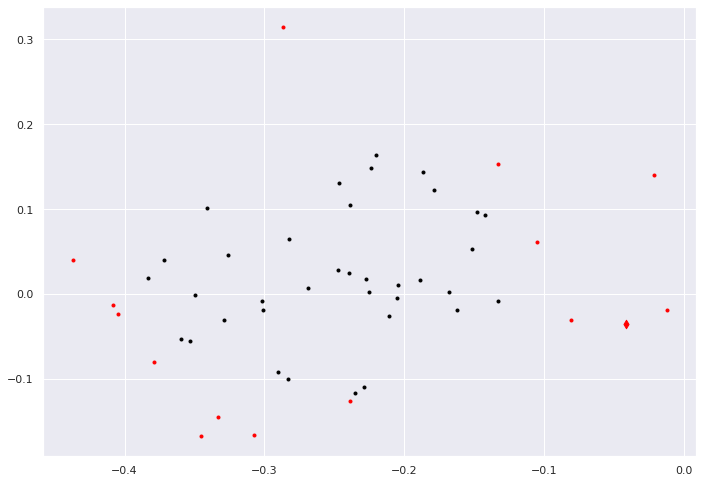

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.04606858330446831
fowlkes_mallows_score: 0.7479575920067657
homogeneity_completeness_v_measure: 0.24000422165857632 0.03723589815953225 0.06446954907824871


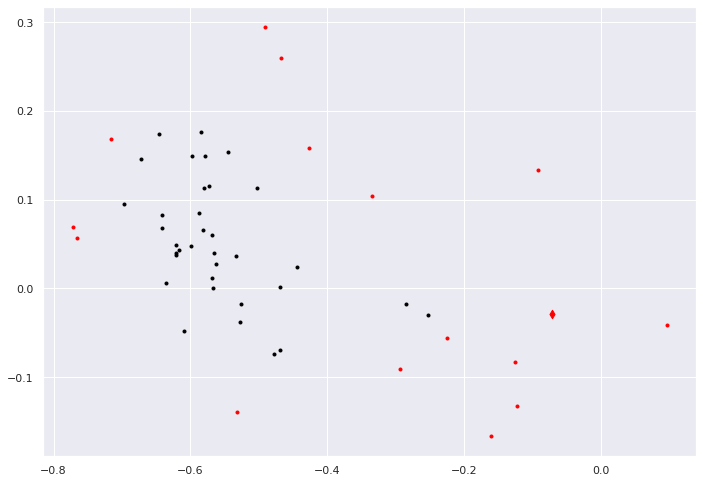

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.11715560472645163
fowlkes_mallows_score: 0.83347567801242
homogeneity_completeness_v_measure: 0.33952496221652106 0.06620737684281065 0.11080732274448088


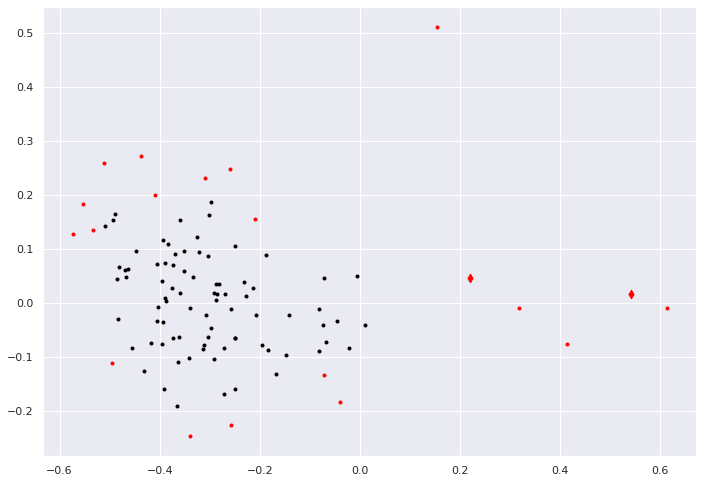

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.05413533834586466
fowlkes_mallows_score: 0.759842446970217
homogeneity_completeness_v_measure: 0.253559020576412 0.04039422015840193 0.06968672211069328


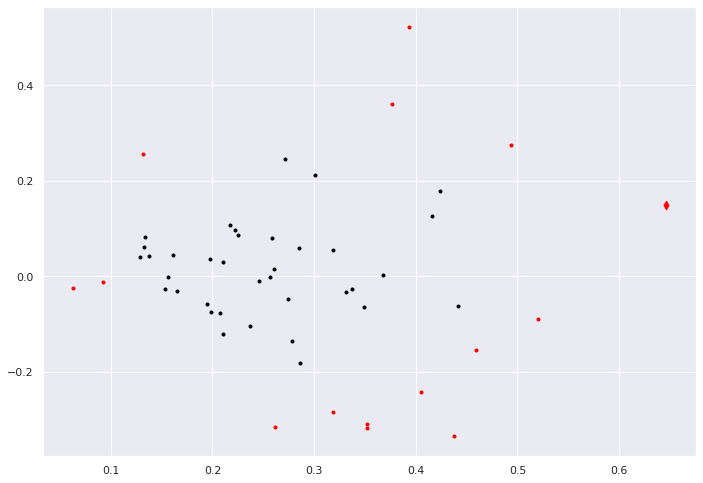

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.38578311662596526
fowlkes_mallows_score: 0.8348210990982834
homogeneity_completeness_v_measure: 0.48304223678623703 0.2690894500871971 0.3456351384583295


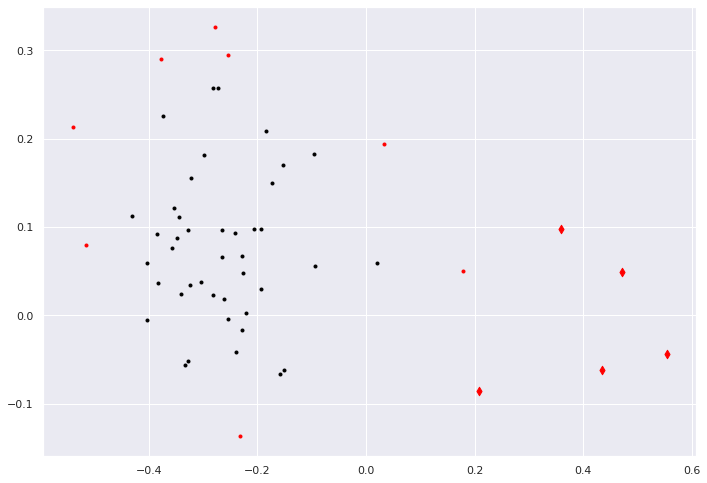

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.10467955646291181
fowlkes_mallows_score: 0.7670349562829245
homogeneity_completeness_v_measure: 0.12260942234453025 0.04303047119608267 0.06370375039236603


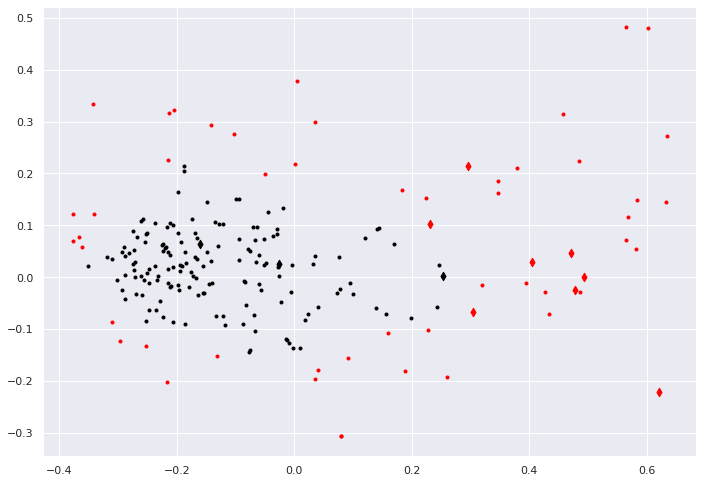

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.023944080904223678
fowlkes_mallows_score: 0.7487197351103584
homogeneity_completeness_v_measure: 0.06596482136672123 0.010832520706808981 0.01860911521369573


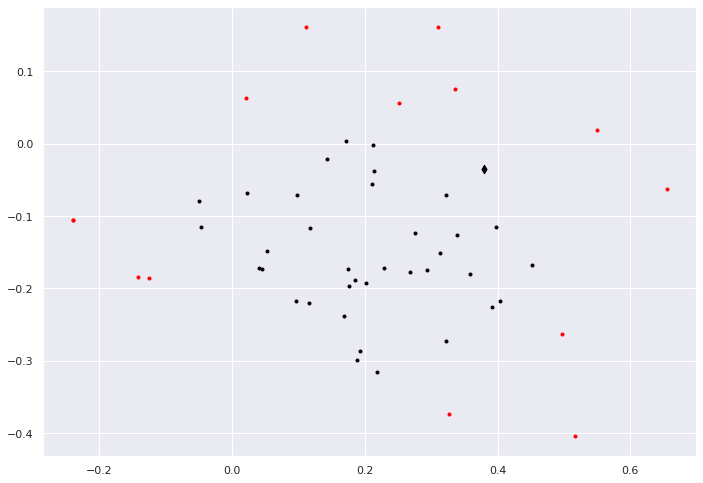

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.02841429880843263
fowlkes_mallows_score: 0.8014526153676969
homogeneity_completeness_v_measure: 0.04483591126959422 0.008743003913873719 0.014632642201502092


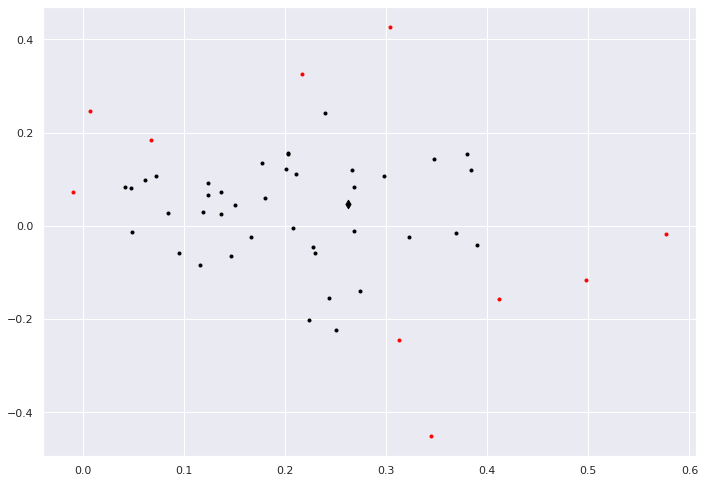

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.09696150419367723
fowlkes_mallows_score: 0.7529416662666737
homogeneity_completeness_v_measure: 0.28888050924787845 0.07629805923268018 0.12071366782267709


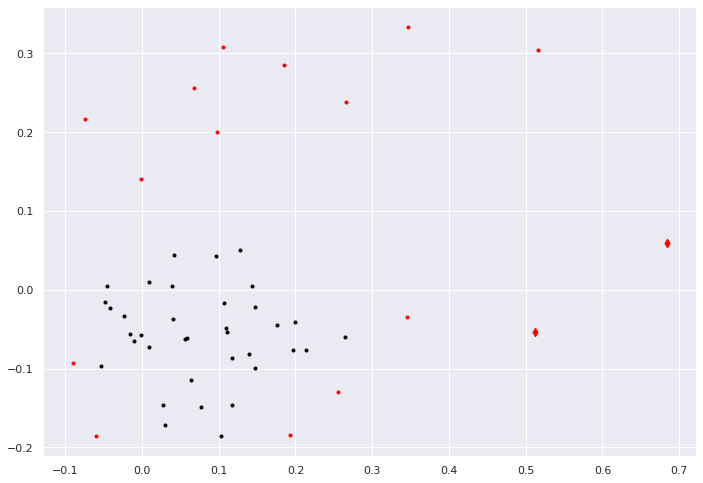

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.16080777860882572
fowlkes_mallows_score: 0.8652250534546901
homogeneity_completeness_v_measure: 0.38760917830812613 0.08610752365469332 0.14091150407680916


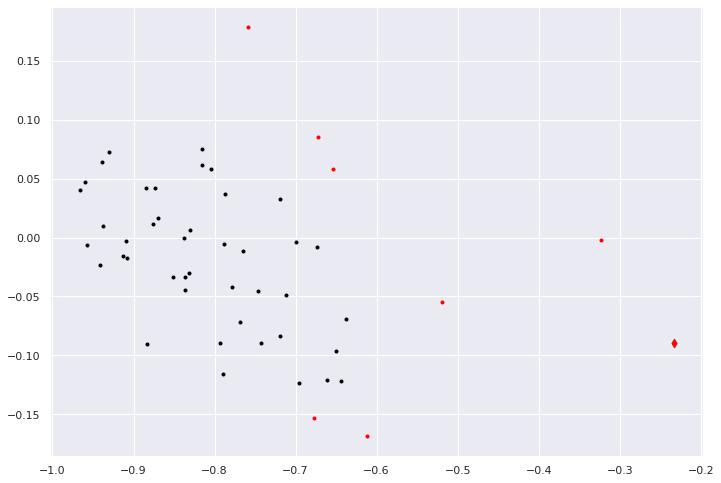

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.12957391040867222
fowlkes_mallows_score: 0.7768651603158792
homogeneity_completeness_v_measure: 0.08582071038627097 0.041600127175484246 0.056037184100739885


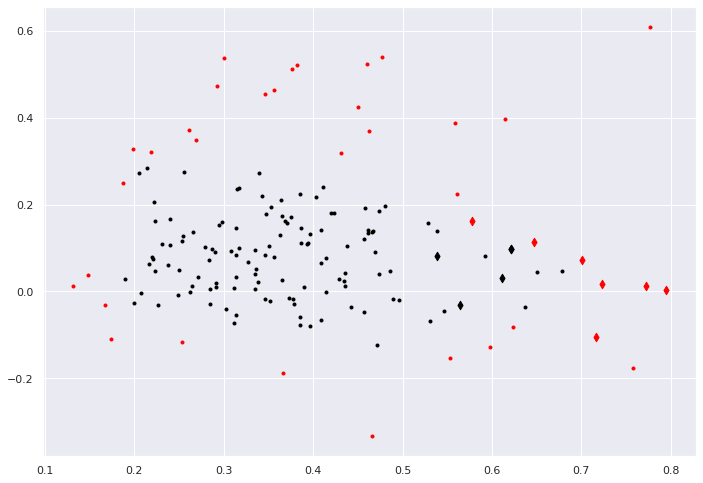

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.059824871427601956
fowlkes_mallows_score: 0.8105453535026784
homogeneity_completeness_v_measure: 0.06199726685313837 0.014998328368726154 0.02415346913151361


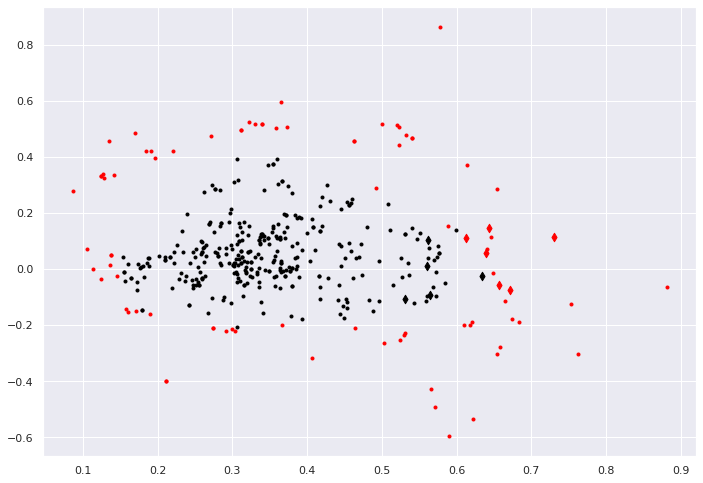

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.09323581951215423
fowlkes_mallows_score: 0.8102715038515051
homogeneity_completeness_v_measure: 0.30971548344854555 0.05599856224099336 0.09484799384279614


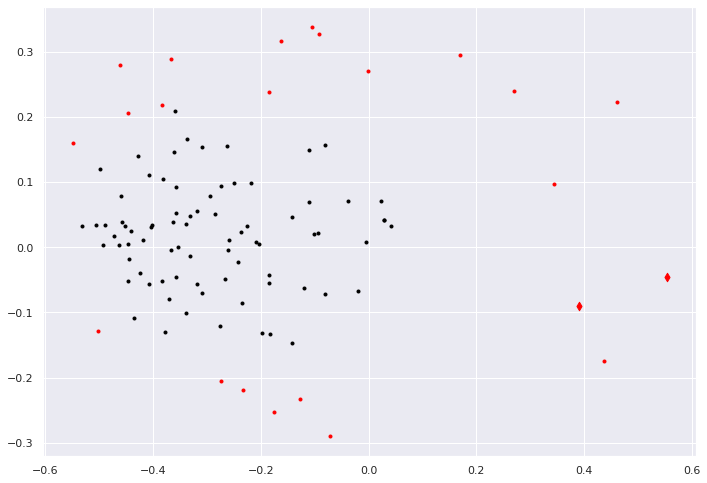

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.06688286857277327
fowlkes_mallows_score: 0.6664721165808852
homogeneity_completeness_v_measure: 0.11689955758020781 0.05758970719286092 0.07716476197862031


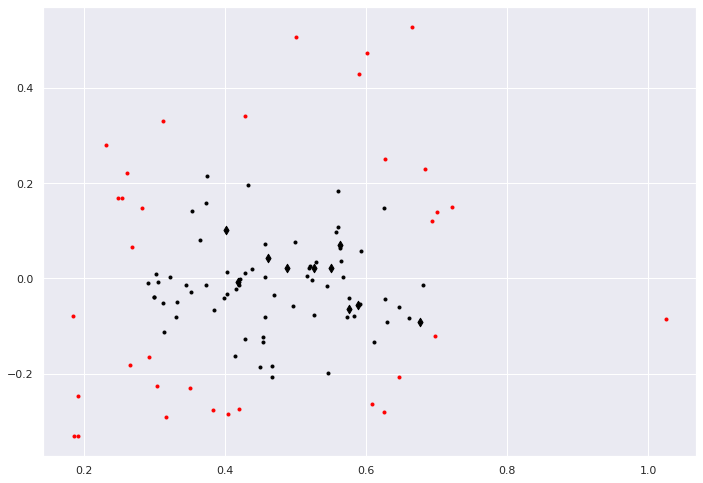

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.024203536043730784
fowlkes_mallows_score: 0.7070800697773397
homogeneity_completeness_v_measure: 0.0026982932588702903 0.0014490309530108968 0.001885509910801112


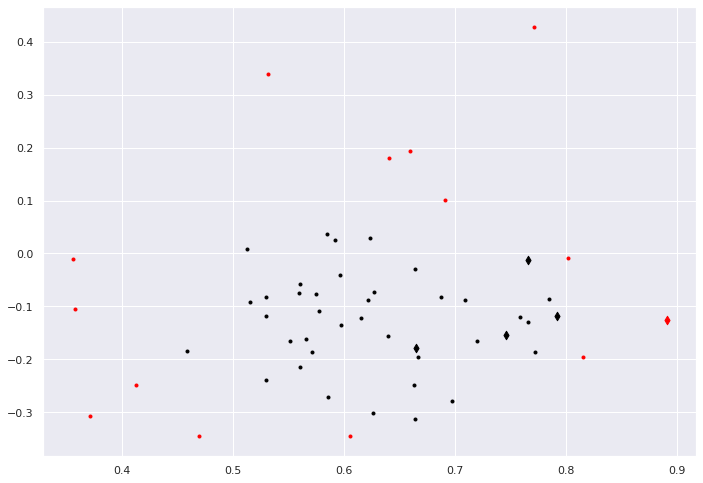

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


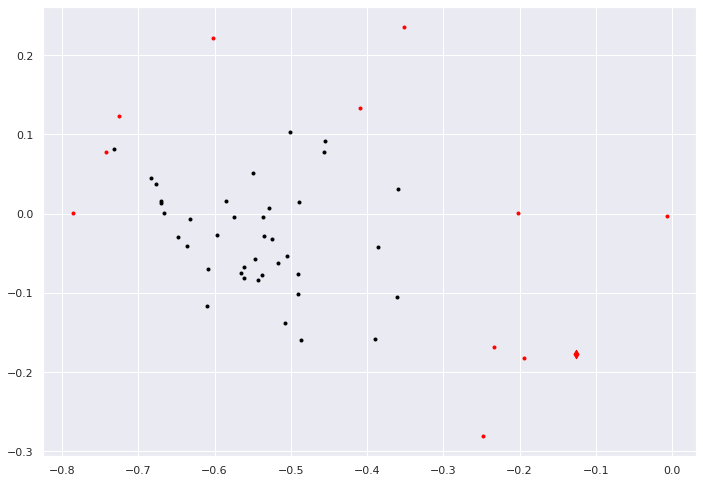

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.23891109649344736
fowlkes_mallows_score: 0.7858871004070691
homogeneity_completeness_v_measure: 0.38994017845195134 0.1742673359234786 0.24088242122606737


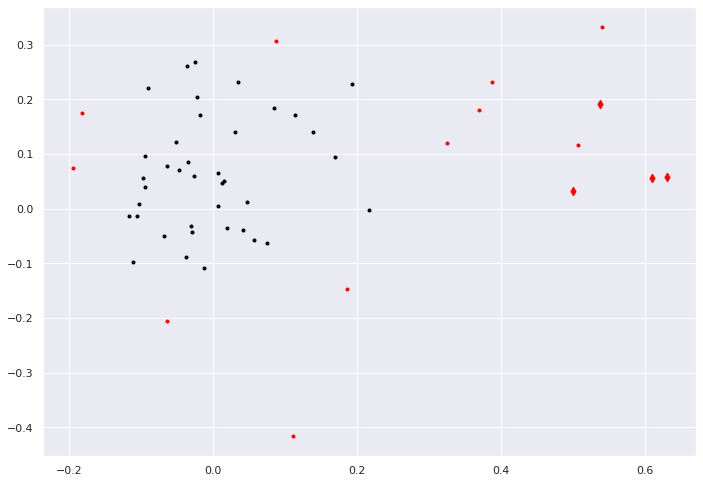

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.03581035274564262
fowlkes_mallows_score: 0.754080046578137
homogeneity_completeness_v_measure: 0.029544615604291842 0.008268728928824626 0.012921174826218271


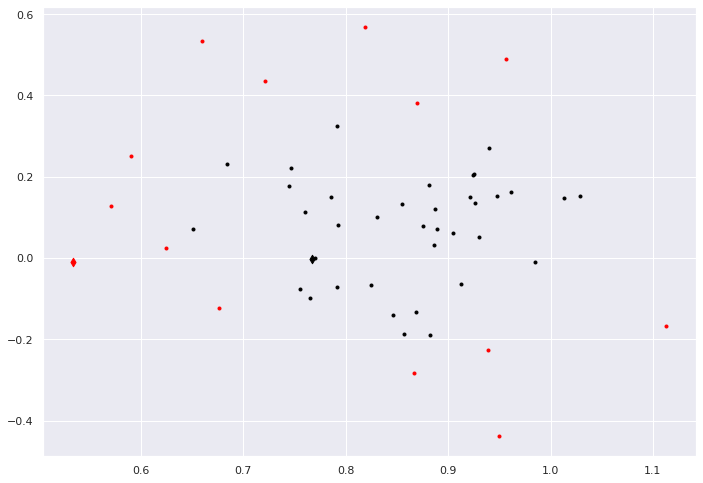

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.1554693103014743
fowlkes_mallows_score: 0.8106596751105505
homogeneity_completeness_v_measure: 0.0957563278548769 0.047923724895612245 0.06387803769950313


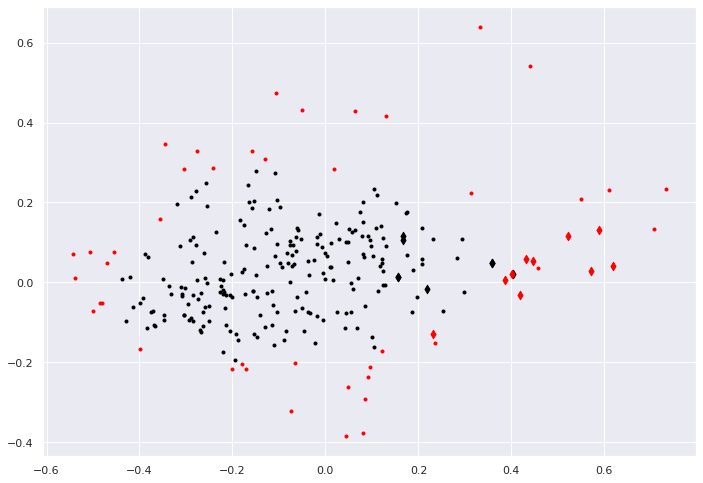

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.13982255840243377
fowlkes_mallows_score: 0.8155136700473498
homogeneity_completeness_v_measure: 0.3434286784196761 0.0851639111693037 0.13648266522747501


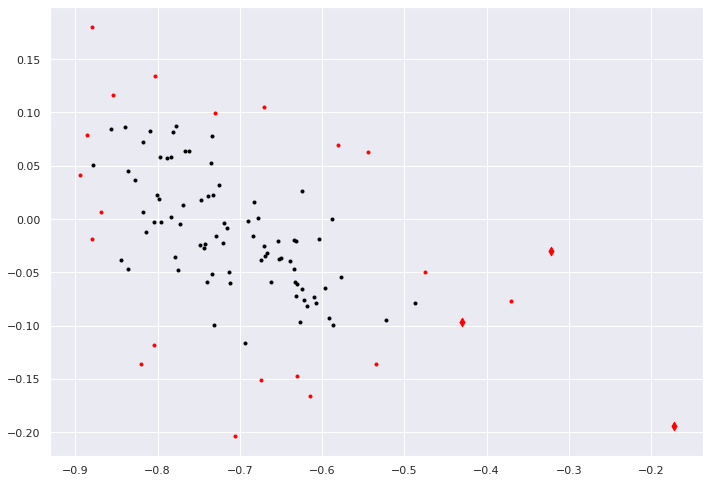

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.0055396711937097925
fowlkes_mallows_score: 0.7479591609871843
homogeneity_completeness_v_measure: 0.0006589679323071564 0.0003284874425153895 0.00043842526214844357


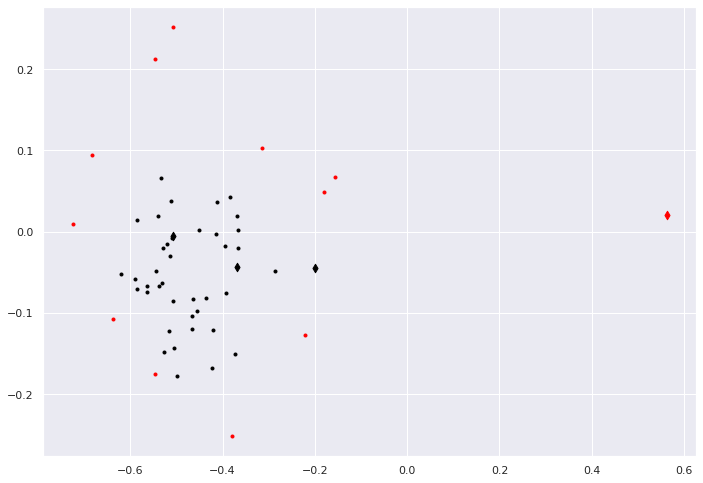

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.04583747865064278
fowlkes_mallows_score: 0.7596463814926964
homogeneity_completeness_v_measure: 0.07293176830876605 0.016157914496346654 0.02645480911584924


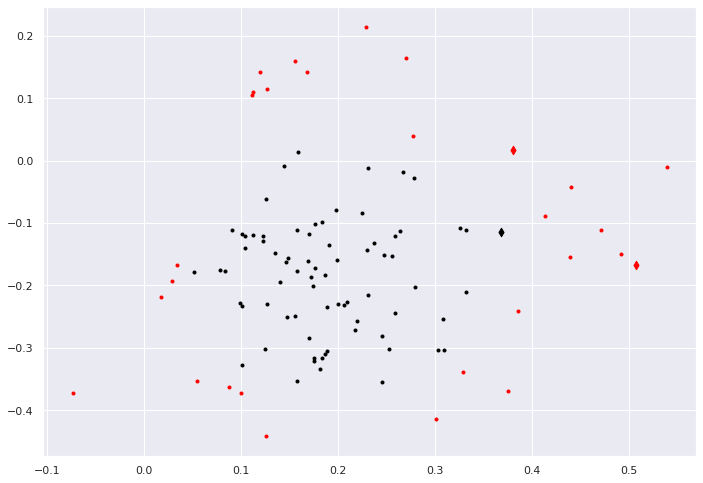

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.11649862511457379
fowlkes_mallows_score: 0.8315678045512104
homogeneity_completeness_v_measure: 0.33952496221652345 0.06620737684281167 0.11080732274448242


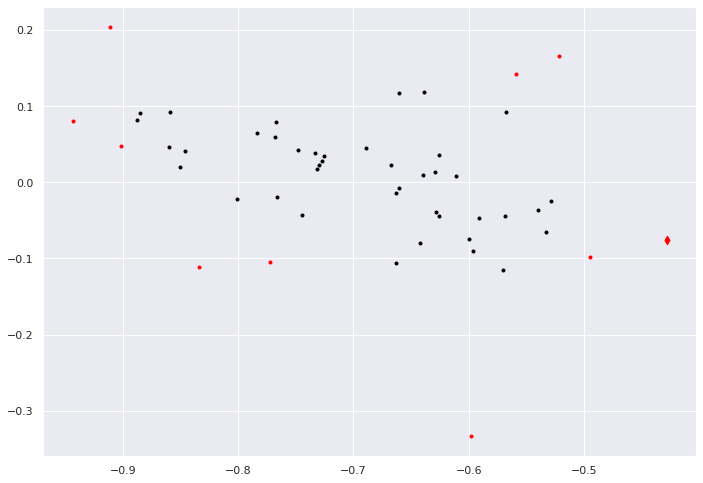

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.10580128146444269
fowlkes_mallows_score: 0.7624102503476757
homogeneity_completeness_v_measure: 0.2968910662370311 0.07944548305504825 0.12534872956824278


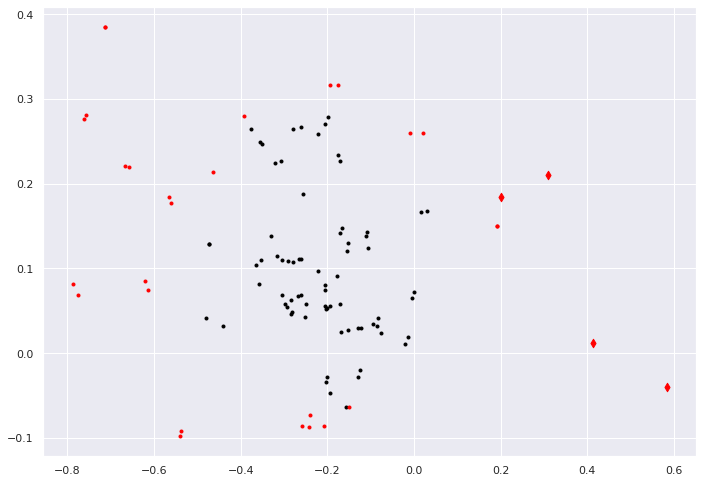

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.11649862511457379
fowlkes_mallows_score: 0.8315678045512104
homogeneity_completeness_v_measure: 0.33952496221652345 0.06620737684281167 0.11080732274448242


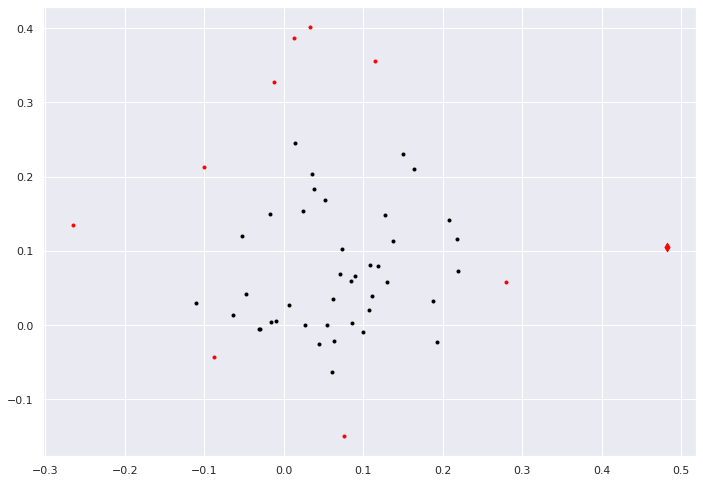

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.3866739900376901
fowlkes_mallows_score: 0.8778536245155478
homogeneity_completeness_v_measure: 0.5030892721804947 0.2401984273146218 0.3251533748202609


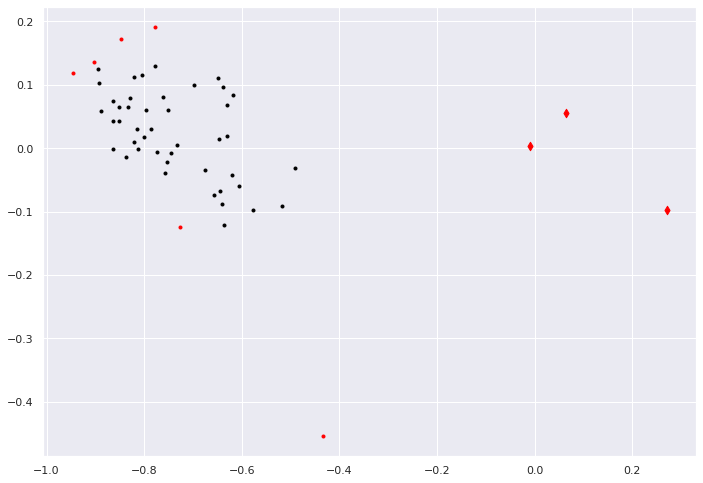

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.002600726022652933
fowlkes_mallows_score: 0.8156765221288063
homogeneity_completeness_v_measure: 4.4750114144814535e-05 2.5411408249101325e-05 3.241558566369923e-05


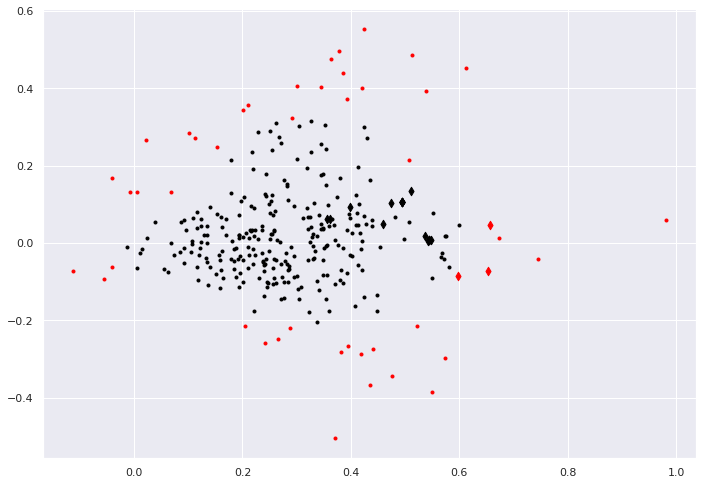

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.3388125619064266
fowlkes_mallows_score: 0.8812978148751368
homogeneity_completeness_v_measure: 0.48193642528585223 0.20035341199468845 0.2830398516718391


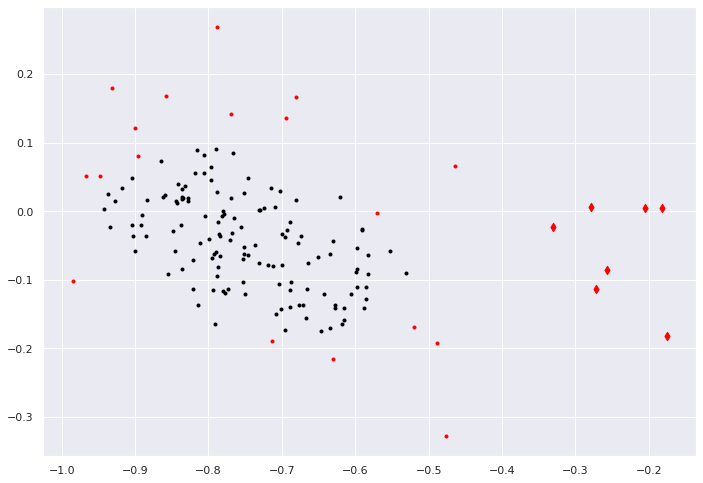

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.025225085377212048
fowlkes_mallows_score: 0.7606403751737113
homogeneity_completeness_v_measure: 0.06047303865436228 0.010281196615568478 0.017574501313579943


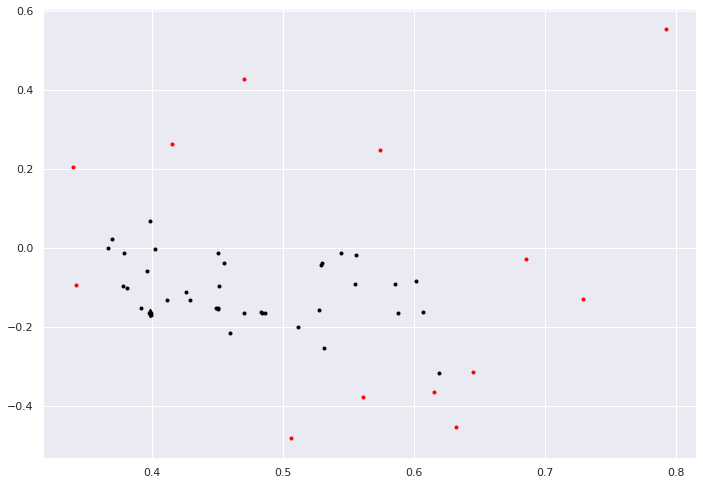

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


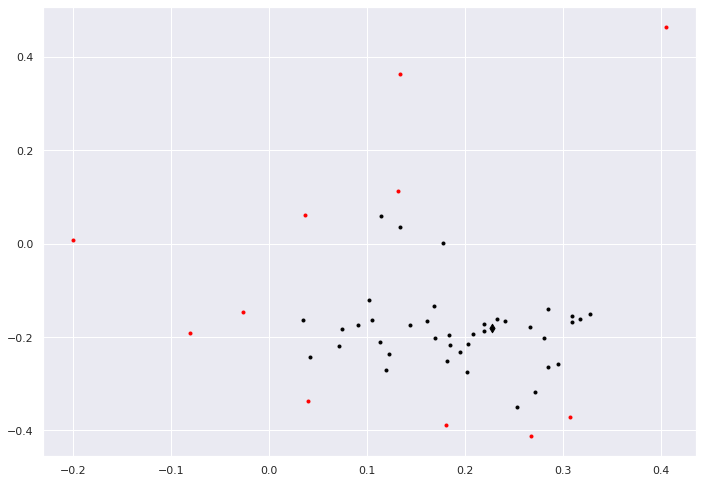

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


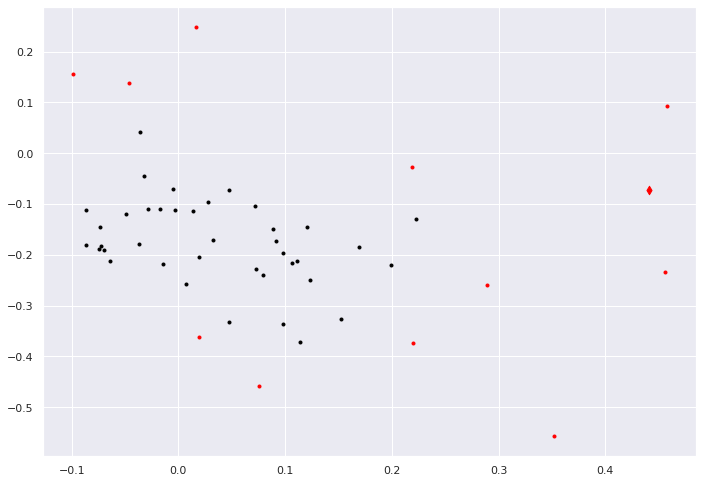

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.08023958627636445
fowlkes_mallows_score: 0.7956983826217061
homogeneity_completeness_v_measure: 0.2920260886363456 0.05060849648510717 0.08626683891279346


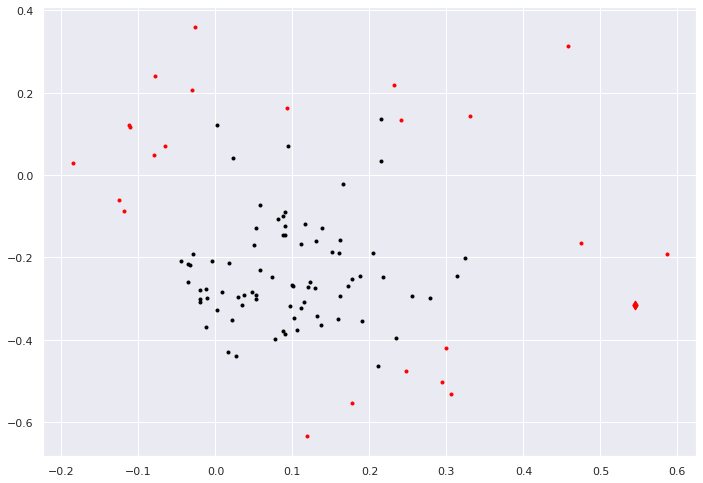

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.24397586005726946
fowlkes_mallows_score: 0.8651775751910288
homogeneity_completeness_v_measure: 0.42741873193962354 0.1389852175018282 0.20976155085629314


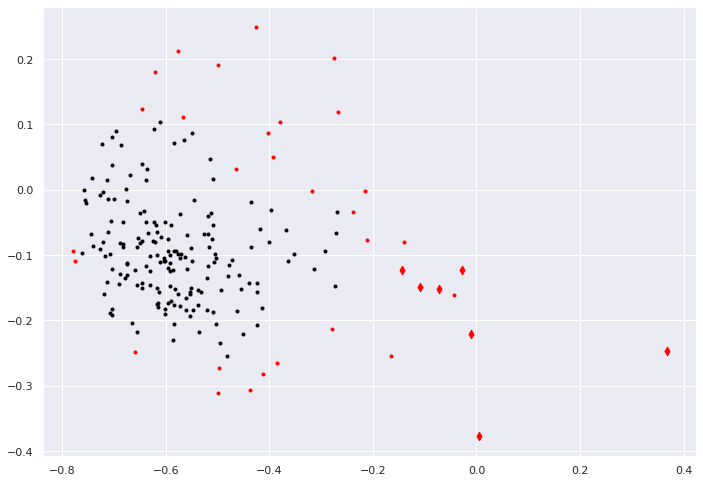

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.08601649185355491
fowlkes_mallows_score: 0.819395756019025
homogeneity_completeness_v_measure: 0.06150795896788435 0.020778526473888212 0.03106329664968819


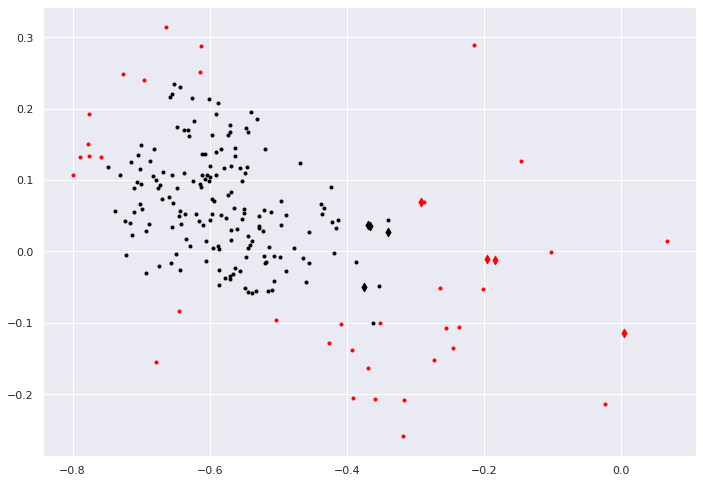

In [23]:
from sklearn.ensemble import IsolationForest


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, IsolationForest, params=None)

# one class svm 

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

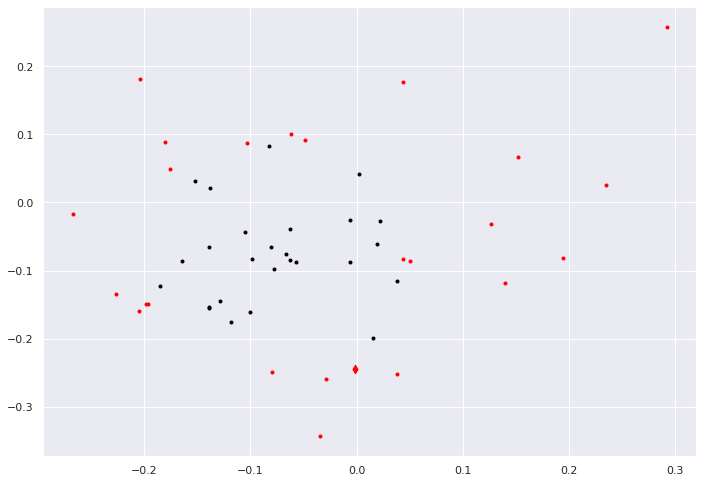

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


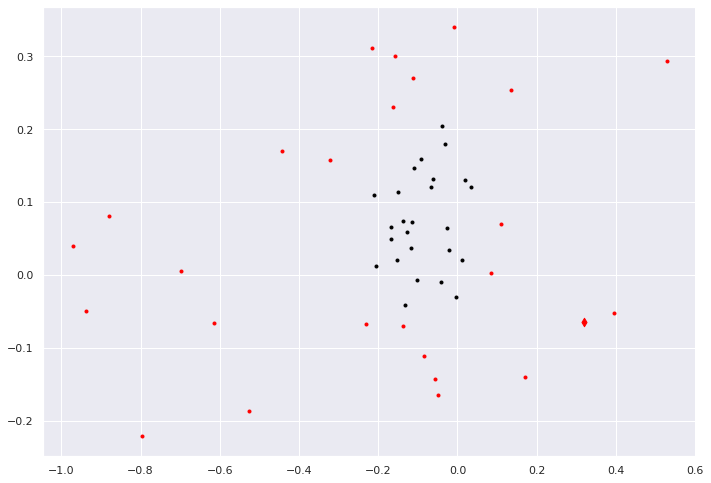

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: 0.0049081985093619345
fowlkes_mallows_score: 0.6891839007912093
homogeneity_completeness_v_measure: 0.1554324907626066 0.02169551538314924 0.03807628243278946


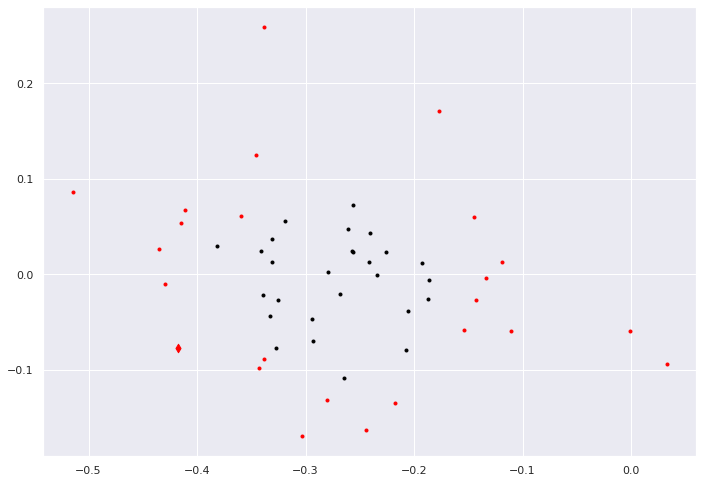

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.005203319717980071
fowlkes_mallows_score: 0.6475881732368012
homogeneity_completeness_v_measure: 0.0 0.0 0.0


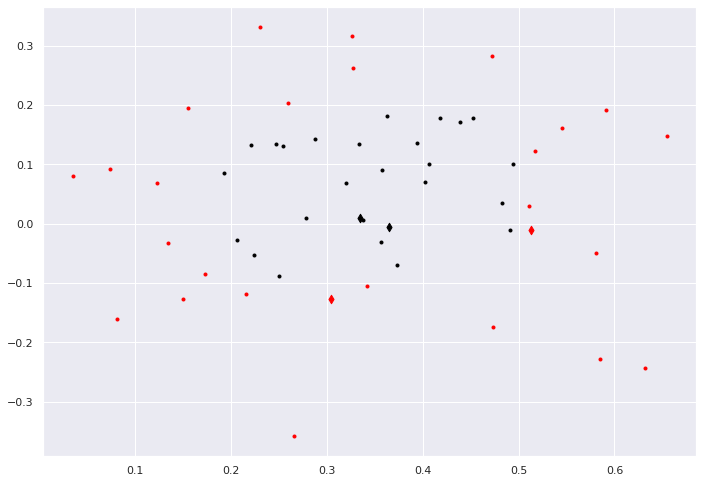

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.00340642743958801
fowlkes_mallows_score: 0.6879162727700022
homogeneity_completeness_v_measure: 0.15523438183024274 0.026980118808811848 0.04597045844654071


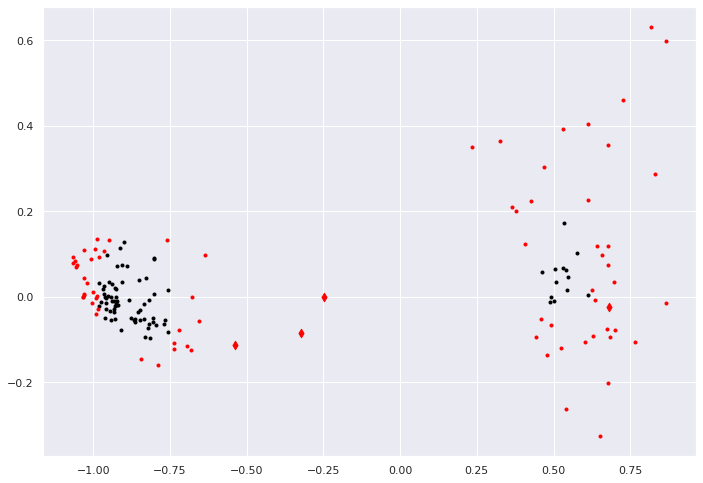

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


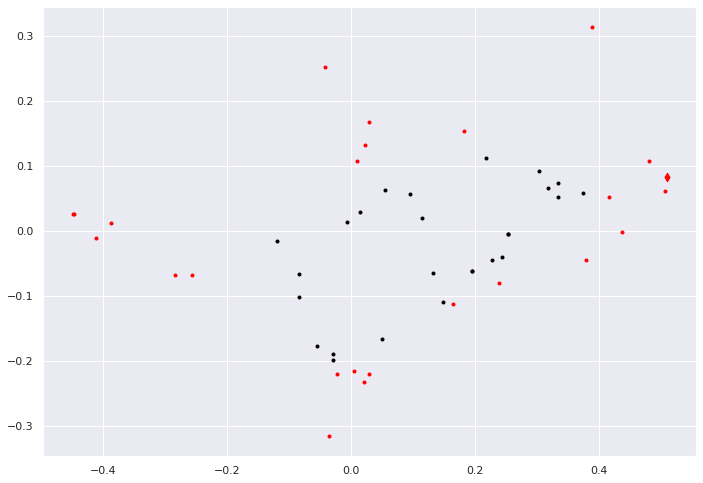

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.0040912300130731384
fowlkes_mallows_score: 0.6378019122470585
homogeneity_completeness_v_measure: 0.01850567096165278 0.008989779582641024 0.012101049423150082


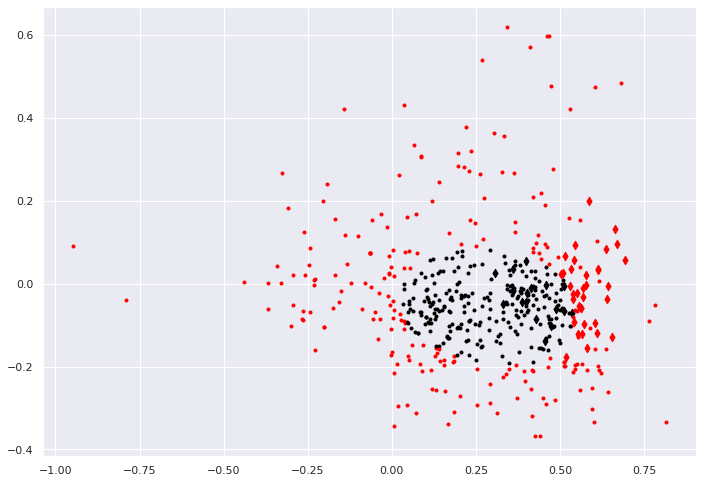

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.003025366534791715
fowlkes_mallows_score: 0.6743643102871643
homogeneity_completeness_v_measure: 0.1682513330031832 0.03957160000461408 0.06407352984086015


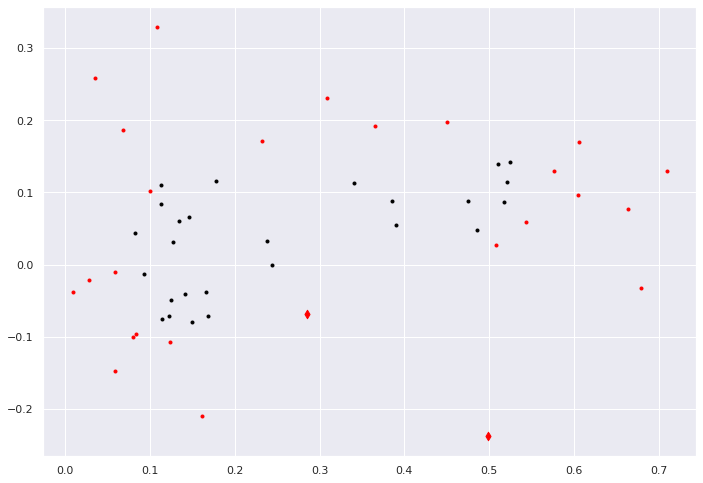

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.001099481044946785
fowlkes_mallows_score: 0.682871474172461
homogeneity_completeness_v_measure: 0.01216763411343253 0.0023118951955915417 0.003885526144973343


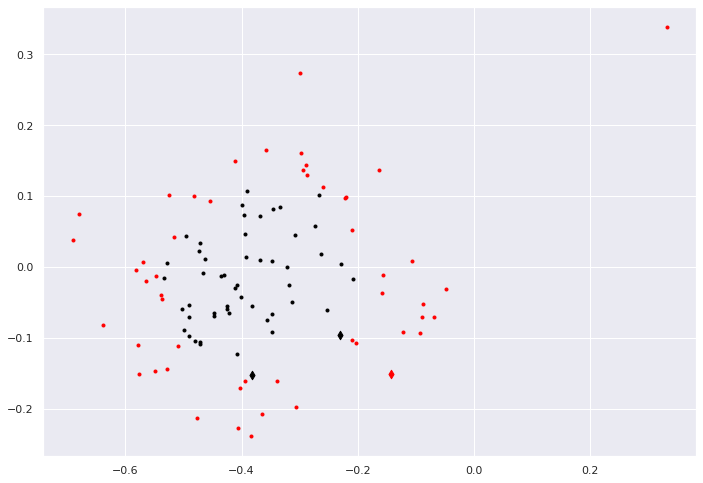

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


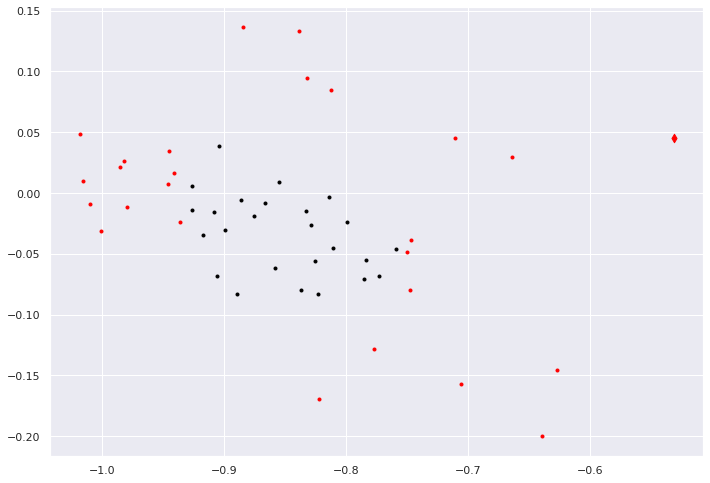

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.01685875588625543
fowlkes_mallows_score: 0.6561939961369581
homogeneity_completeness_v_measure: 0.20568053456521845 0.0783532973886795 0.11347766553715974


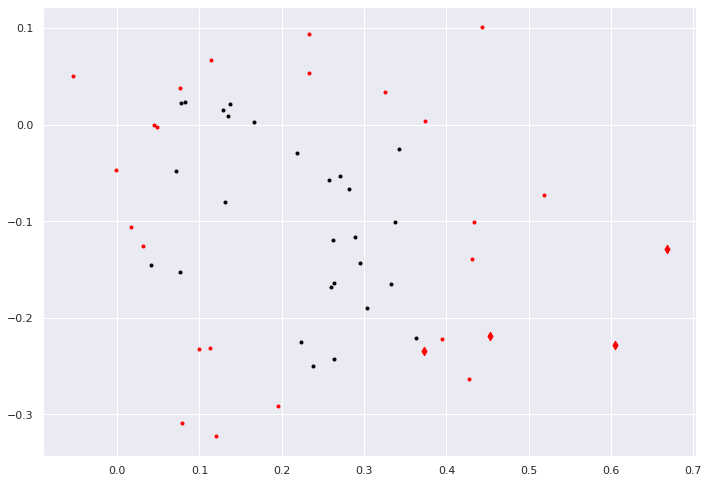

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: -0.0007322832292195953
fowlkes_mallows_score: 0.6896704506581811
homogeneity_completeness_v_measure: 0.13883555484580953 0.019335853523212897 0.03394423783658132


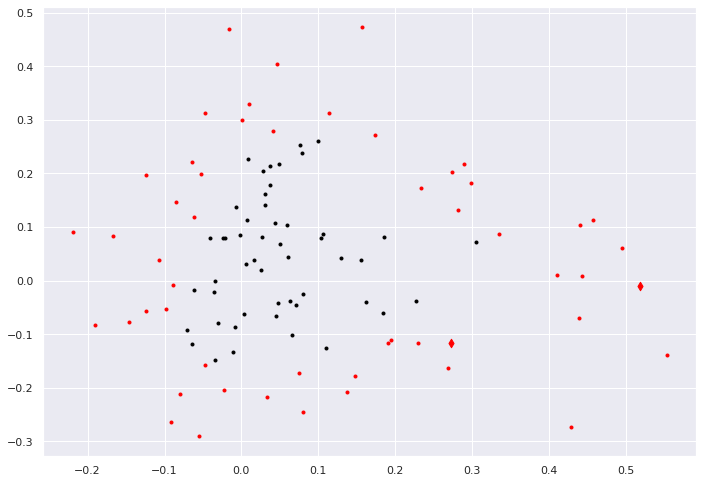

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.033873699491894504
fowlkes_mallows_score: 0.6523691359369412
homogeneity_completeness_v_measure: 0.2278434404710406 0.10016039133923603 0.13915013148296004


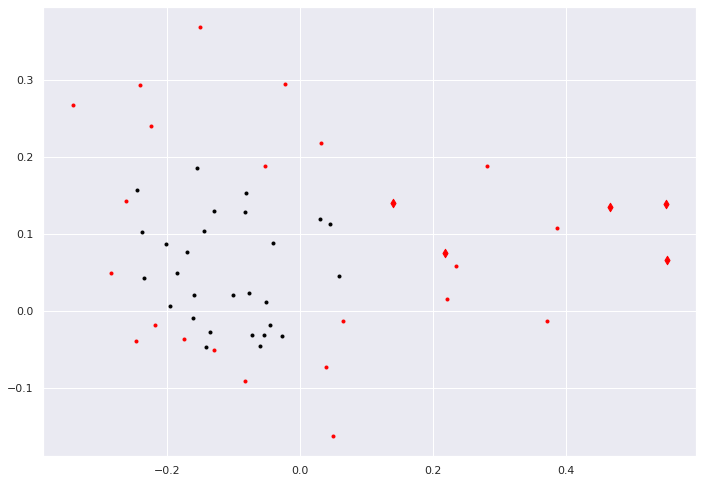

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: -0.000661859361504274
fowlkes_mallows_score: 0.6863679169389767
homogeneity_completeness_v_measure: 0.0 0.0 0.0


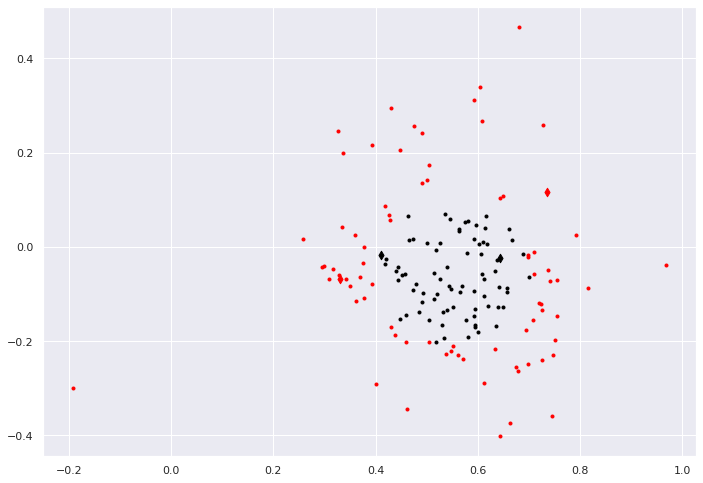

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


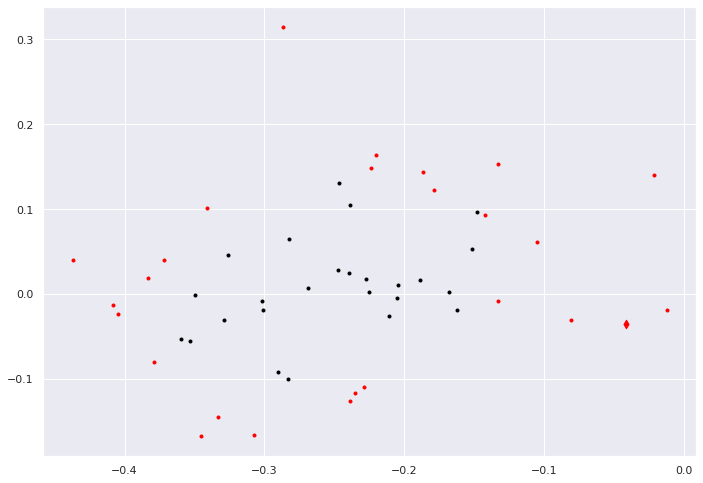

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


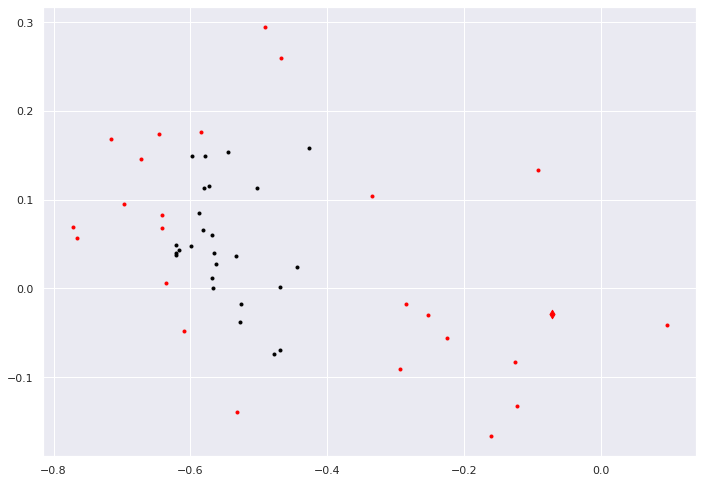

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.002346893026870311
fowlkes_mallows_score: 0.6907959838293899
homogeneity_completeness_v_measure: 0.14696457212882502 0.020467994981116955 0.035931720771617735


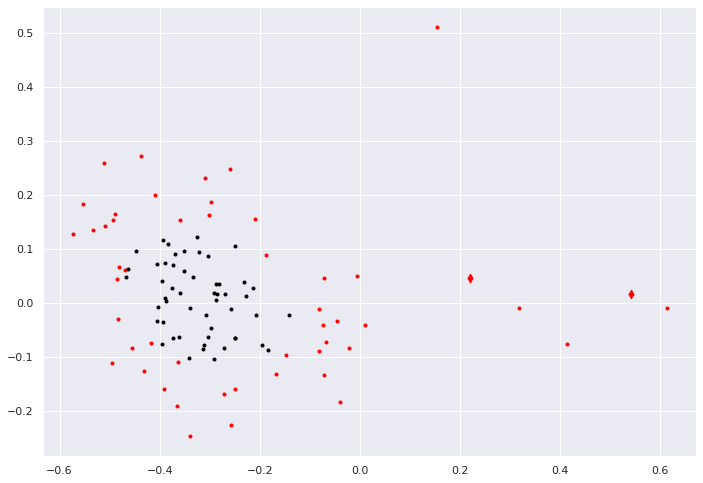

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


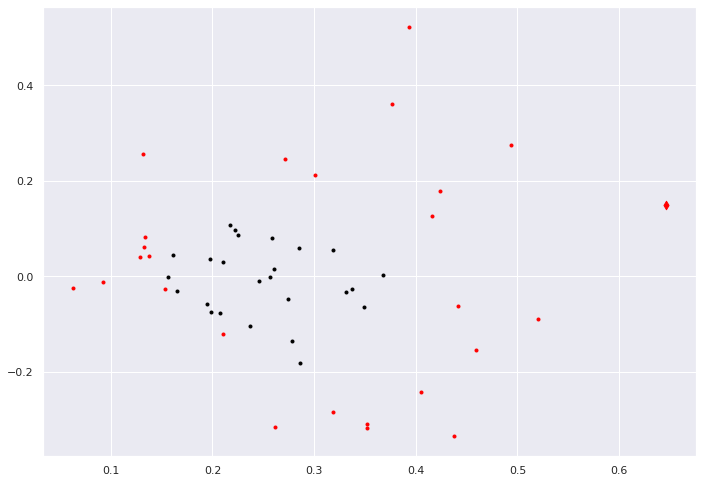

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.033873699491894504
fowlkes_mallows_score: 0.6523691359369412
homogeneity_completeness_v_measure: 0.2278434404710406 0.10016039133923603 0.13915013148296004


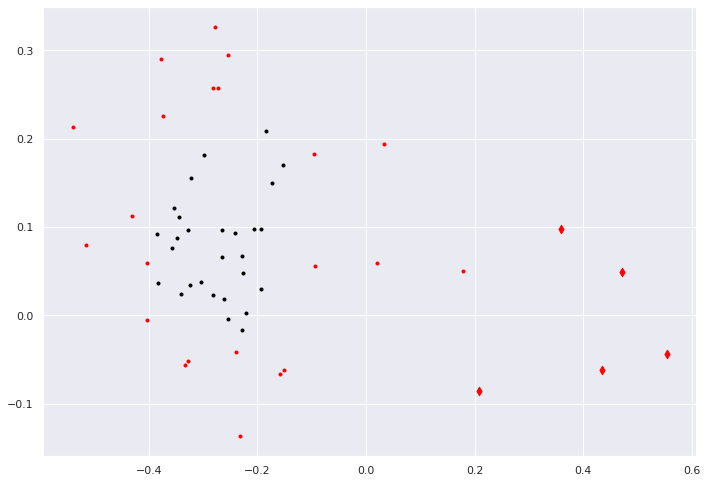

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.00409848991786824
fowlkes_mallows_score: 0.671025213538636
homogeneity_completeness_v_measure: 0.05941333083033412 0.017550290459992745 0.027096469625164574


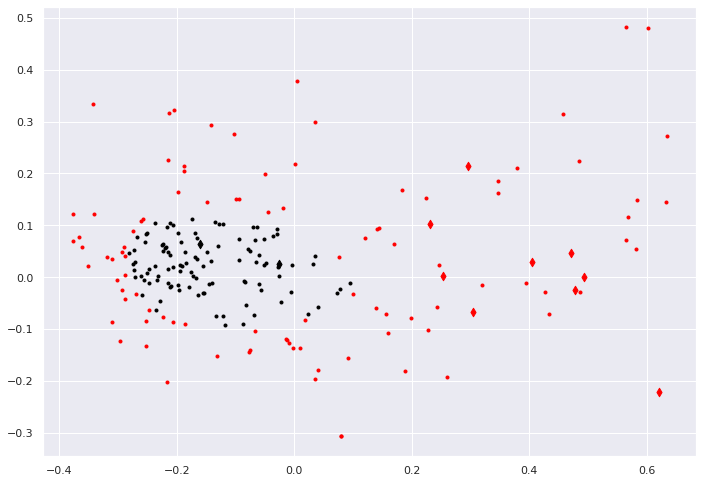

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


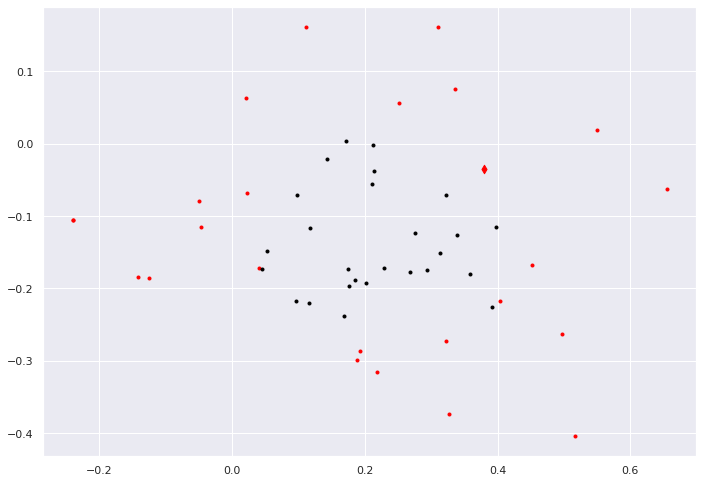

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


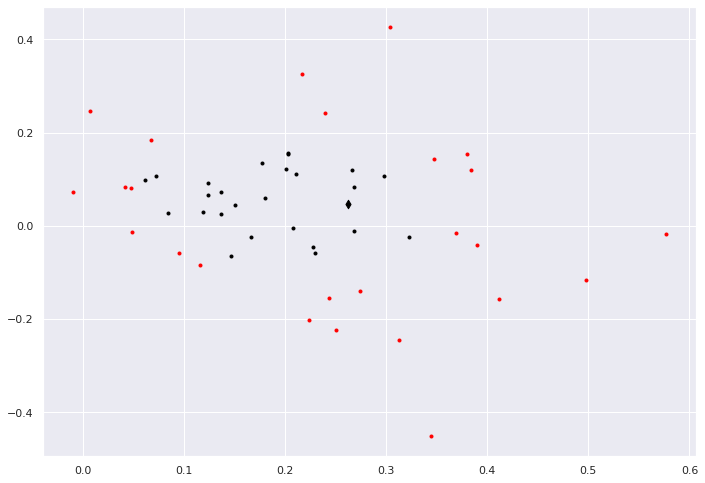

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: -0.0026886237607124854
fowlkes_mallows_score: 0.6727268205007042
homogeneity_completeness_v_measure: 0.15899339002802354 0.03743414825256139 0.06060028227798269


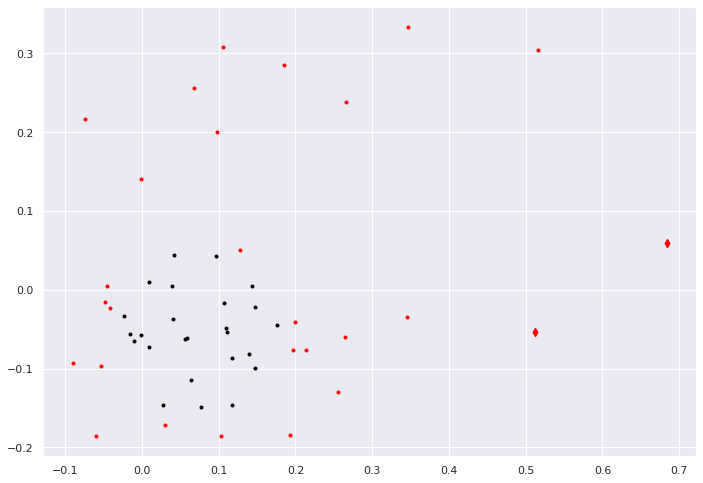

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


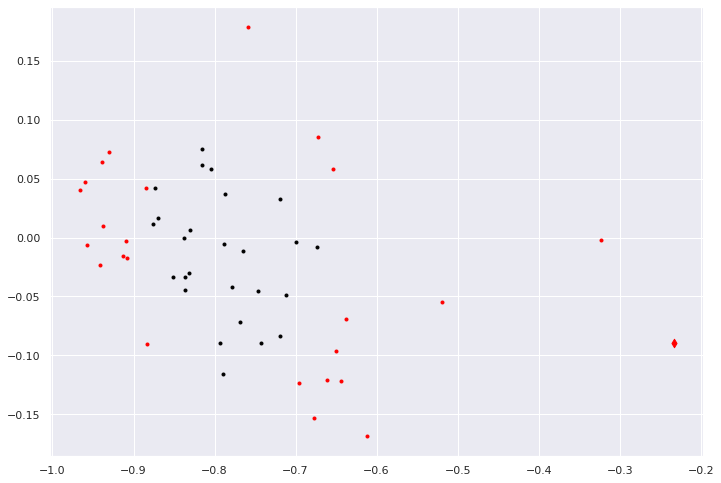

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.023987422072913198
fowlkes_mallows_score: 0.6637070480984305
homogeneity_completeness_v_measure: 0.20945424546817668 0.07979965344862487 0.1155688913048068


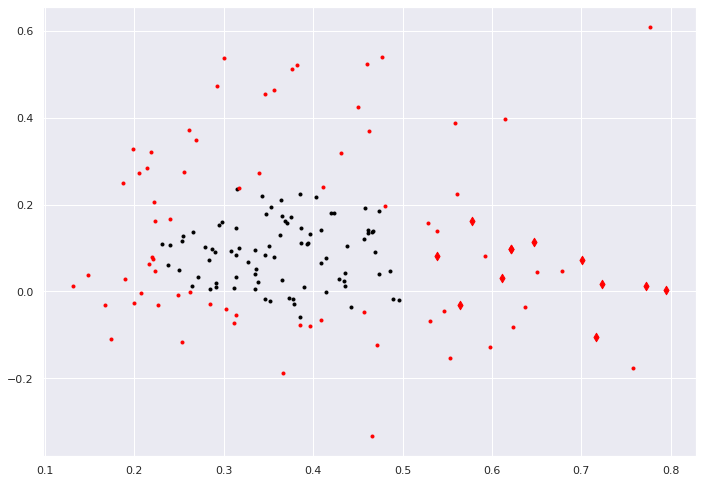

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.0028729614174167668
fowlkes_mallows_score: 0.6886047361512531
homogeneity_completeness_v_measure: 0.15397713507800798 0.027391768964484947 0.04650969395373221


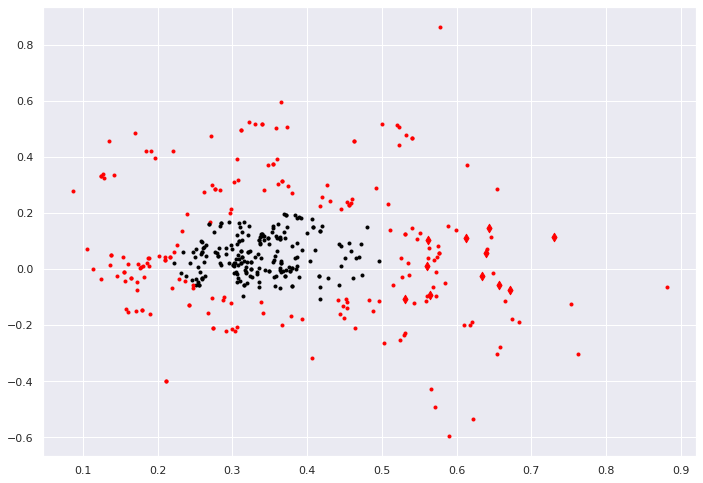

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


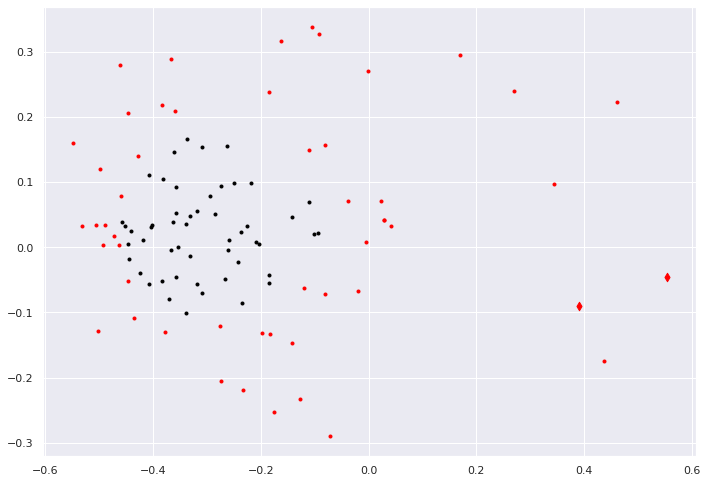

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: 0.023600510735853526
fowlkes_mallows_score: 0.6518199378655269
homogeneity_completeness_v_measure: 0.12424051254713926 0.054616355560564725 0.07587703038851414


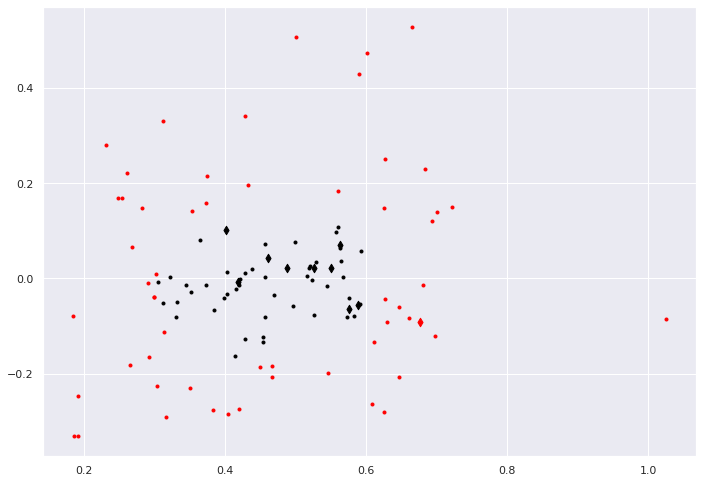

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.006048874909266876
fowlkes_mallows_score: 0.6365605139029281
homogeneity_completeness_v_measure: 0.0054662033886386276 0.0024029529637281397 0.003338357771762772


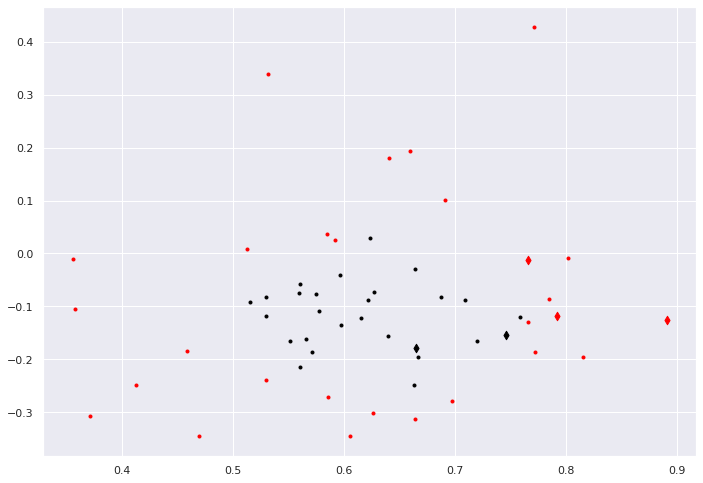

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


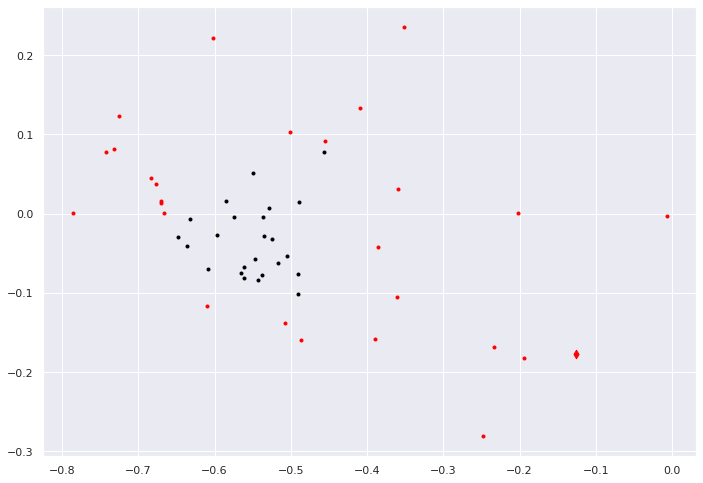

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.006219327757029538
fowlkes_mallows_score: 0.6525022327591361
homogeneity_completeness_v_measure: 0.19465535560540279 0.07422675749048259 0.10747190066595014


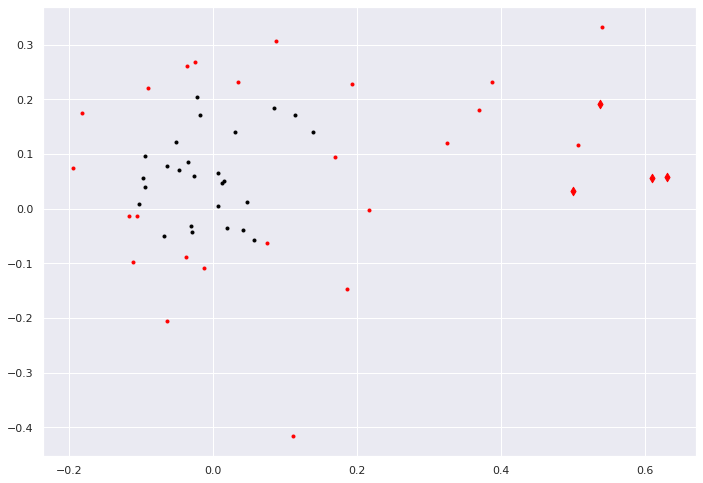

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.0029090062834535723
fowlkes_mallows_score: 0.672123897296177
homogeneity_completeness_v_measure: 0.0 0.0 0.0


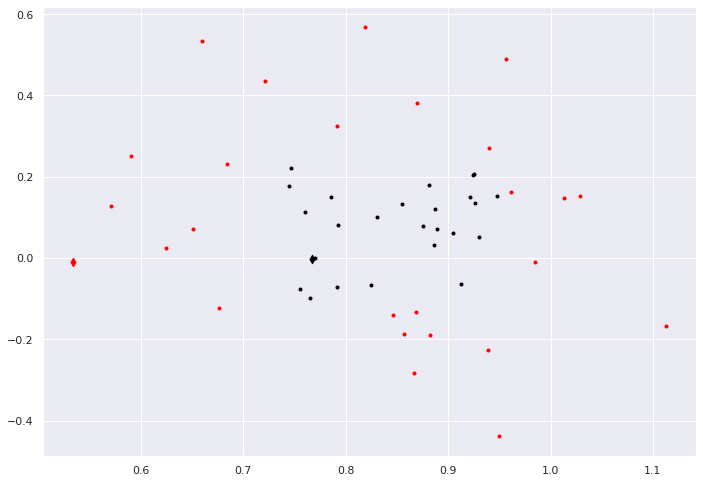

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.011561658017476753
fowlkes_mallows_score: 0.6643158765782217
homogeneity_completeness_v_measure: 0.10156532577246785 0.03608260045978397 0.053248038974917505


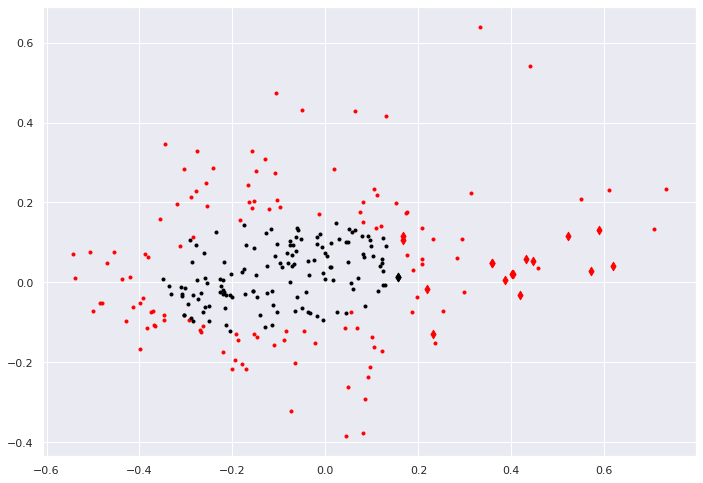

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.0011654499076435923
fowlkes_mallows_score: 0.683707302170224
homogeneity_completeness_v_measure: 0.15441999878924076 0.02934036723786607 0.049311389297938386


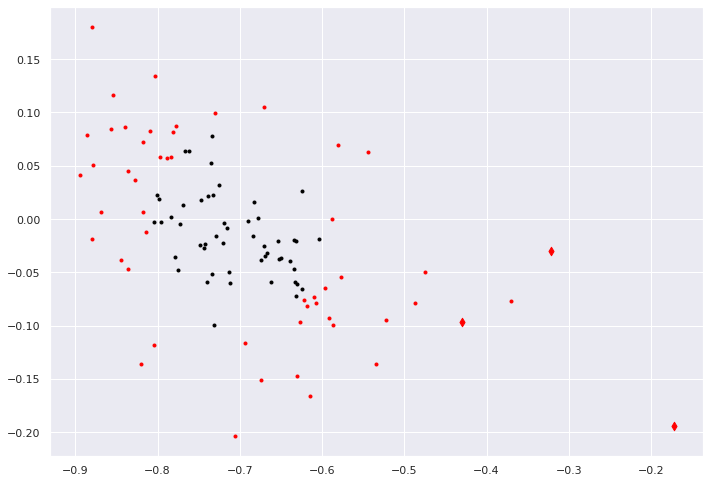

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: -0.0048226797123368005
fowlkes_mallows_score: 0.6482023827903773
homogeneity_completeness_v_measure: 0.00020795312530768855 7.929751613355203e-05 0.0001148137823217512


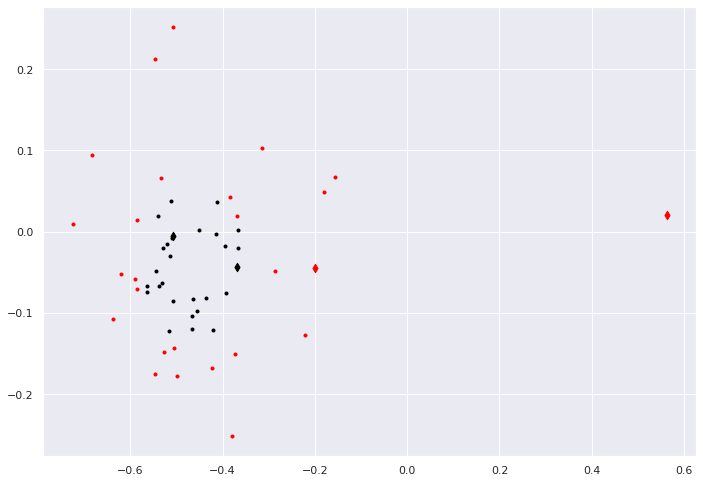

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.0034303808602339694
fowlkes_mallows_score: 0.6845431301679872
homogeneity_completeness_v_measure: 0.1588448730374049 0.030181109605696983 0.050724397317342976


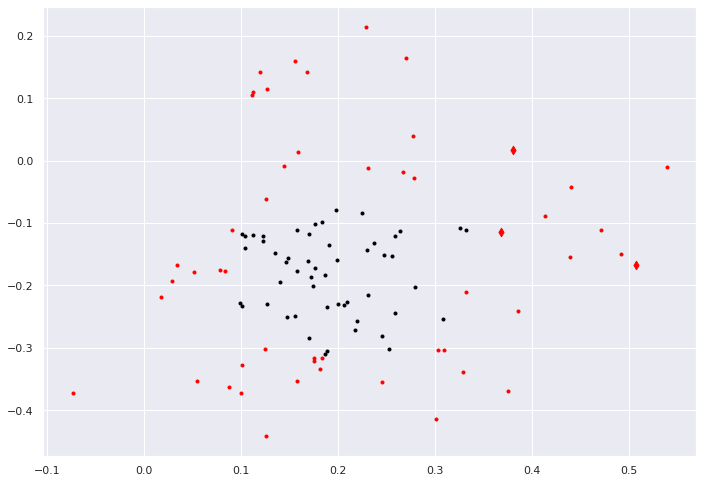

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


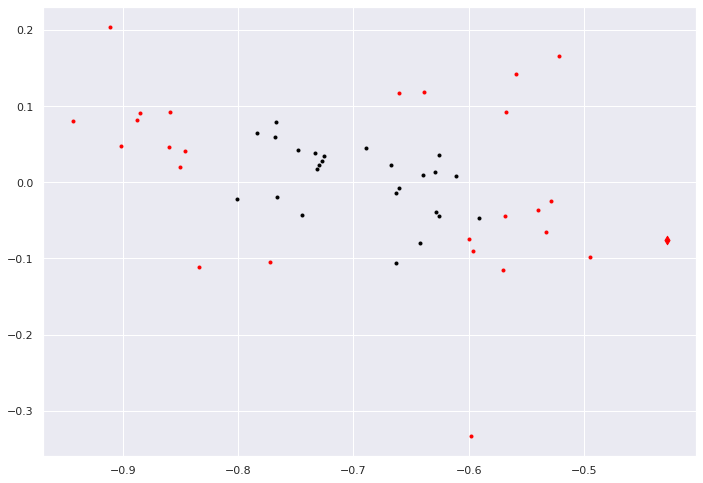

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.007507919200225105
fowlkes_mallows_score: 0.6798023315504449
homogeneity_completeness_v_measure: 0.17302027675988937 0.040704083333848264 0.06590387507152849


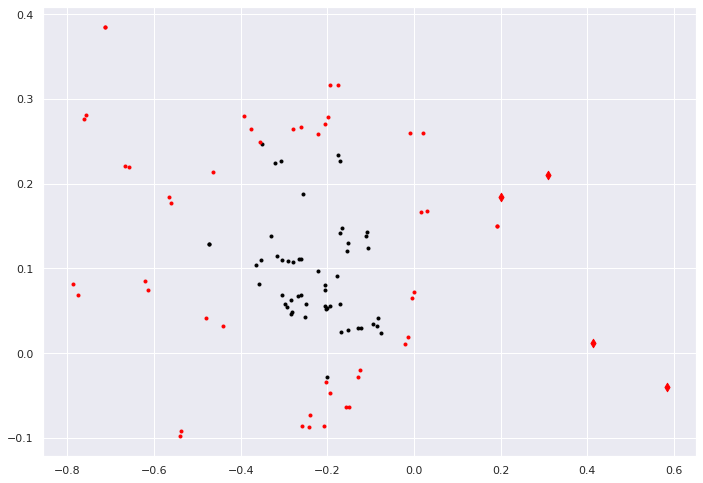

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


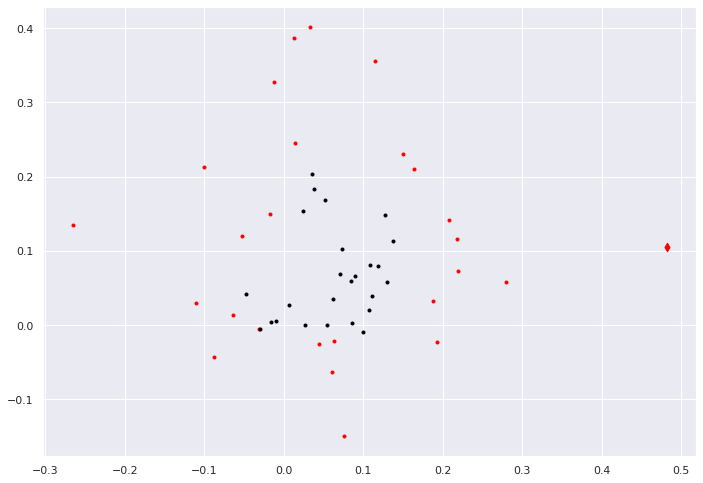

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: -0.003432851347134089
fowlkes_mallows_score: 0.6608505895985824
homogeneity_completeness_v_measure: 0.1730054389688834 0.05441718522336549 0.08279272170442442


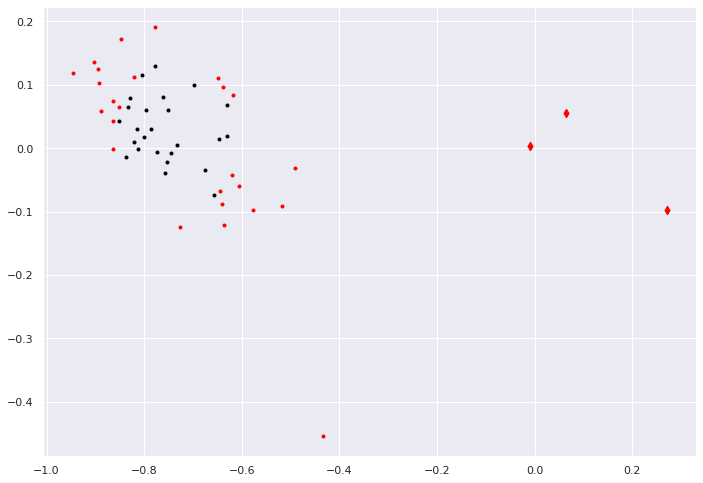

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.008030606277625085
fowlkes_mallows_score: 0.6662512548448132
homogeneity_completeness_v_measure: 0.07791901419040989 0.026282050057916617 0.03930615193210481


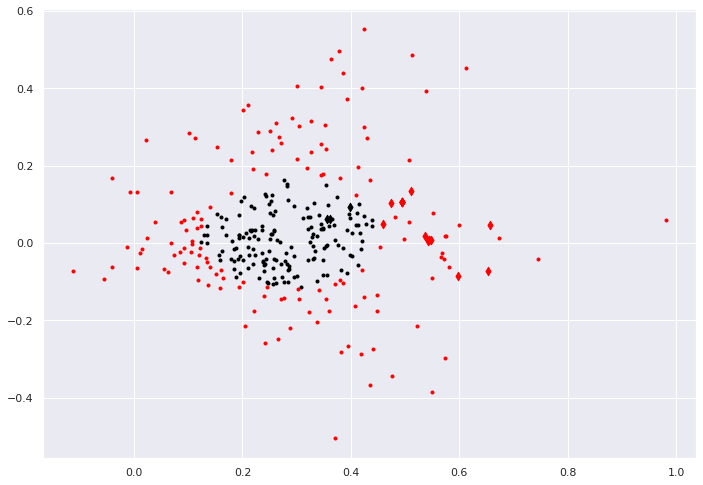

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.0035190583147088166
fowlkes_mallows_score: 0.6753788446507332
homogeneity_completeness_v_measure: 0.17043119868033835 0.04482454055509788 0.07098068747653746


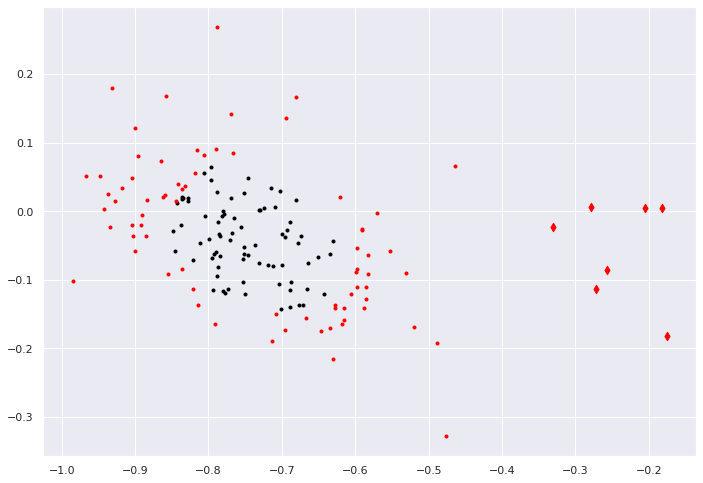

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


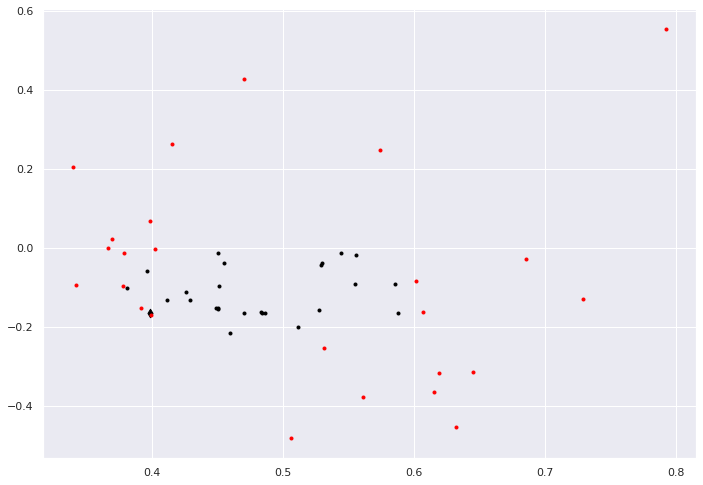

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


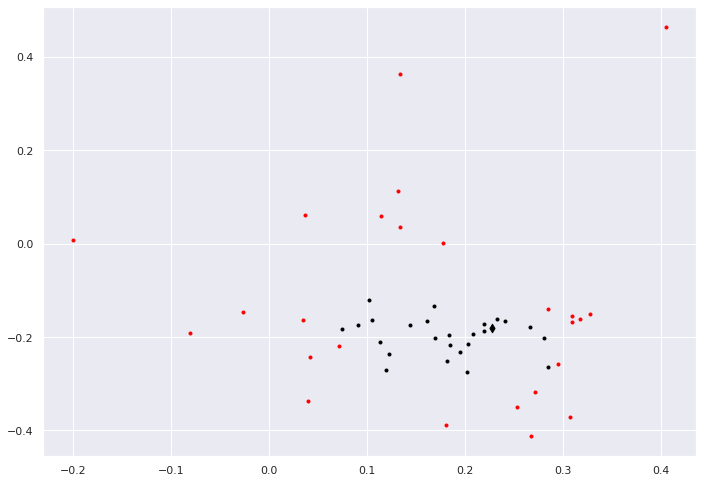

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


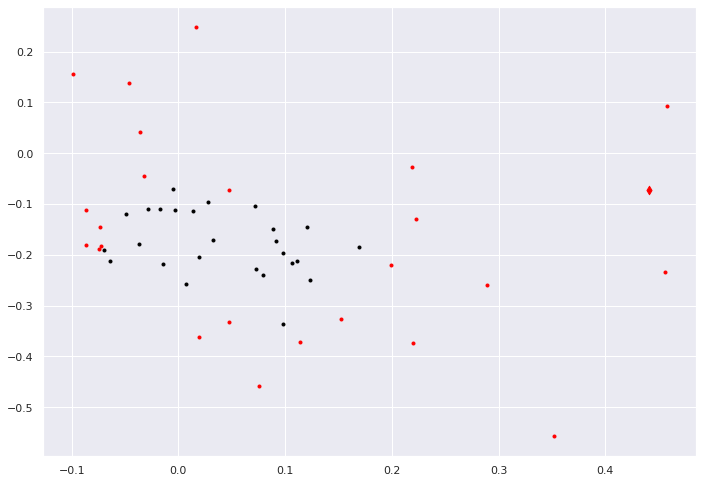

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


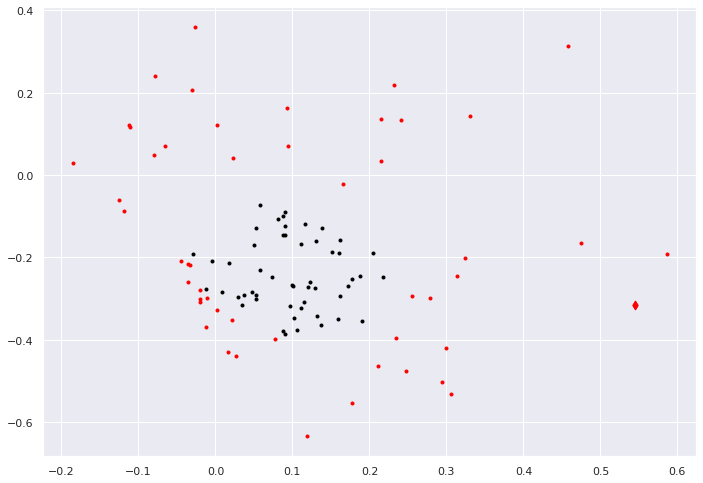

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.003291540011119214
fowlkes_mallows_score: 0.683056228841494
homogeneity_completeness_v_measure: 0.1614893763771658 0.03442752282792292 0.056755483720390625


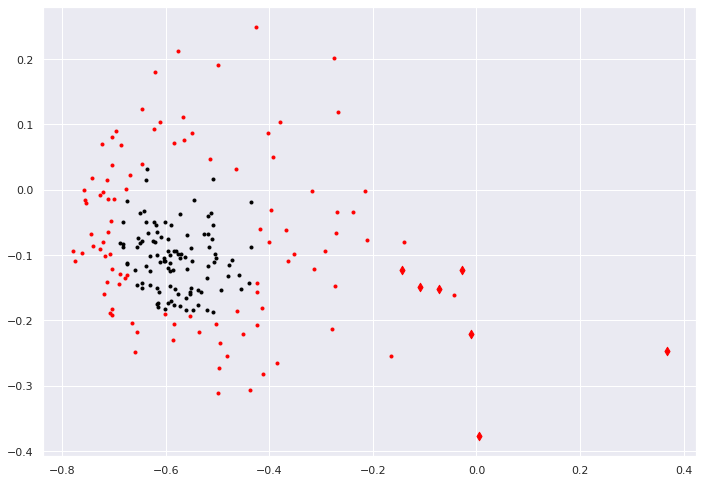

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.005206247496996396
fowlkes_mallows_score: 0.6806031838197856
homogeneity_completeness_v_measure: 0.1682513330031776 0.03957160000461275 0.064073529840858


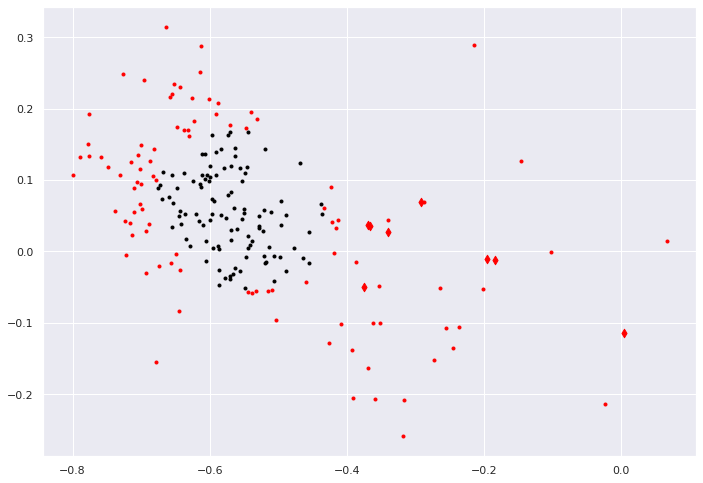

In [24]:
from sklearn.svm import OneClassSVM



# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, OneClassSVM, params=None)



# EllipticEnvelope

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

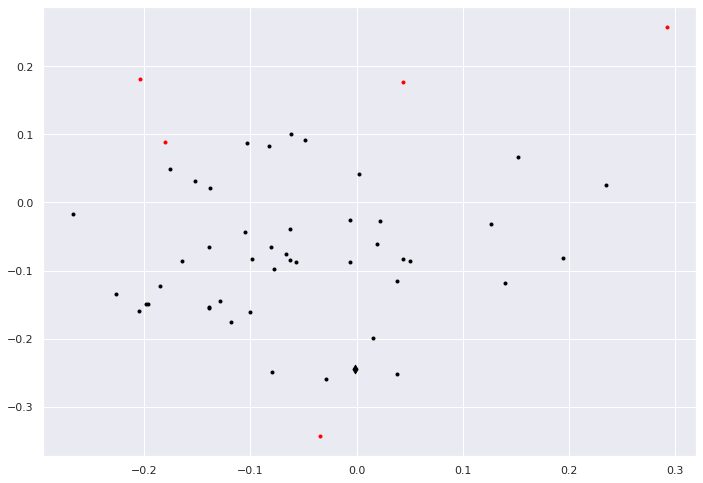

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


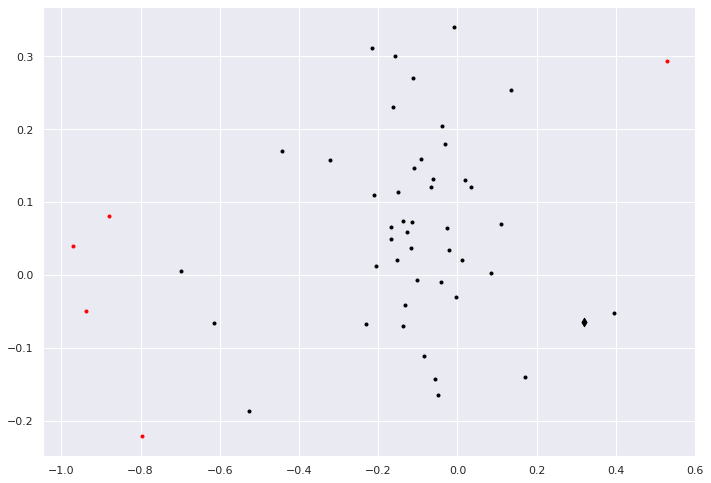

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


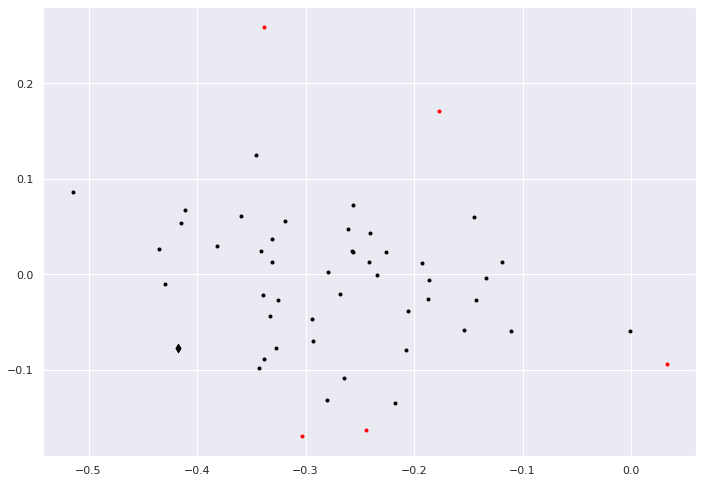

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: -0.07976293369551797
fowlkes_mallows_score: 0.8152190738955344
homogeneity_completeness_v_measure: 0.034412660271568175 0.026049018028360408 0.02965236933619754


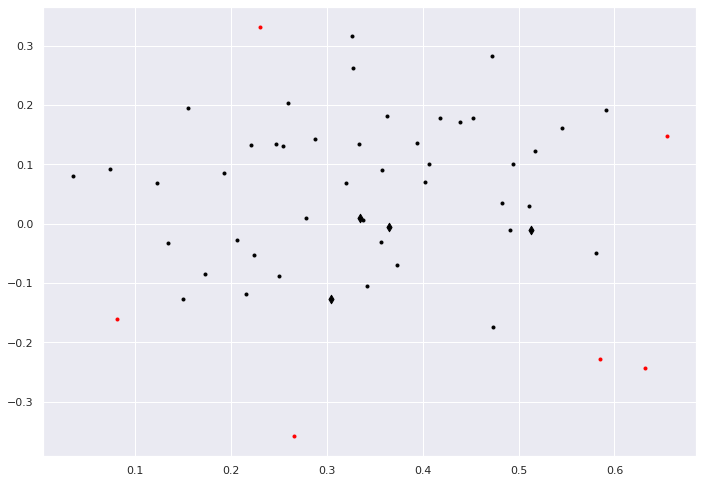

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


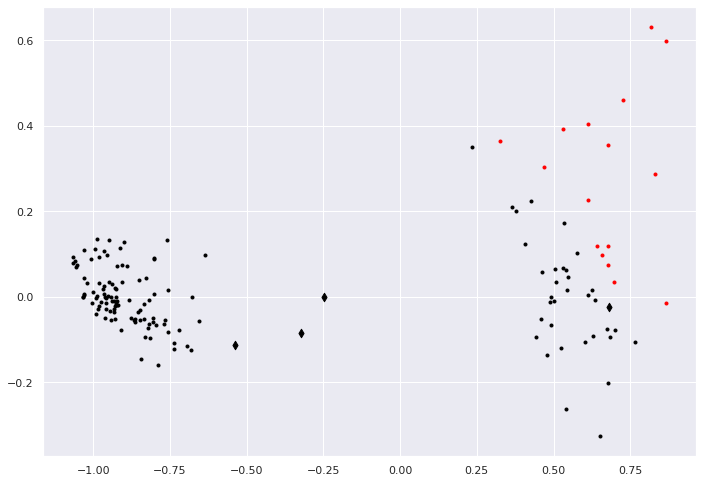

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


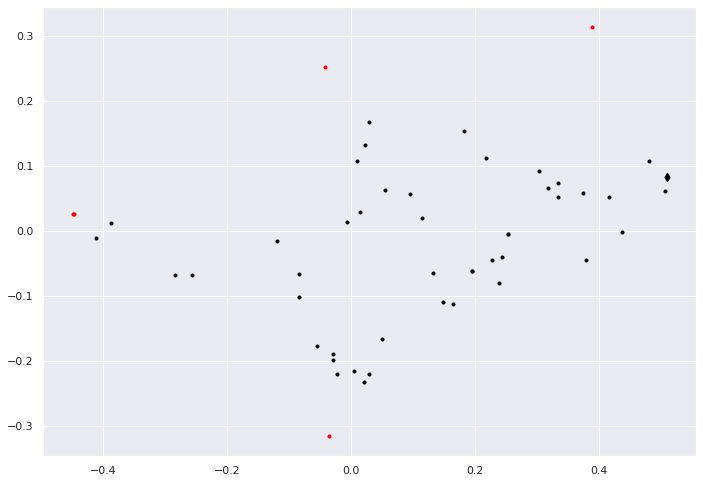

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.07093878307065
fowlkes_mallows_score: 0.801070215347033
homogeneity_completeness_v_measure: 0.018386741113376043 0.01886805870805866 0.018624290692199716


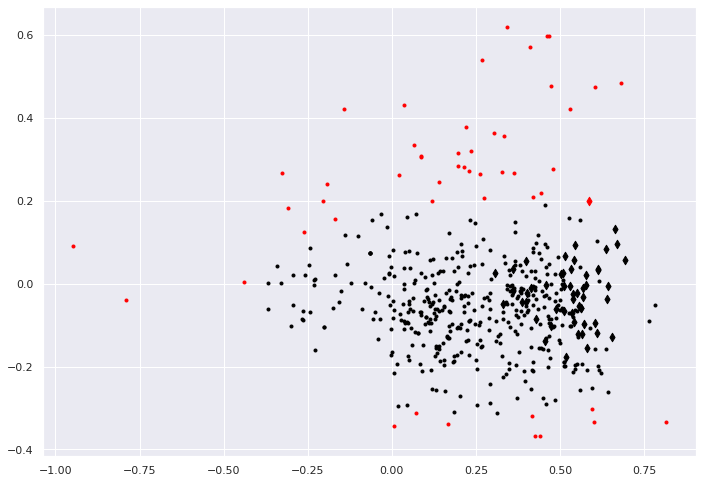

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


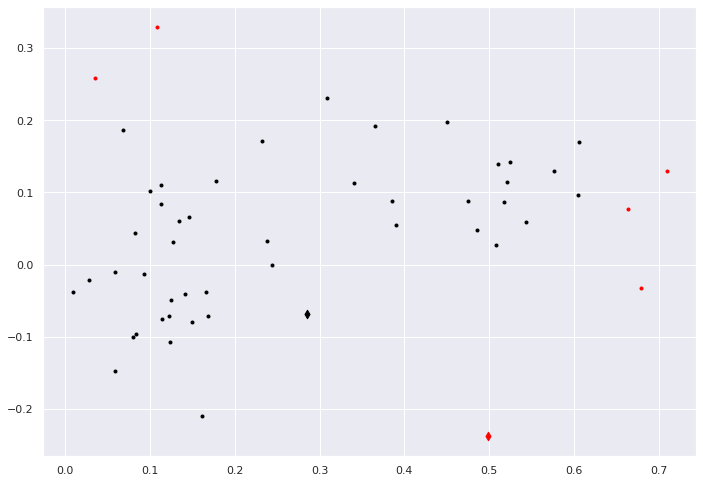

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: 0.08726858216478783
fowlkes_mallows_score: 0.8838812942987014
homogeneity_completeness_v_measure: 0.04260093205262327 0.016512001215638228 0.02379941589594289


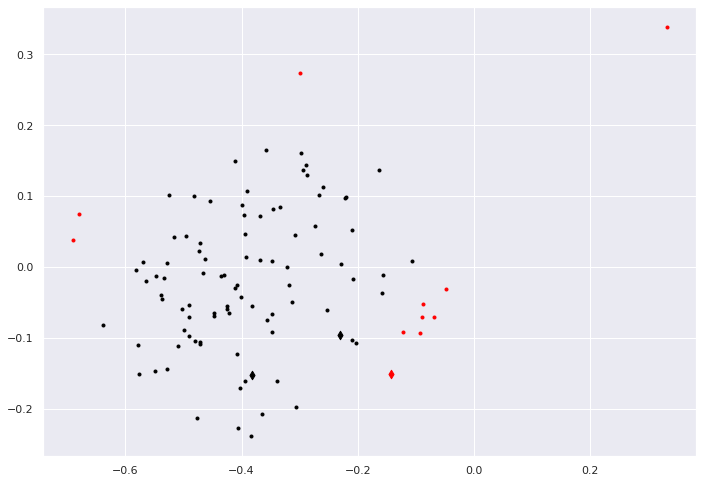

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


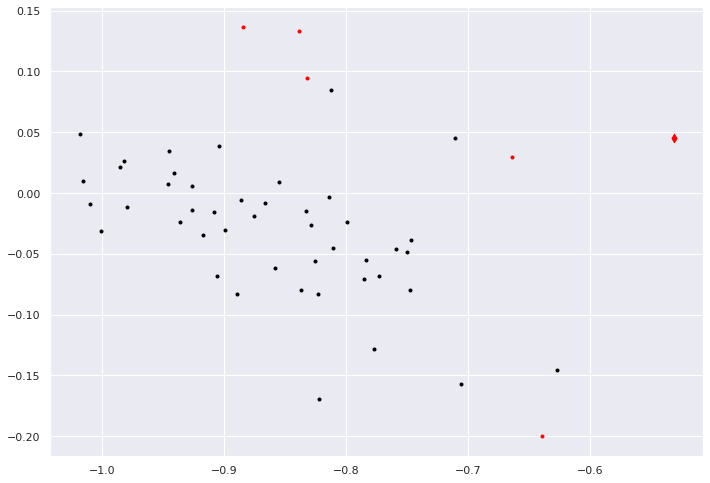

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


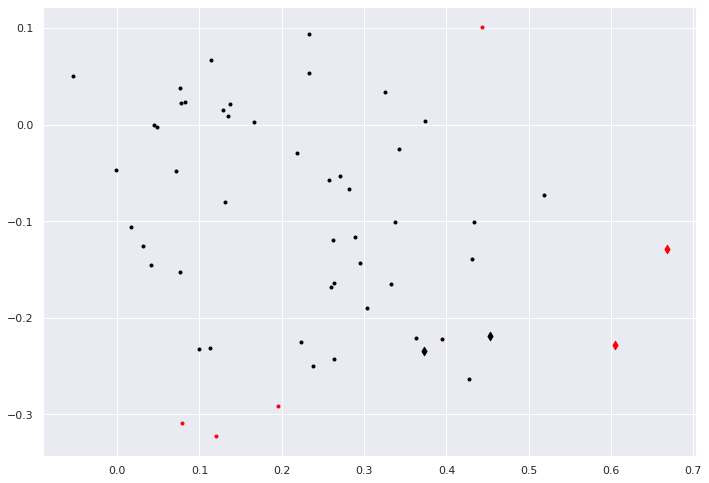

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.10884986754986345
fowlkes_mallows_score: 0.8934793337539082
homogeneity_completeness_v_measure: 0.10032311958540002 0.028311665665171255 0.0441609105135304


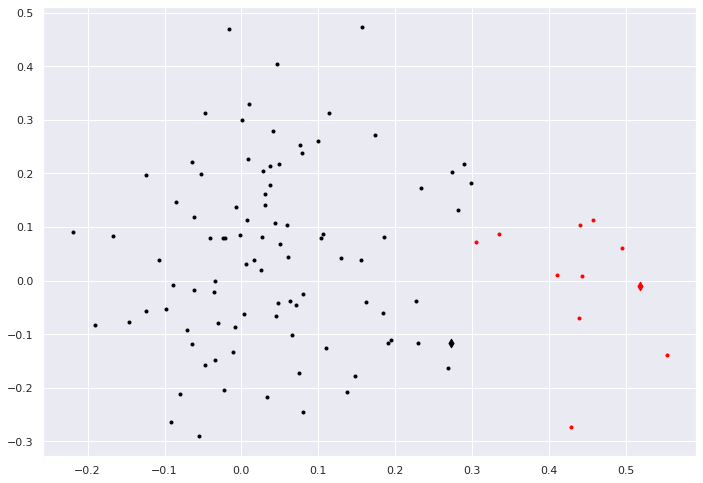

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.4382149990920646
fowlkes_mallows_score: 0.8970972715858277
homogeneity_completeness_v_measure: 0.25306732386104097 0.2237118633928022 0.23748588066886883


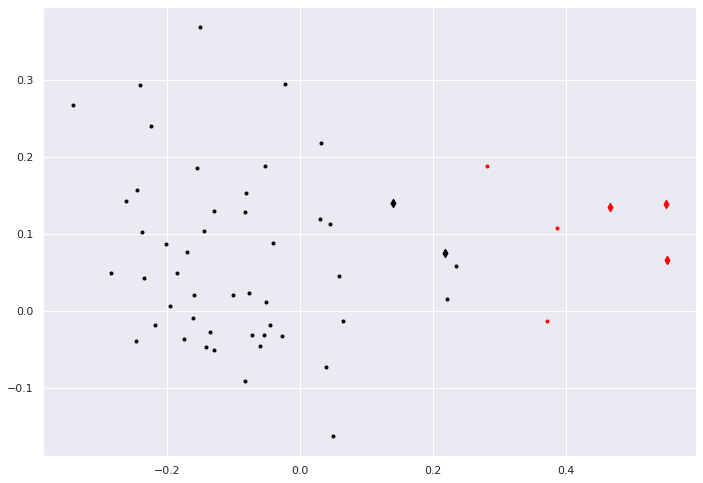

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


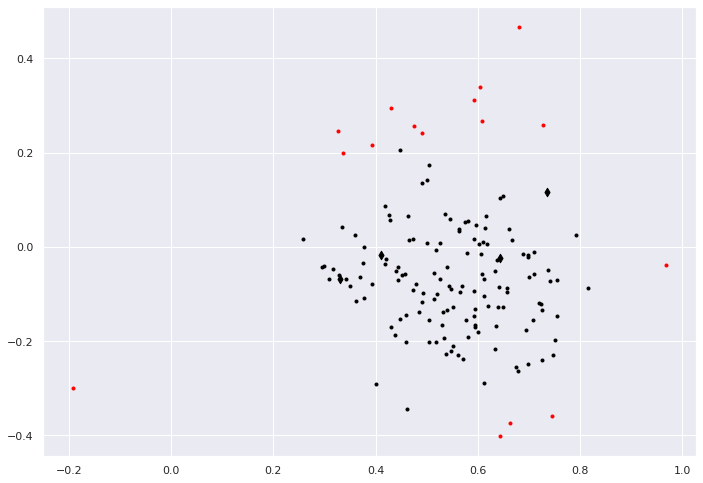

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


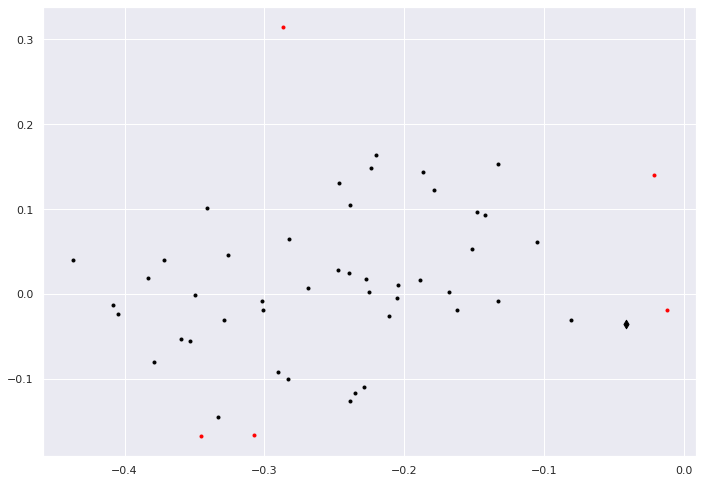

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


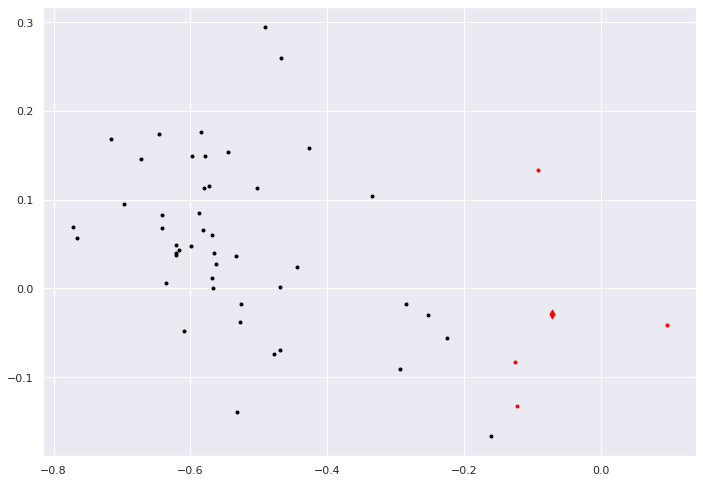

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


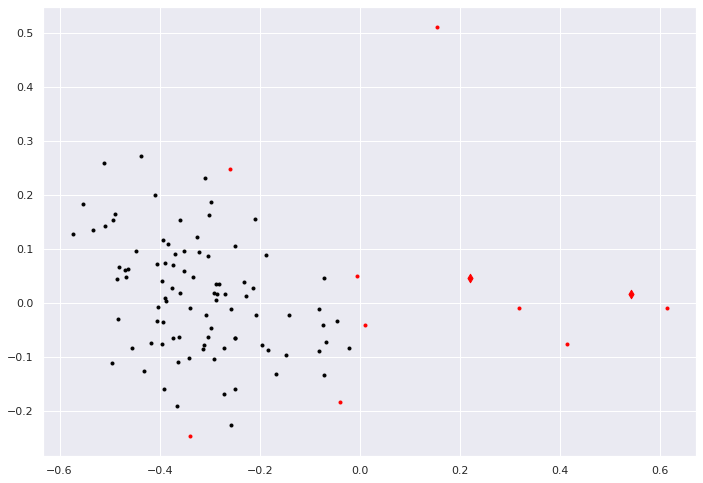

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


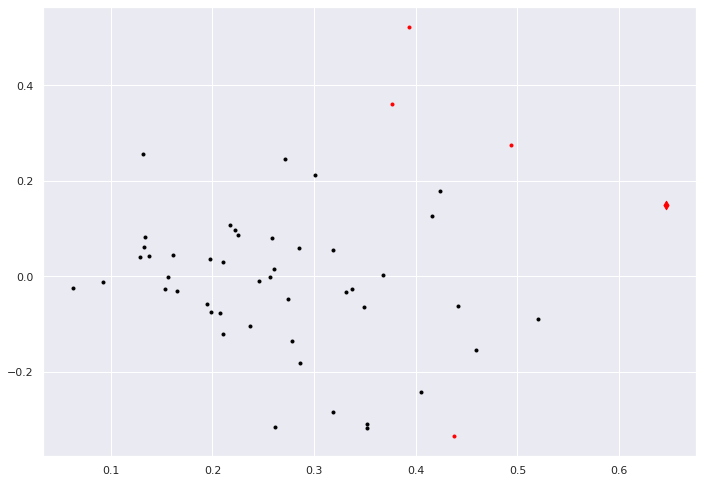

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.8786544398038859
fowlkes_mallows_score: 0.9779019890632276
homogeneity_completeness_v_measure: 0.8386529623245021 0.7413703755943142 0.7870168076007836


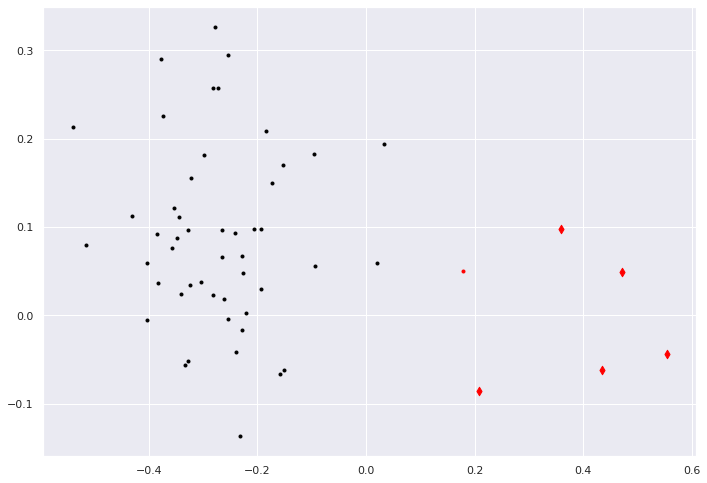

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.15946913298917673
fowlkes_mallows_score: 0.8786469309726235
homogeneity_completeness_v_measure: 0.06553166360545747 0.04012933371256025 0.0497769671745131


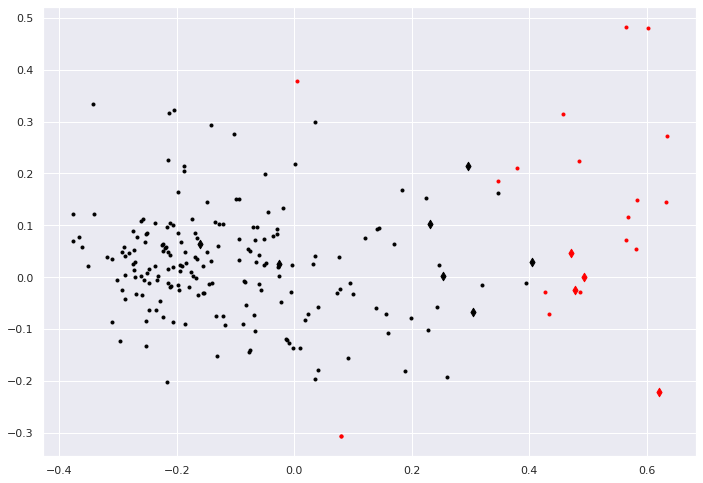

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


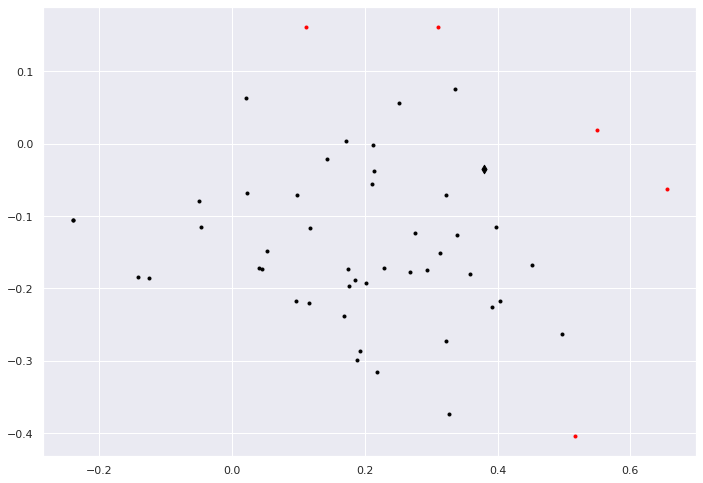

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


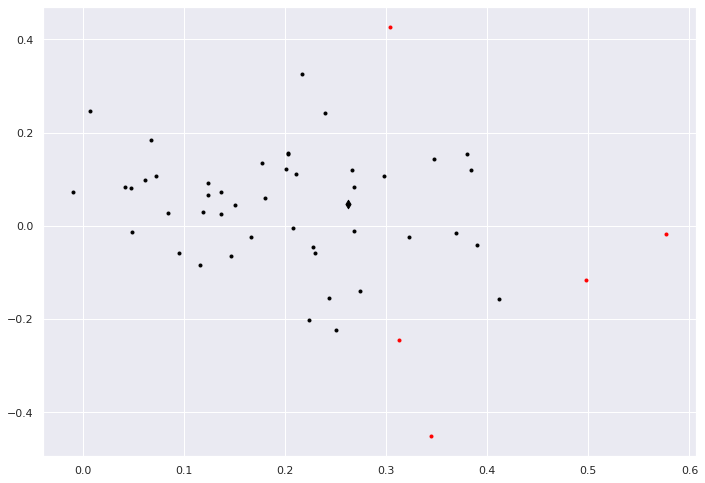

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


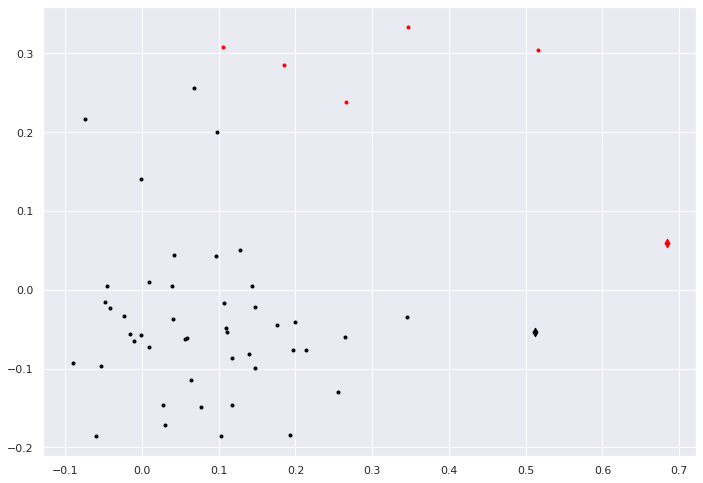

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


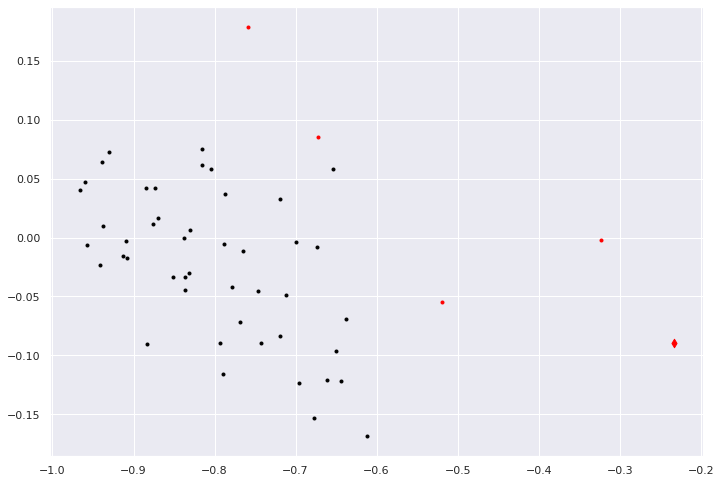

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.1739504446008219
fowlkes_mallows_score: 0.864681921296602
homogeneity_completeness_v_measure: 0.059562030222914765 0.04683585498894389 0.0524378582302237


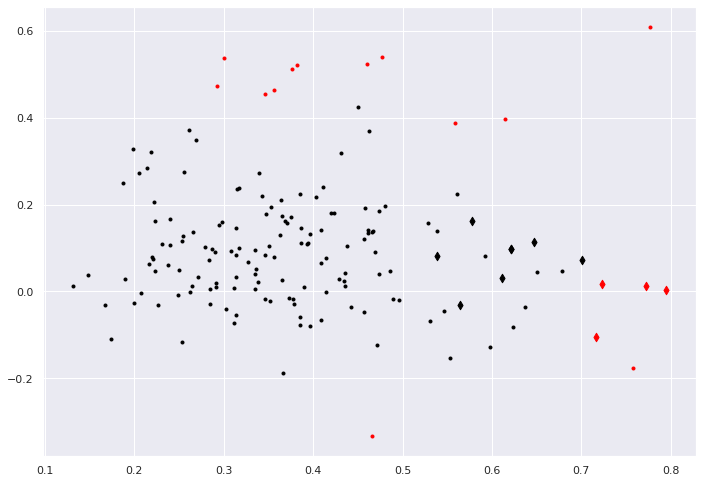

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.029613467578923327
fowlkes_mallows_score: 0.8831080913555259
homogeneity_completeness_v_measure: 0.006452432125820613 0.0024119637758184707 0.0035113577340400563


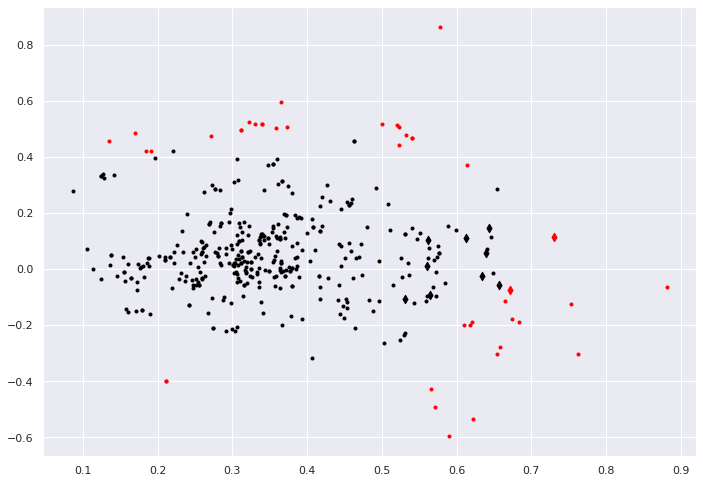

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


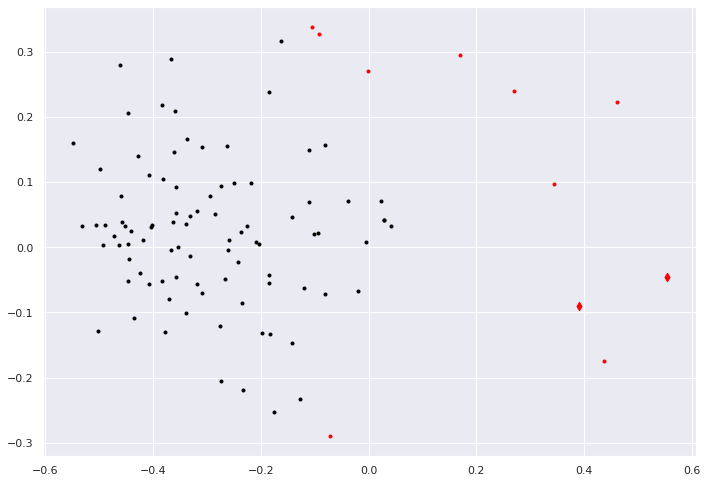

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.08304049420258265
fowlkes_mallows_score: 0.8112639652899177
homogeneity_completeness_v_measure: 0.03305265142814905 0.03097372536331339 0.03197943719974265


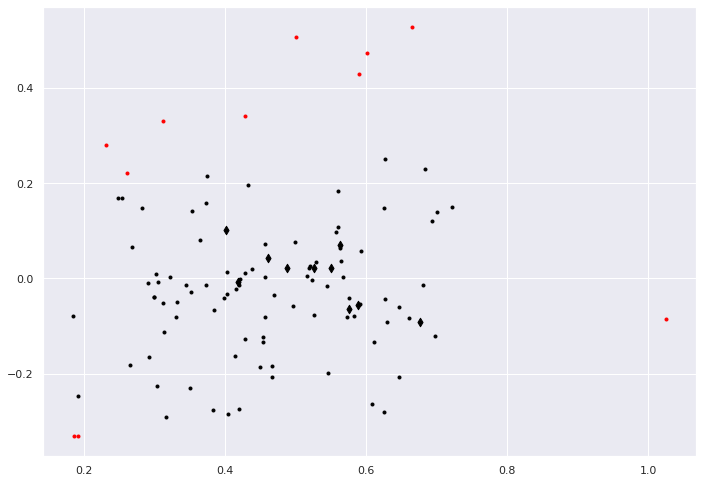

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.08761576175776285
fowlkes_mallows_score: 0.8006263333730135
homogeneity_completeness_v_measure: 0.03624737285782633 0.032042727608605194 0.03401560949765492


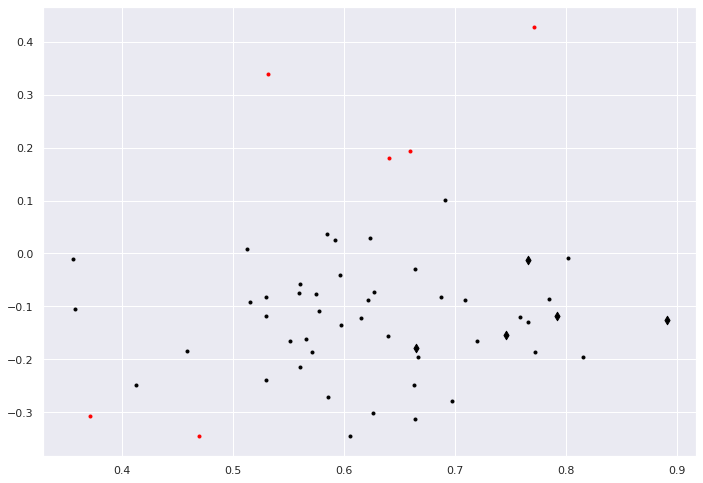

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


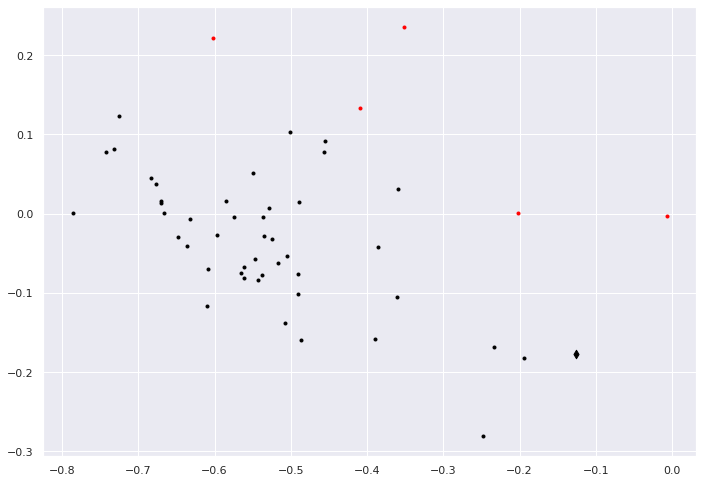

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.7447833065810594
fowlkes_mallows_score: 0.9568496885950687
homogeneity_completeness_v_measure: 0.7321596405397185 0.5542157893504782 0.6308802604336415


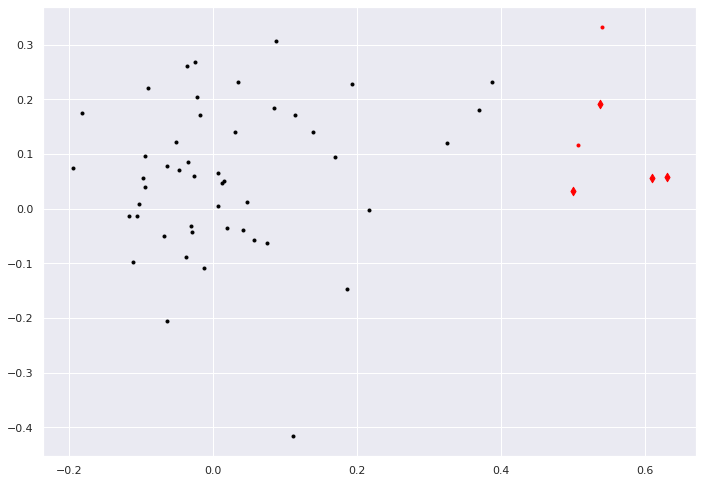

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.17456966547580383
fowlkes_mallows_score: 0.8813737573513271
homogeneity_completeness_v_measure: 0.11279267219407388 0.051416315273686154 0.07063418005948861


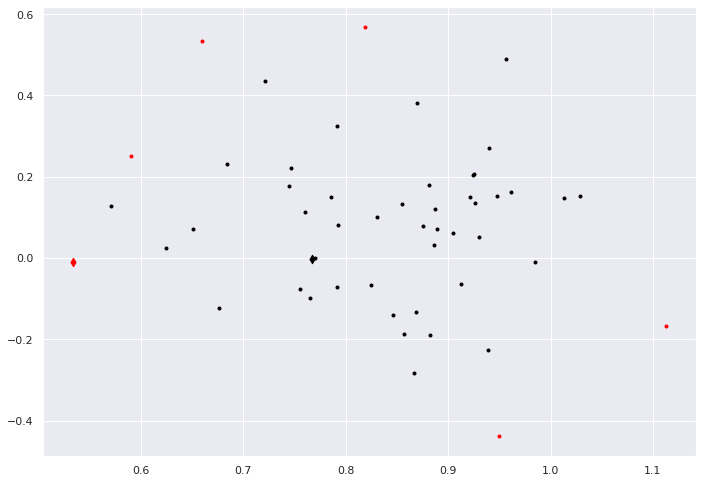

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.08784871010596815
fowlkes_mallows_score: 0.8593137949514248
homogeneity_completeness_v_measure: 0.018804146280886388 0.01417224989139423 0.01616289777056148


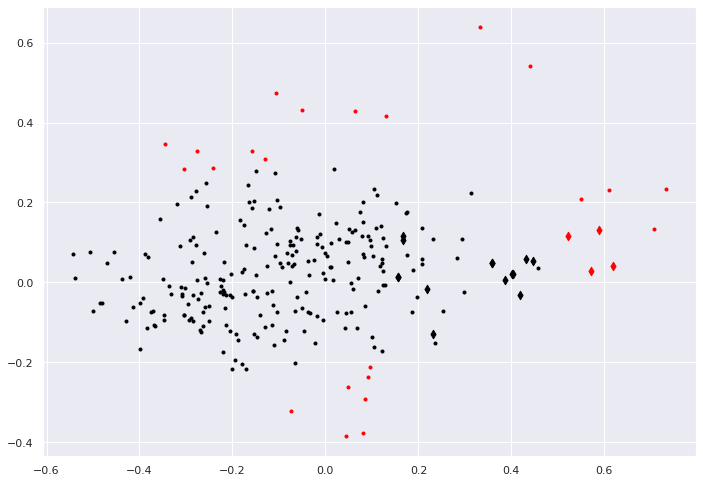

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.22267379250297864
fowlkes_mallows_score: 0.9015545564162515
homogeneity_completeness_v_measure: 0.20881124961107098 0.08093465192634508 0.11665439073273529


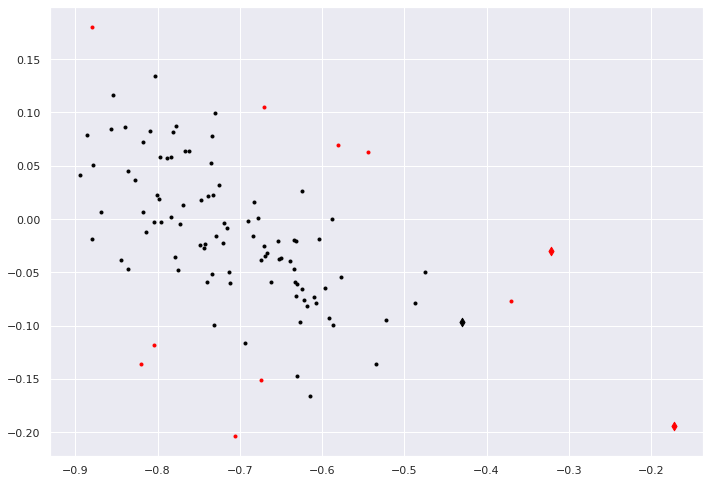

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


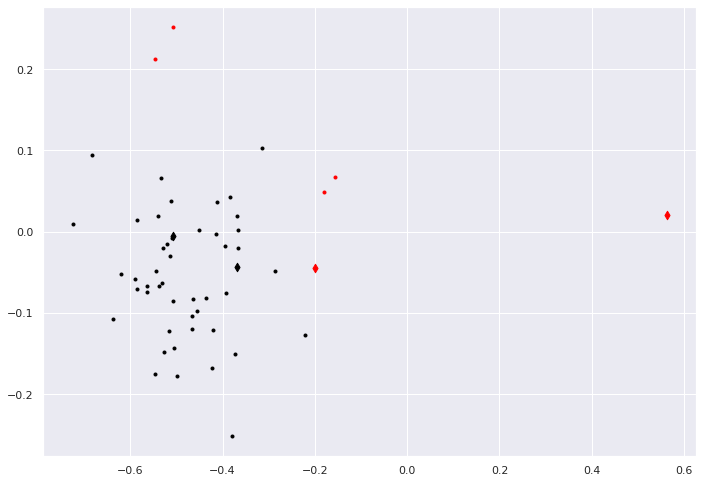

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.22267379250297864
fowlkes_mallows_score: 0.9015545564162515
homogeneity_completeness_v_measure: 0.20881124961107098 0.08093465192634508 0.11665439073273529


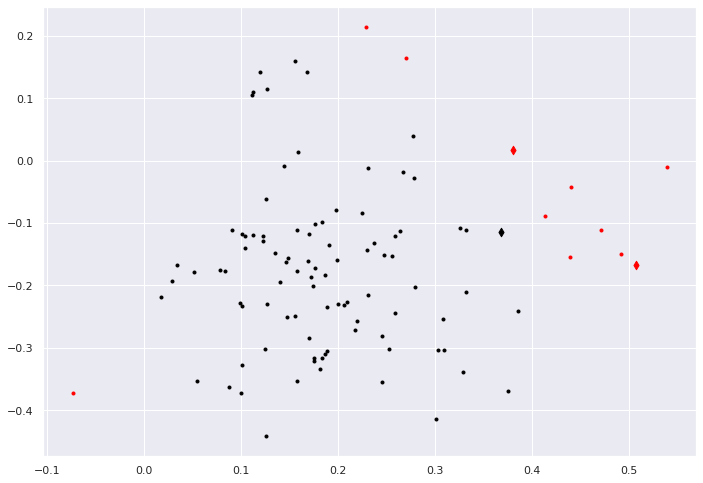

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


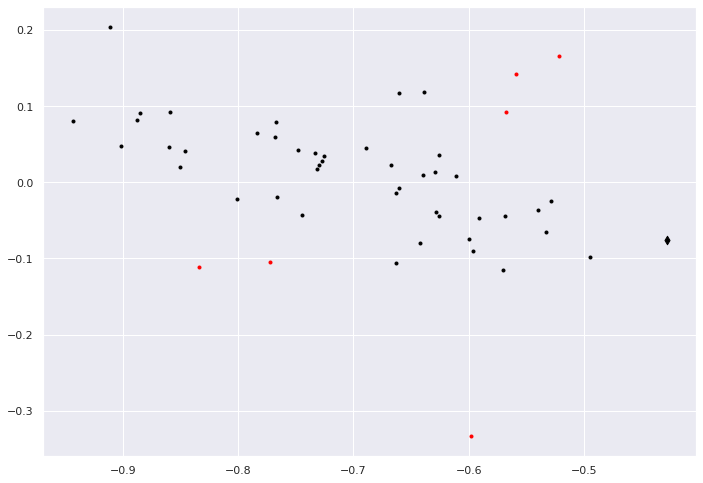

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.32687734044686106
fowlkes_mallows_score: 0.9100046418975695
homogeneity_completeness_v_measure: 0.2938327517060728 0.1418983542457077 0.19137666933144515


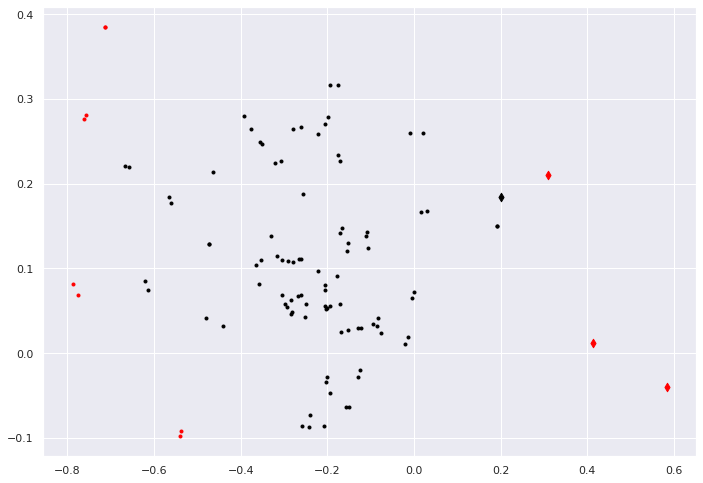

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


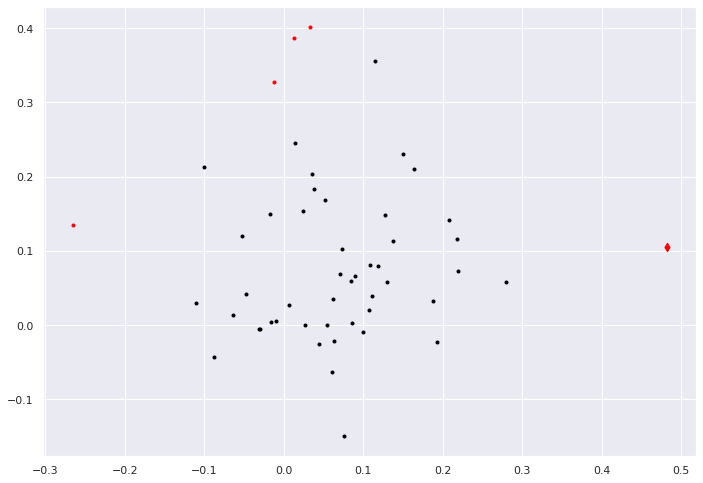

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.5952582358193524
fowlkes_mallows_score: 0.9369687007474506
homogeneity_completeness_v_measure: 0.6392515284712909 0.3937178184645023 0.48730336091078497


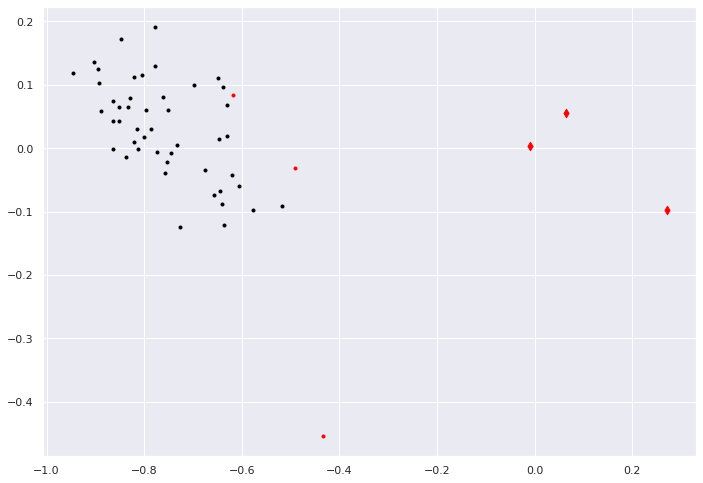

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.06795582871133764
fowlkes_mallows_score: 0.8401412990524931
homogeneity_completeness_v_measure: 0.029137437566274186 0.020954926639213358 0.02437788179257259


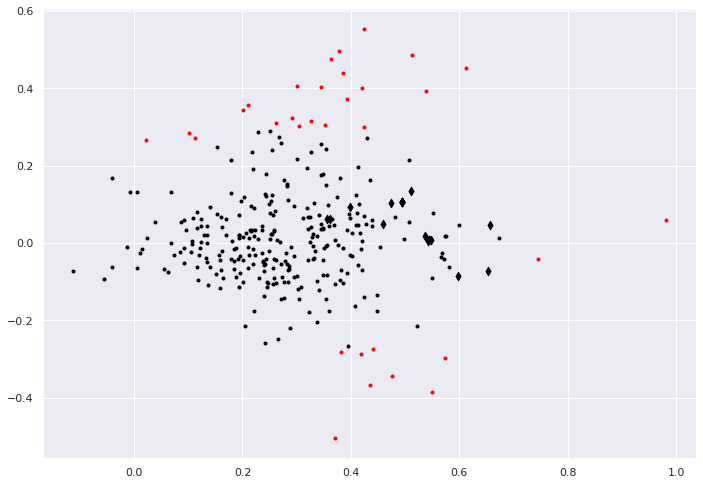

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.5436997918410137
fowlkes_mallows_score: 0.9386503207015755
homogeneity_completeness_v_measure: 0.6167940320942551 0.3414107948907943 0.43953053637556627


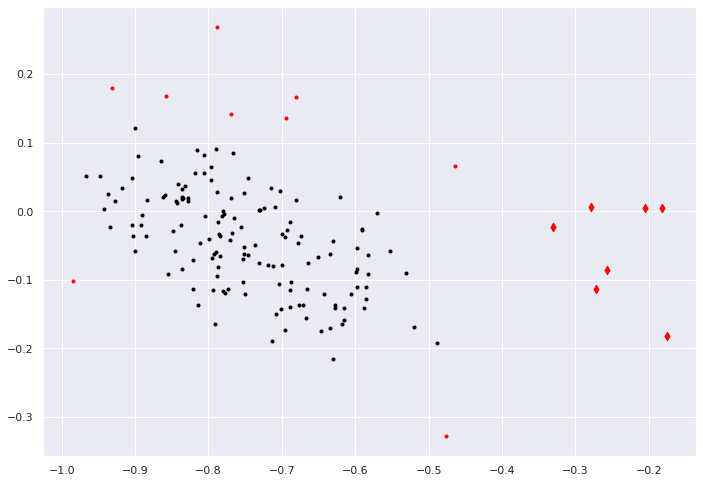

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


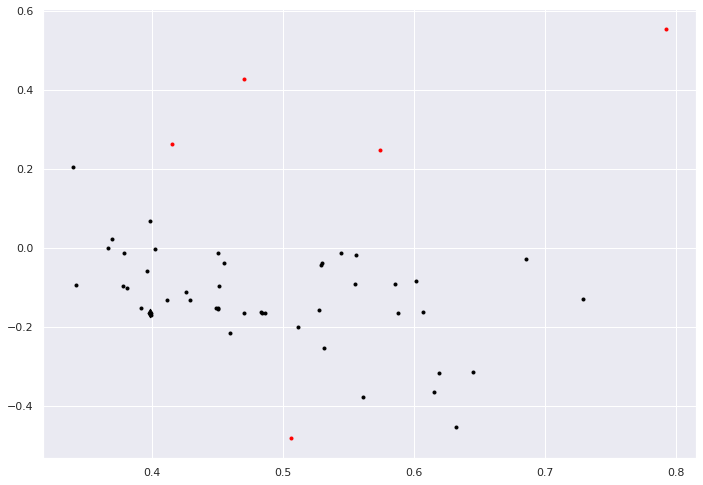

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


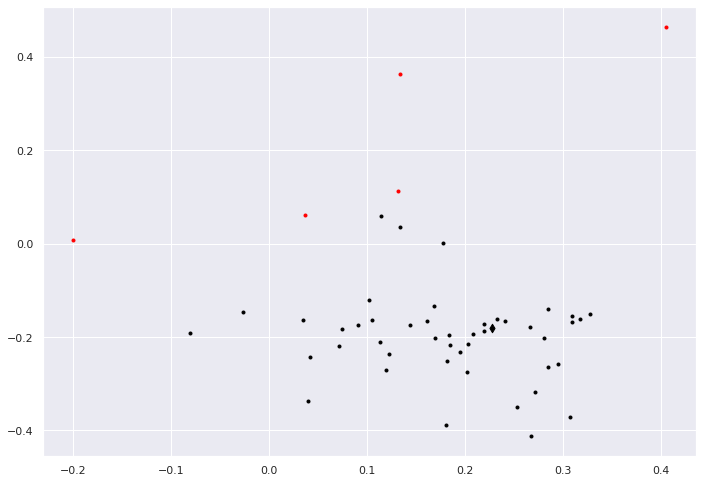

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


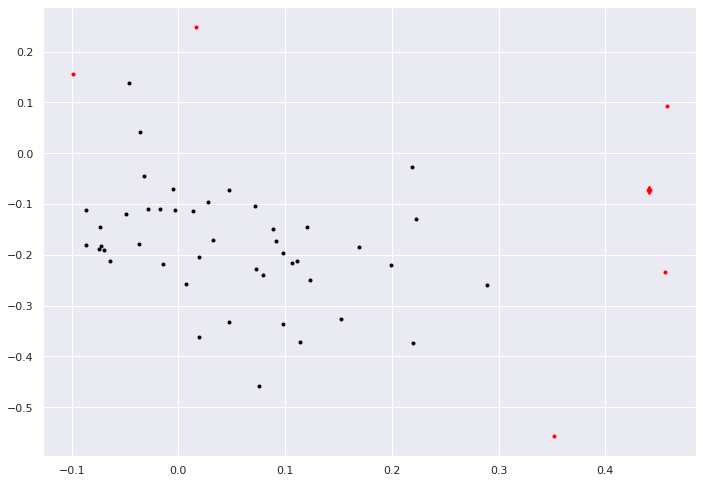

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


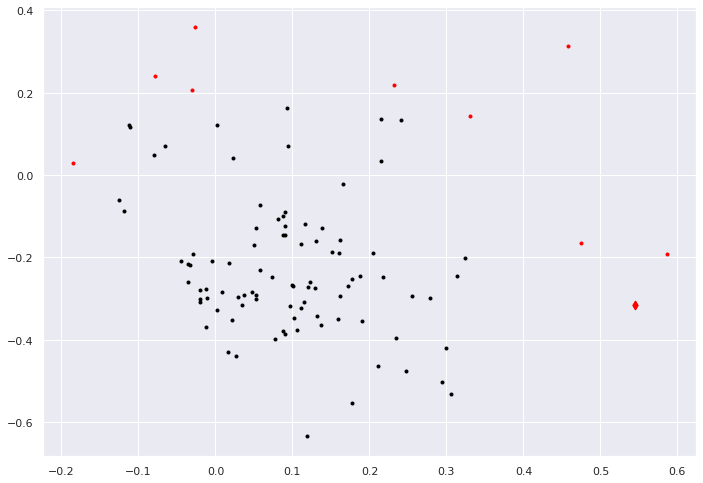

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.43626603012634224
fowlkes_mallows_score: 0.9297267996688643
homogeneity_completeness_v_measure: 0.5630044070805916 0.2534424952159976 0.34953710118009346


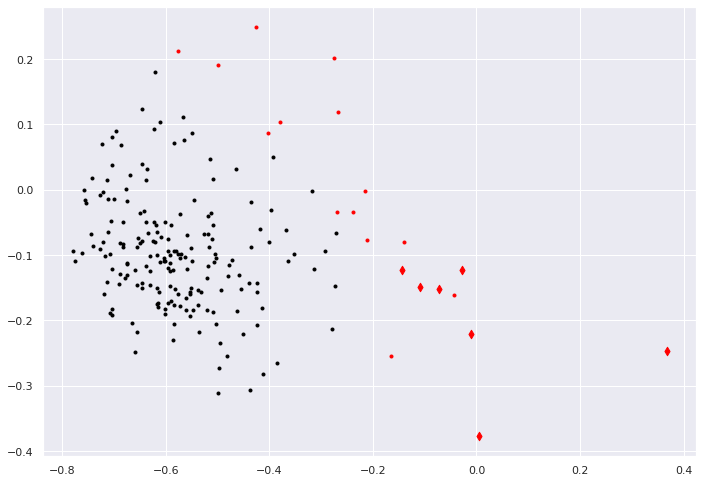

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.20558762631314134
fowlkes_mallows_score: 0.8970870823718041
homogeneity_completeness_v_measure: 0.12821348330016935 0.06388273219273119 0.08527630381624712


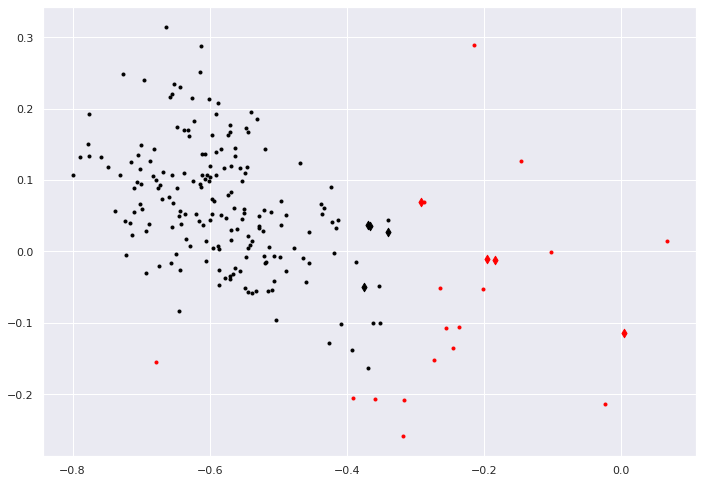

In [25]:
from sklearn.covariance import EllipticEnvelope


# add grid search to nu


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  values.append({'contamination':0.02})
clustering_function(familyes,df_data, df, EllipticEnvelope, params=None)




In [26]:
import pandas as pd

a = pd.DataFrame(all_res_table)
len(a.family_lable.unique())
a

algo   family_lable  \
0             <class 'sklearn.cluster._dbscan.DBSCAN'>      Aeropyrum   
1             <class 'sklearn.cluster._dbscan.DBSCAN'>     Agmenellum   
2             <class 'sklearn.cluster._dbscan.DBSCAN'>  Agrobacterium   
3             <class 'sklearn.cluster._dbscan.DBSCAN'>       Anabaena   
4             <class 'sklearn.cluster._dbscan.DBSCAN'>   Arthrobacter   
..                                                 ...            ...   
187  <class 'sklearn.covariance._elliptic_envelope....   Thermococcus   
188  <class 'sklearn.covariance._elliptic_envelope....   Thermoplasma   
189  <class 'sklearn.covariance._elliptic_envelope....     Thermotoga   
190  <class 'sklearn.covariance._elliptic_envelope....        Thermus   
191  <class 'sklearn.covariance._elliptic_envelope....    Xanthomonas   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
0   -0.030213  0.902127     0.016766      0.005886   0.008713  0.000000   
1    0.073735  0.786200     0.283728      0.048237   0.082456  0.019608   
2   -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
3   -0.083153  0.752376     0.059950      0.033037   0.042599  0.000000   
4    0.072720  0.709096     0.334480      0.046798   0.082108  0.019481   
..        ...       ...          ...           ...        ...       ...   
187 -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
188  0.230315  0.901258     0.450754      0.120101   0.189666  0.019608   
189  0.254852  0.911570     0.470177      0.132686   0.206966  0.019608   
190  0.436266  0.929727     0.563004      0.253442   0.349537  0.033816   
191  0.205588  0.897087     0.128213      0.063883   0.085276  0.019231   

           fp        fn        tn  family_size  re_size  
0    0.019608  0.078431  0.901961           51        1  
1    0.000000  0.235294  0.745098           51        1  
2    0.019608  0.098039  0.882353           51        1  
3    0.074074  0.185185  0.740741           54        4  
4    0.006494  0.084416  0.889610          154        4  
..        ...       ...       ...          ...      ...  
187  0.019608  0.098039  0.882353           51        1  
188  0.000000  0.098039  0.882353           51        1  
189  0.000000  0.088235  0.892157          102        2  
190  0.000000  0.067633  0.898551          207        7  
191  0.019231  0.081731  0.879808          208        8  

[192 rows x 13 columns]

In [27]:
a.sort_values(by =['fmi'] , ascending = False).to_csv('res_of_iadf_plus_pca.csv')

In [28]:
a.sort_values(by =['tp'], ascending = False)

algo  family_lable  \
108         <class 'sklearn.svm._classes.OneClassSVM'>   Citrobacter   
162  <class 'sklearn.covariance._elliptic_envelope....  Enterobacter   
114         <class 'sklearn.svm._classes.OneClassSVM'>  Enterobacter   
18            <class 'sklearn.cluster._dbscan.DBSCAN'>  Enterobacter   
66   <class 'sklearn.ensemble._iforest.IsolationFor...  Enterobacter   
..                                                 ...           ...   
117         <class 'sklearn.svm._classes.OneClassSVM'>   Fischerella   
48   <class 'sklearn.ensemble._iforest.IsolationFor...     Aeropyrum   
43            <class 'sklearn.cluster._dbscan.DBSCAN'>  Thermococcus   
164  <class 'sklearn.covariance._elliptic_envelope....   Eubacterium   
0             <class 'sklearn.cluster._dbscan.DBSCAN'>     Aeropyrum   

          ari       fmi  homogeneity  completeness  v_measure        tp  \
108  0.033874  0.652369     0.227843      0.100160   0.139150  0.090909   
162  0.878654  0.977902     0.838653      0.741370   0.787017  0.090909   
114  0.033874  0.652369     0.227843      0.100160   0.139150  0.090909   
18   0.775836  0.956159     0.750051      0.599452   0.666349  0.090909   
66   0.385783  0.834821     0.483042      0.269089   0.345635  0.090909   
..        ...       ...          ...           ...        ...       ...   
117 -0.001511  0.685714     0.138836      0.019336   0.033944  0.000000   
48  -0.026399  0.773431     0.055126      0.009751   0.016571  0.000000   
43  -0.028976  0.920937     0.012443      0.005368   0.007500  0.000000   
164 -0.030689  0.883840     0.021184      0.006374   0.009799  0.000000   
0   -0.030213  0.902127     0.016766      0.005886   0.008713  0.000000   

           fp        fn        tn  family_size  re_size  
108  0.000000  0.400000  0.509091           55        5  
162  0.000000  0.018182  0.890909           55        5  
114  0.000000  0.400000  0.509091           55        5  
18   0.000000  0.036364  0.872727           55        5  
66   0.000000  0.145455  0.763636           55        5  
..        ...       ...       ...          ...      ...  
117  0.019608  0.490196  0.490196           51        1  
48   0.019608  0.235294  0.745098           51        1  
43   0.019608  0.058824  0.921569           51        1  
164  0.019608  0.098039  0.882353           51        1  
0    0.019608  0.078431  0.901961           51        1  

[192 rows x 13 columns]

In [29]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['family_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ family_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.09082264145502357
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.580
Date:                Mon, 06 Mar 2023   Prob (F-statistic):              0.210
Time:                        12:51:45   Log-Likelihood:                 175.10
No. Observations:                 192   AIC:                            -346.2
Df Residuals:                     190   BIC:                            -339.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Inte

In [30]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['re_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ re_size', data=a).fit()
print(model.summary())

Correlation coefficient: -0.13795000592675702
                            OLS Regression Results                            
Dep. Variable:                    fmi   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.686
Date:                Mon, 06 Mar 2023   Prob (F-statistic):             0.0564
Time:                        12:51:45   Log-Likelihood:                 176.15
No. Observations:                 192   AIC:                            -348.3
Df Residuals:                     190   BIC:                            -341.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc